In [20]:
import json
import nltk
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions.normal as normal
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize import MWETokenizer

import csv
from gensim.models import Word2Vec
import os.path

# plt.style.use('seaborn')
# plt.style.use('seaborn-bright')
# plt.style.use('seaborn-white')

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/eliisabethein/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:
torch.manual_seed(0)
np.random.seed(0)

### Functions

In [22]:
def load_data(filename, max_sentence_len, with_labels=False):
    # the tokenizer splits <unk> so we use MWETokenizer to re-merge it
    data_original = []
    data_padded = []
    with open(filename, encoding="utf8") as f:
        for line in f:
            sentence, padded_sentence = tokenize_sentence(line, max_sentence_len, with_labels)
            data_original.append(sentence)
            data_padded.append(padded_sentence)
    
    return data_original, data_padded

In [23]:
def tokenize_sentence(string, max_sentence_len, with_labels=False, occurrences=None):
    merger = MWETokenizer([('<', 'unk', '>')], separator = '') 
    sentence = word_tokenize(string.strip())       # tokenize sentence
    sentence = merger.tokenize(sentence)         # merge <unk>
    if with_labels:
        sentence = sentence[1:]
    sentence = [token.lower() for token in sentence]            
    sentence = sentence[:max_sentence_len - 2]   # cut sentence at max_sentence_length    
    sentence = ['<sos>'] + sentence + ['<eos>']  # add start and end-of-sentence tags
    if occurrences is not None:
        for word in sentence:
            if word in occurrences:
                occurrences[word] += 1
            else:
                occurrences[word] = 1

    # pad the rest of the sentence
    padded_sentence = sentence.copy()
    padded_sentence.extend(['<pad>']*(max_sentence_len - len(sentence))) 
    
    if occurrences is not None:
        return sentence, padded_sentence, occurrences
    else:
        return sentence, padded_sentence

In [24]:
def get_batches_text(data, data_padded, batch_size, pad_index, word2vec_model, unk_word='<unk>'):
    inputs = []
    targets = []
    lengths = []
    for i in range(len(data) // batch_size):
        # take batch_size sentences from the data each time
        batch_sentences = data[i*batch_size:(i+1)*batch_size]
        batch_sentence_lens = [len(x) for x in batch_sentences]
        
        # sentences in a batch have to be sorted in decreasing order of length (for pack_padded_sentence)
        sorted_pairs = sorted(zip(batch_sentence_lens,batch_sentences), reverse=True)
        batch_sentences = [sentence for length, sentence in sorted_pairs]
        batch_sentence_lens = [length-1 for length, sentence in sorted_pairs]
        
        # each input and target is a (batch_size x max_sentence_len-1 x 1) matrix
        # initially filled with the index for padditng tag <pad>
        input_batch = np.ones((batch_size, len(data_padded[0])-1, 1)) * pad_index
        target_batch = np.ones((batch_size, len(data_padded[0])-1, 1)) * pad_index
        
        # for each sentence in the batch, fill the corresponding row in current_batch
        # with the indexed of the words in the sentence (except for <pad>)
        for j, sentence in enumerate(batch_sentences):
            word_indexes = np.array([word2vec_model.wv.vocab[word].index if word in word2vec_model.wv.vocab else word2vec_model.wv.vocab[unk_word].index for word in sentence])
            input_batch[j,0:len(sentence)-1,0] = word_indexes[:-1]
            target_batch[j,0:len(sentence)-1,0] = word_indexes[1:]
        
        # make the matrices into torch tensors and append
        inputs.append(input_batch)
        targets.append(target_batch)
        lengths.append(batch_sentence_lens)
    return inputs, targets, lengths

def get_batches_synthetic(data, batch_size):
    inputs = []
    targets = []

    for i in range(len(data) // batch_size):
        batch_sentences = data[i * batch_size:(i+1) * batch_size]

        input_batch = np.ones((batch_size, data.shape[1] - 1, 1)) 
        target_batch = np.ones((batch_size, data.shape[1] - 1, 1)) 
        for j, sentence in enumerate(batch_sentences):
                input_batch[j,0:len(sentence)-1,0] = sentence[:-1]
                target_batch[j,0:len(sentence)-1,0] = sentence[1:]
        inputs.append(input_batch)
        targets.append(target_batch)
    
    return inputs, targets

### Encoder-decoder

In [25]:
class Encoder(nn.Module):
    def __init__(self, hidden_size, num_layers, embedding_weights, synthetic=False):
        super(Encoder, self).__init__()
        # parameters
        self.embedding_size = embedding_weights.shape[1]
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = True
        
        #layers
        self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.num_layers, batch_first=self.batch_first)
        
    def forward(self, x, hidden, x_lens=None, train=True):
        batch_size, max_len, _ = x.shape
        
        x = torch.tensor(x, dtype=torch.long)  # make the input into a torch tensor
        x = self.embed(x).view(batch_size, max_len, self.embedding_size)

        if x_lens is not None and train:
            x_lens = torch.tensor(x_lens, dtype=torch.long)
            x = pack_padded_sequence(x, x_lens, batch_first=self.batch_first)
            
        output, hidden = self.lstm(x.float(), hidden) 

        if x_lens is not None and train:
            output, output_lens = pad_packed_sequence(output, batch_first=self.batch_first, 
                                                      total_length=max_sentence_length-1)
        return output, hidden
    
    def init_hidden(self, batch_size):
        h = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return (h, c)

In [26]:
class Decoder(nn.Module):
    def __init__(self,hidden_size, num_layers, embedding_weights, synthetic=False):
        super(Decoder, self).__init__()
        # parameters
        self.vocabulary_size = embedding_weights.shape[0]
        self.embedding_size = embedding_weights.shape[1]
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = True
        
        # layers
        self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.num_layers, batch_first=self.batch_first)
        self.linear = nn.Linear(self.hidden_size, self.vocabulary_size)

    def forward(self, x, hidden, x_lens=None, train=True):
        batch_size, max_len, _ = x.shape
        
        x = torch.tensor(x, dtype=torch.long)  # make the input into a torch tensor
        x = self.embed(x).view(batch_size, max_len, self.embedding_size)
        
        if x_lens is not None and train:
            x_lens = torch.tensor(x_lens, dtype=torch.long)
            x = pack_padded_sequence(x, x_lens, batch_first=self.batch_first)

        output, hidden = self.lstm(x.float(), hidden) 
        
        if x_lens is not None and train:
            output, output_lens = pad_packed_sequence(output, batch_first=self.batch_first, 
                                                      total_length=max_sentence_length-1)
        
        output = output.reshape(output.size(0)*output.size(1), output.size(2))
        output = self.linear(output)
        
        return output, hidden
    

### VAE

In [27]:
class StochasticEncoder(nn.Module):
    def __init__(self, hidden_dim, num_layers, latent_dim, synthetic=False):
        super(StochasticEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.batch_first = True
        
        self.hidden_to_mean = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
        self.hidden_to_logvar = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)

    def reparametrize(self, mean, log_variance):
        eps = torch.randn_like(mean)
        return mean + eps * torch.exp(0.5 * log_variance)
        
    def forward(self, hidden_concatenated):
        mean = self.hidden_to_mean(hidden_concatenated)
        log_variance = self.hidden_to_logvar(hidden_concatenated)
        z = self.reparametrize(mean, log_variance)
        return z, mean, log_variance

In [28]:
class StochasticDecoder(nn.Module):
    def __init__(self, hidden_dim, num_layers, latent_dim, synthetic=False):
        super(StochasticDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.batch_first = True
        
        self.latent_to_hidden = nn.Linear(latent_dim, 2 * self.hidden_dim * num_layers, self.batch_first)
        
    def forward(self, z):
        hidden_concatenated = self.latent_to_hidden(z)
        return hidden_concatenated

In [29]:
# new VAE
class VAE(nn.Module):
    def __init__(self, hidden_dim, num_layers, embedding_weights, latent_dim, synthetic=False):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.batch_first = True
        
        self.encoder = Encoder(self.hidden_dim, num_layers, embedding_weights, synthetic)
        self.stochastic_encoder = StochasticEncoder(self.hidden_dim, num_layers, self.latent_dim, synthetic)
        self.stochastic_decoder = StochasticDecoder(self.hidden_dim, num_layers, self.latent_dim, synthetic)
        self.decoder = Decoder(self.hidden_dim, num_layers, embedding_weights, synthetic)
        
        # THIS PART IS IMPORTANT -- I think it re-initialises all of the weights in the network with
        ## this distribution, even the embedding weights, which we initialised to (-0.1,0.1) before;
        ## with this distribution it (kind of) works both without annealing and with annealing 
        ## (why??? who knows)
        if synthetic:          
            for param in self.parameters():
                nn.init.uniform_(param, -0.01, 0.01)
            nn.init.uniform_(self.encoder.embed.weight, -0.1, 0.1)
            nn.init.uniform_(self.decoder.embed.weight, -0.1, 0.1)
        
    def encode(self, x, x_lens=None):
        batch_size, max_len, _ = x.shape
        hidden = self.encoder.init_hidden(batch_size)
        _, hidden = self.encoder.forward(x, hidden, x_lens)
        return hidden
    
    def latent_to_hidden(self, z):
        return self.stochastic_decoder.latent_to_hidden(z)
        
    # with teacher forcing
    def decode(self, hidden, x, x_lens=None, train=True): 
        outputs, _ = self.decoder.forward(x, hidden, x_lens, train)
        return outputs
    
    def forward(self, x, x_lens=None, dropout_rate=0, unk_index=0):
        hidden = self.encode(x, x_lens)
        hidden_concatenated = torch.cat((hidden[0], hidden[1]), 2)
        z, mean, log_variance = self.stochastic_encoder.forward(hidden_concatenated)
        hidden_concatenated = self.stochastic_decoder.forward(z)
        hidden = torch.split(hidden_concatenated, self.hidden_dim, dim=2)
        
        # word dropout
        if dropout_rate != 0.0:
            drop_probs = np.random.random_sample(x.shape)
            drop_probs[:, 0] = 1                  # set the <sos> token to 1 (always keep)
            for i, x_len in enumerate(x_lens):
                drop_probs[i, x_len:, 0] = 1      # set the <pad> tokens to 1 (always keep)
            dropped_x = x.copy()
            dropped_x[drop_probs < dropout_rate] = unk_index
            outputs = self.decode(hidden, dropped_x, x_lens)
        else:
            outputs = self.decode(hidden, x, x_lens)
            
        return mean, log_variance, outputs
    
    def calc_mi(self, x):
        # I(x, z) = E_xE_{q(z|x)}log(q(z|x)) - E_xE_{q(z|x)}log(q(z))
        mean, log_variance, _ = self.forward(x)
        _, batch_size, _ = mean.size()

        # E_{q(z|x)}log(q(z|x)) = -0.5*nz*log(2*\pi) - 0.5*(1+logvar).sum(-1)
        neg_entropy = (-0.5 * self.latent_dim * np.log(2 * np.pi)- 0.5 * (1 + log_variance).sum(-1)).mean()

        z = self.stochastic_encoder.reparametrize(mean, log_variance)
        mean, log_variance = mean.unsqueeze(0), log_variance.unsqueeze(0)

        log_density = -0.5 * (((z - mean) ** 2) / log_variance.exp()).sum(dim=-1) - \
            0.5 * (self.latent_dim * np.log(2 * np.pi) + log_variance.sum(-1))

        log_qz = log_sum_exp(log_density, dim=1) - np.log(batch_size)

        return (neg_entropy - log_qz.mean(-1)).item()

In [30]:
def loss_function(outputs, labels, mean, log_variance, seq_length, annealing_args=None, mask=None):
    if mask is not None:
        BCE = torch.zeros(mean.shape[1] * (seq_length - 1))
        BCE[mask] = nn.CrossEntropyLoss(reduction='none')(outputs, labels)
    else:
        BCE = nn.CrossEntropyLoss(reduction='none')(outputs, labels)
    BCE = BCE.view(mean.shape[1], -1).sum(-1)
    KLD = -0.5 * (1 + log_variance - mean.pow(2) - log_variance.exp()).permute(1, 0, 2).sum(-1).squeeze(-1)
    if annealing_args is not None:
        kl_weight = kl_annealing_weight(annealing_args['type'], annealing_args['step'], annealing_args['k'], annealing_args['first_step'])
    else:
        kl_weight = 1.0
    weighted_KLD = kl_weight * KLD
    loss = BCE + weighted_KLD
    return loss, BCE, KLD, weighted_KLD, kl_weight
    
def kl_annealing_weight(annealing_type, step, k, first_step):
    if annealing_type == 'logistic':
        return float(1/(1+np.exp(-k*(step-first_step))))
    elif annealing_type == 'linear':
        return min(1, step/first_step)

In [31]:
def generate_interpolation_sequence(z1, z2, number_of_sentences_to_decode):
    interpolations = np.zeros((z1.shape[0], number_of_sentences_to_decode + 2))
    for dimension_of_z, (i, j) in enumerate(zip(z1, z2)):
        interpolations[dimension_of_z] = np.linspace(i, j, number_of_sentences_to_decode + 2)    
    return interpolations.T

### True posterior

In [32]:
def log_sum_exp(value, dim=None, keepdim=False):
    """Numerically stable implementation of the operation
    value.exp().sum(dim, keepdim).log() - copied from repo, we should change it
    """
    if dim is not None:
        m, _ = torch.max(value, dim=dim, keepdim=True)
        value0 = value - m
        if keepdim is False:
            m = m.squeeze(dim)
        return m + torch.log(torch.sum(torch.exp(value0), dim=dim, keepdim=keepdim))
    else:
        m = torch.max(value)
        sum_exp = torch.sum(torch.exp(value - m))
        return m + torch.log(sum_exp)

def compute_true_posterior(latent_grid, vae, inputs, targets):
    log_true_posterior = compute_true_log_posterior(latent_grid, vae, inputs, targets)
    true_posterior = log_true_posterior.exp()
    return true_posterior

def compute_true_log_posterior(latent_grid, vae, inputs, targets):
    latent_grid = latent_grid.unsqueeze(0).expand(inputs.shape[0], *latent_grid.size()).contiguous().permute(1, 0, 2)
    
    # Compute the true joint
    log_true_joint = compute_true_joint(latent_grid, vae, inputs, targets)
    
    # Normalize by marginalizing z
    log_true_posterior = log_true_joint - log_sum_exp(log_true_joint, dim=0, keepdim=True)
    return log_true_posterior

def compute_true_joint(latent_grid, vae, inputs, targets):
    n_sample, batch_size, latent_dim = latent_grid.size()
    seq_len = inputs.shape[1]
    # Compute prior p(z)
    normal = torch.distributions.normal.Normal(torch.zeros(latent_dim), torch.ones(latent_dim))
    log_true_prior = normal.log_prob(latent_grid).sum(dim=-1)
    
    # Compute conditional p(x | z)
    log_true_conditional = torch.zeros(latent_grid.size(0), latent_grid.size(1))
    tensor_target_batch = torch.tensor(targets.reshape(-1), dtype=torch.long)
    for i in range(latent_grid.size(0)):
        hidden_concatenated = vae.latent_to_hidden(latent_grid[i]).unsqueeze(0)
        hidden = torch.split(hidden_concatenated, vae.hidden_dim, dim=-1)
        outputs = vae.decode(hidden, inputs, train=False)
        log_true_conditional[i] = -nn.CrossEntropyLoss(reduction='none')(outputs, tensor_target_batch).view(batch_size, -1).sum(-1)
        
    # Compute joint p(x, z)
    log_true_joint = log_true_prior + log_true_conditional
    return log_true_joint

def compute_true_posterior_mean(true_posterior, latent_grid):
    return torch.mul(true_posterior.unsqueeze(2), latent_grid.unsqueeze(0)).sum(1)

def generate_grid(lower, upper, step, dim=2):
    line = torch.arange(lower, upper, step)
    total_points = line.size(0)
    if dim == 2:
        z1 = line.unsqueeze(1).repeat(1, total_points).view(-1)
        z2 = line.repeat(total_points)
        return torch.cat((z1.unsqueeze(-1), z2.unsqueeze(-1)), dim=-1)
    elif dim == 1:
        return line.unsqueeze(1)

In [33]:
def plot_mean_space(step, latent_size, vae, tracked_inputs, tracked_targets, lim=3, 
                    iteration=None, save=True, plot_dir="plots"):
    latent_grid = generate_grid(-5, 5, step, latent_size)
    true_posterior = compute_true_posterior(latent_grid, vae, tracked_inputs, tracked_targets)
    true_mean = compute_true_posterior_mean(true_posterior.t(), latent_grid)
    vae.eval()
    approximate_mean, _, _ = vae.forward(tracked_inputs)
    vae.train()
    plt.figure(figsize=(4,4))
    plt.plot(np.linspace(-1.5, 1.5, 100), np.linspace(-1.5, 1.5, 100), color='silver', linestyle='dashed', linewidth=1.0, zorder=1)
    plt.plot(np.linspace(-1.5, 1.5, 100), np.linspace(0, 0, 100), color='silver', linestyle='dashed', linewidth=1.0, zorder=1)
    plt.plot(np.linspace(0, 0, 100), np.linspace(-1.5, 1.5, 100), color='silver', linestyle='dashed', linewidth=1.0, zorder=1)
    plt.scatter(true_mean.detach().numpy(), approximate_mean.detach().numpy(), marker='x', color='skyblue', s=15, zorder=2)
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.xlabel("true posterior mean")
    plt.ylabel("approximate posterior mean")
    if save:
        plt.savefig("{}/mean_space_iteration_{}.pdf".format(plot_dir, iteration), bbox_inches="tight")
    plt.show()

def plot_kl(kl_terms, kl_weights, plot_dir="plots", save=False):
    plot_step = 10
    x_axis = np.arange(len(kl_terms[::plot_step])) * plot_step
    fig, ax1 = plt.subplots(figsize=(8,2.5))
    ax1.plot(x_axis, kl_terms[::plot_step], color="skyblue", label="KL term value")
    ax1.set_xlabel("iteration")
    ax1.set_ylabel("KL term")
    ax2 = ax1.twinx()
    ax2.plot(x_axis, kl_weights[::plot_step], color="mediumorchid", label="KL weight")
    ax2.set_ylabel("KL weight")
    ax2.set_ylim(-0.05,1.05)
#     plt.legend()
    if save:
        plt.savefig("{}/annealing.pdf".format(plot_dir), bbox_inches="tight")
    plt.show()
    
def plot_losses(train_losses, val_losses, save=False, plot_dir="plots"):
    x_axis = np.arange(1,len(train_losses)+1)
    plt.figure(figsize=(5,4))
    plt.plot(x_axis, train_losses, label="training loss", color="skyblue")
    plt.plot(x_axis, val_losses, label="validation loss", color="mediumorchid")
    plt.xlabel("loss")
    plt.ylabel("epoch")
    plt.legend()
    if save:
        plt.savefig("plots/losses.pdf", bbox_inches="tight")
    plt.show()

## Experiments

In [90]:
def train(vae, inputs, targets, validation_inputs, validation_targets, epochs, vocab_size, hidden_size, 
          latent_size, max_sentence_length, num_layers=1, learning_rate=0.001,
          synthetic=False, input_lens=None, val_input_lens=None,               # text-related parameters
          dropout_rate=0.0, unk_index = None,                                  # word dropout parameters
          plot=False, plot_lim=1.5, step=1.0, tracked_inputs=None, tracked_targets=None,      # plotting
          annealing_args=None, is_aggressive=False, verbose=True, plot_dir="plots"):
    
    opt_dict = {"not_improved": 0, "lr": learning_rate, "best_loss": 1e4}
    
    decay_epoch = 2
    lr_decay = 0.5
    max_decay = 5

#     enc_optimizer = torch.optim.SGD(vae.encoder.parameters(), lr=learning_rate)
#     stoch_enc_optimizer = torch.optim.SGD(vae.stochastic_encoder.parameters(), lr=learning_rate)
#     stoch_dec_optimizer = torch.optim.SGD(vae.stochastic_decoder.parameters(), lr=learning_rate)
#     dec_optimizer = torch.optim.SGD(vae.decoder.parameters(), lr=learning_rate)
    
    enc_optimizer = torch.optim.Adam(vae.encoder.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    stoch_enc_optimizer = torch.optim.Adam(vae.stochastic_encoder.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    stoch_dec_optimizer = torch.optim.Adam(vae.stochastic_decoder.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    dec_optimizer = torch.optim.Adam(vae.decoder.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    
    if annealing_args is not None:
        kl_terms = []
        kl_weights = []

    iteration = 0
    decay_cnt = 0
    kl_losses = []
    val_kl_losses = []
    total_epoch_losses = []
    val_total_epoch_losses = []
    
    if plot:
        plot_mean_space(step, latent_size, vae, tracked_inputs, tracked_targets, 
                        lim=plot_lim, iteration=iteration, plot_dir=plot_dir)
    
    previous_mi = -1
        
    for epoch in range(epochs):        
        for i in np.random.permutation(len(inputs)):
            
            inner_iter = 1
            random_i = i
            
            burn_num_words = 0
            burn_pre_loss = 1e4
            burn_cur_loss = 0
            while is_aggressive and inner_iter < 45:
                x = inputs[random_i]
                y = torch.tensor(targets[random_i].reshape(-1), dtype=torch.long)
                x_lens = input_lens[random_i] if not synthetic else None
                
                enc_optimizer.zero_grad()
                stoch_enc_optimizer.zero_grad()
                stoch_dec_optimizer.zero_grad()
                dec_optimizer.zero_grad()
                
                if synthetic:
                    burn_batch_size, burn_sents_len, _ = x.shape
                    burn_num_words += burn_sents_len * burn_batch_size
                else:
                    burn_num_words = np.sum(x_lens)
                
                mask = None
                mean, log_variance, outputs = vae(x, x_lens=x_lens)
                if not synthetic:
                    mask = (y < padding_index)
                    outputs = outputs[mask]
                    y = y[mask]
    
                loss_summary = loss_function(outputs, y, mean, log_variance, max_sentence_length, annealing_args=annealing_args, mask=mask)
                
                loss = loss_summary[0]
                burn_cur_loss += loss.sum().item()
                
                loss = loss.mean(dim=-1)
                loss.backward()

#                 print("inner iteration {}, burn curr loss {}, curr loss {}".format(inner_iter, burn_cur_loss, loss))
                
                clip_grad_norm_(vae.parameters(), 5.0)
                
                enc_optimizer.step()
                stoch_enc_optimizer.step()
                
                random_i = np.random.randint(0, len(inputs)- 1)
                if inner_iter % 15 == 0:
                    burn_cur_loss = burn_cur_loss / burn_num_words
                    if burn_pre_loss - burn_cur_loss < 0:
                        break
                    burn_pre_loss = burn_cur_loss
                    burn_cur_loss = 0
                    burn_num_words = 0
                inner_iter += 1
              
            x = inputs[i]
            y = torch.tensor(targets[i].reshape(-1), dtype=torch.long)
            x_lens = input_lens[i] if not synthetic else None  
            
            mask = None
            mean, log_variance, outputs = vae(x, x_lens=x_lens, dropout_rate=dropout_rate, unk_index=unk_index)

            if not synthetic:
                mask = (y < padding_index)
                outputs = outputs[mask]
                y = y[mask]
            
            enc_optimizer.zero_grad()
            stoch_enc_optimizer.zero_grad()
            stoch_dec_optimizer.zero_grad()
            dec_optimizer.zero_grad()
            
            loss_summary = loss_function(outputs, y, mean, log_variance, max_sentence_length, annealing_args=annealing_args, mask=mask)
            
#             total_losses.append(np.mean(loss_summary[0].data.numpy()))
#             ce_losses.append(np.mean(loss_summary[1].data.numpy()))
#             kl_losses.append(np.mean(loss_summary[3].data.numpy()))
            
            loss = loss_summary[0]
                
            loss = loss.mean(dim=-1)
            
            if annealing_args is not None:
                kl_terms.append(np.mean(loss_summary[2].data.numpy()))
                kl_weights.append(loss_summary[4])     
            
            loss.backward()
            clip_grad_norm_(vae.parameters(), 5.0)
            
            if not is_aggressive:
                enc_optimizer.step()
                stoch_enc_optimizer.step()
                
            dec_optimizer.step()
            stoch_dec_optimizer.step()

            if (iteration % 100 == 0) and verbose:
                print('epoch {} iteration {} loss {:.3f} CE {:.3f} KL {:.3f} weighted KL: {:.3f} weight {:.3f}'.format(epoch+1, 
                            iteration, loss, loss_summary[1].mean(dim=-1).data.item(), \
                            loss_summary[2].mean(dim=-1).data.item(), \
                            loss_summary[3].mean(dim=-1).data.item(), loss_summary[4]))

            iteration += 1
            
            if annealing_args is not None:
                annealing_args['step'] = iteration
        
        if is_aggressive:
            vae.eval()
            current_mi = calc_mi(vae, validation_inputs)
            vae.train()
            print('current_mi:', current_mi)
            if current_mi - previous_mi < 0:
                is_aggressive = False
                print("STOP AGGRESSIVE")

            previous_mi = current_mi
              
        # Validation
        vae.eval()
        with torch.no_grad():
            # NOTE!! if we want to do 100% dropout then we should also add it here.
            val_loss, val_kl, val_ppl = test_vae(vae, validation_inputs, validation_targets, val_input_lens, synthetic, annealing_args)
            loss, kl, ppl = test_vae(vae, inputs, targets, input_lens, synthetic, annealing_args)
            total_epoch_losses.append(loss)
            val_total_epoch_losses.append(val_loss)
            kl_losses.append(kl)
            val_kl_losses.append(val_kl)
            if verbose:
                print ('Epoch [{}/{}], Training Loss: {:.4f},  Training KL: {:.4f}, Training Perplexity: {:5.2f}, Validation Loss: {:.4f}, KL {:.4f}, Val Perplexity: {:5.2f}\n'
                       .format(epoch + 1, epochs, loss, kl, ppl, val_loss, val_kl, val_ppl))
            if plot:
                plot_mean_space(step, latent_size, vae, tracked_inputs, tracked_targets, 
                                lim=plot_lim, iteration=iteration, plot_dir=plot_dir)
                
            if val_loss > opt_dict["best_loss"]:
                opt_dict["not_improved"] += 1
                if opt_dict["not_improved"] >= decay_epoch:
                    opt_dict["best_loss"] = val_loss
                    opt_dict["not_improved"] = 0
                    opt_dict["lr"] = opt_dict["lr"] * lr_decay
                    #vae.load_state_dict(torch.load(args.save_path))
                    print('new lr: %f' % opt_dict["lr"])
                    decay_cnt += 1

#                     enc_optimizer = torch.optim.SGD(vae.encoder.parameters(), lr=opt_dict["lr"])
#                     stoch_enc_optimizer = torch.optim.SGD(vae.stochastic_encoder.parameters(), lr=opt_dict["lr"])
#                     stoch_dec_optimizer = torch.optim.SGD(vae.stochastic_decoder.parameters(), lr=opt_dict["lr"])
#                     dec_optimizer = torch.optim.SGD(vae.decoder.parameters(), lr=opt_dict["lr"])
                    
                    enc_optimizer = torch.optim.Adam(vae.encoder.parameters(), lr=opt_dict["lr"])
                    stoch_enc_optimizer = torch.optim.Adam(vae.stochastic_encoder.parameters(), lr=opt_dict["lr"])
                    stoch_dec_optimizer = torch.optim.Adam(vae.stochastic_decoder.parameters(), lr=opt_dict["lr"])
                    dec_optimizer = torch.optim.Adam(vae.decoder.parameters(), lr=opt_dict["lr"])
    
            else:
                opt_dict["not_improved"] = 0
                opt_dict["best_loss"] = val_loss
            
            if decay_cnt == max_decay:
                break
        vae.train()
    
    return_dict = {}
    return_dict['total_epoch_losses'] = np.array(total_epoch_losses)
    return_dict['val_total_epoch_losses'] = np.array(val_total_epoch_losses)
    return_dict['kl_losses'] = np.array(kl_losses)
    return_dict['val_kl_losses'] = np.array(val_kl_losses)

    if annealing_args is not None:
        return_dict['kl_terms'] = np.array(kl_terms)
        return_dict['kl_weights'] = np.array(kl_weights)
    
    return return_dict
        
def test_vae(vae, inputs, targets, input_lens, synthetic=False, annealing_args=None):
    kl_loss = ce_loss = 0
    num_words = num_sents = 0
    for i in np.random.permutation(len(inputs)):
        x = inputs[i]
        y = torch.tensor(targets[i].reshape(-1), dtype=torch.long)
        x_lens = input_lens[i] if not synthetic else None

        batch_size, sents_len, _ = x.shape
        if synthetic:
            num_words += batch_size * sents_len
        else:
            num_words = np.sum(x_lens)
        
        num_sents += batch_size
        
        mask = None
        mean, log_variance, outputs = vae(x, x_lens=x_lens)
        if not synthetic:
            mask = (y < padding_index)
            outputs = outputs[mask]
            y = y[mask]

        loss_summary = loss_function(outputs, y, mean, log_variance, max_sentence_length, annealing_args=annealing_args, mask=mask)

        loss_rc = np.sum(loss_summary[1].data.numpy())
        loss_kl = np.sum(loss_summary[3].data.numpy())
        
        ce_loss += loss_rc.item()
        kl_loss += loss_kl.item()

    #mutual_info = calc_mi(model, test_data_batch)

    loss = (kl_loss + ce_loss) / num_sents
    kl = kl_loss / num_sents
    ppl = np.exp(loss * num_sents / num_words)

    return loss, kl, ppl

    
def calc_mi(model, test_data_batch):
    mi = 0
    num_examples = 0
    for batch_data in test_data_batch:
        batch_size = batch_data.shape[0]
        num_examples += batch_size
        mutual_info = model.calc_mi(batch_data)
        mi += mutual_info * batch_size

    return mi / num_examples

In [40]:
def hist_active_units(vae, train_inputs, train_lengths=None):
    all_mus = None
    for i in range(len(train_inputs)):
        mus, _ = vae.encode(train_inputs[i], train_lengths[i] if train_lengths is not None else None)
        mus = mus.squeeze(0)
        if all_mus is None:
            all_mus = mus.detach().numpy()
        else:
            all_mus = np.vstack((mus.detach().numpy(), all_mus))
    #print(np.sum(np.var(mus.detach().numpy(), axis=0) > 1e-2))
    plt.hist(np.var(mus.detach().numpy(), axis=0), bins=50)
    plt.show()

### Load Synthetic data

In [41]:
test_syn_data = np.loadtxt('synthetic-data/synthetic_test.txt', dtype=int)
train_syn_data = np.loadtxt('synthetic-data/synthetic_train.txt', dtype=int)

In [42]:
batch_size = 16

# load tracked inputs (for plotting)
random_indices = np.random.choice(train_syn_data.shape[0], 500)
tracked_inputs = []
tracked_targets = []
for random_index in random_indices:
    tracked_inputs.append(train_syn_data[random_index, :-1])
    tracked_targets.append(train_syn_data[random_index, 1:])
tracked_inputs = np.expand_dims(np.array(tracked_inputs), axis=-1)
tracked_targets = np.expand_dims(np.array(tracked_targets), axis=-1)

# load data into batches
inputs, targets = get_batches_synthetic(train_syn_data, batch_size)
val_inputs, val_targets = get_batches_synthetic(test_syn_data, batch_size)

### Synthetic data

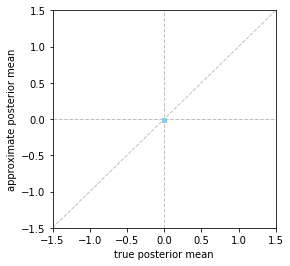

epoch 1 iteration 0 loss 62.172 CE 62.172 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 100 loss 37.228 CE 37.223 KL 0.005 weighted KL: 0.005 weight 1.000
epoch 1 iteration 200 loss 31.950 CE 31.946 KL 0.004 weighted KL: 0.004 weight 1.000
epoch 1 iteration 300 loss 34.750 CE 34.744 KL 0.006 weighted KL: 0.006 weight 1.000
epoch 1 iteration 400 loss 37.843 CE 37.843 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 500 loss 34.307 CE 34.302 KL 0.005 weighted KL: 0.005 weight 1.000
epoch 1 iteration 600 loss 30.134 CE 30.133 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 1 iteration 700 loss 33.603 CE 33.602 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 1 iteration 800 loss 37.014 CE 37.013 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 1 iteration 900 loss 32.661 CE 32.660 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [1/30], Training Loss: 32.4235,  Training KL: 0.0001, Training Perplexity: 36.69, Validation Loss: 37.0991, KL 0.0001, Val Perplexity: 61.69



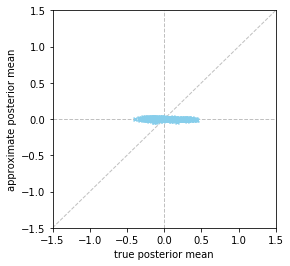

epoch 2 iteration 1000 loss 35.891 CE 35.891 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 2 iteration 1100 loss 29.171 CE 29.171 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 2 iteration 1200 loss 31.532 CE 31.520 KL 0.012 weighted KL: 0.012 weight 1.000
epoch 2 iteration 1300 loss 30.095 CE 30.094 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 2 iteration 1400 loss 27.508 CE 27.508 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 2 iteration 1500 loss 28.393 CE 28.392 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 2 iteration 1600 loss 33.647 CE 33.647 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 2 iteration 1700 loss 34.198 CE 34.196 KL 0.002 weighted KL: 0.002 weight 1.000
epoch 2 iteration 1800 loss 32.983 CE 32.957 KL 0.026 weighted KL: 0.026 weight 1.000
epoch 2 iteration 1900 loss 34.676 CE 34.672 KL 0.004 weighted KL: 0.004 weight 1.000
Epoch [2/30], Training Loss: 31.7469,  Training KL: 0.0018, Training Perplexity: 34.04, Validation Loss: 37.2904, KL 0.0018, Val Perplexity:

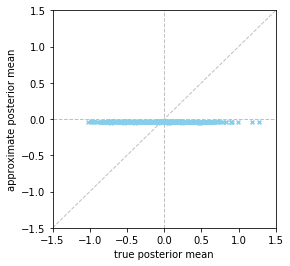

epoch 3 iteration 2000 loss 30.227 CE 30.225 KL 0.002 weighted KL: 0.002 weight 1.000
epoch 3 iteration 2100 loss 29.382 CE 29.379 KL 0.003 weighted KL: 0.003 weight 1.000
epoch 3 iteration 2200 loss 31.344 CE 31.341 KL 0.003 weighted KL: 0.003 weight 1.000
epoch 3 iteration 2300 loss 33.384 CE 33.383 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 3 iteration 2400 loss 29.304 CE 29.304 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 3 iteration 2500 loss 31.998 CE 31.998 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 3 iteration 2600 loss 36.575 CE 36.575 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 3 iteration 2700 loss 37.088 CE 37.087 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 3 iteration 2800 loss 30.263 CE 30.262 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 3 iteration 2900 loss 28.523 CE 28.519 KL 0.003 weighted KL: 0.003 weight 1.000
Epoch [3/30], Training Loss: 31.1088,  Training KL: 0.0029, Training Perplexity: 31.71, Validation Loss: 36.7340, KL 0.0029, Val Perplexity:

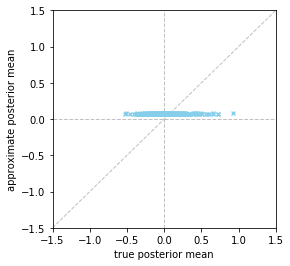

epoch 4 iteration 3000 loss 28.457 CE 28.454 KL 0.003 weighted KL: 0.003 weight 1.000
epoch 4 iteration 3100 loss 34.631 CE 34.626 KL 0.005 weighted KL: 0.005 weight 1.000
epoch 4 iteration 3200 loss 32.974 CE 32.974 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 4 iteration 3300 loss 31.328 CE 31.281 KL 0.047 weighted KL: 0.047 weight 1.000
epoch 4 iteration 3400 loss 28.009 CE 28.008 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 4 iteration 3500 loss 32.508 CE 32.506 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 4 iteration 3600 loss 33.785 CE 33.785 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 4 iteration 3700 loss 31.792 CE 31.791 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 4 iteration 3800 loss 33.701 CE 33.701 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 4 iteration 3900 loss 31.712 CE 31.709 KL 0.003 weighted KL: 0.003 weight 1.000
Epoch [4/30], Training Loss: 31.4023,  Training KL: 0.0038, Training Perplexity: 32.76, Validation Loss: 39.0498, KL 0.0038, Val Perplexity:

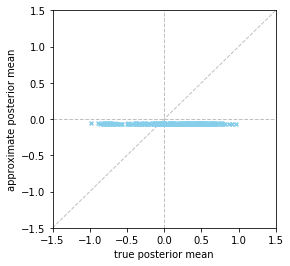

epoch 5 iteration 4000 loss 25.775 CE 25.771 KL 0.004 weighted KL: 0.004 weight 1.000
epoch 5 iteration 4100 loss 28.810 CE 28.809 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4200 loss 31.263 CE 31.263 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4300 loss 28.322 CE 28.322 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4400 loss 28.980 CE 28.979 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4500 loss 26.257 CE 26.257 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4600 loss 32.347 CE 32.347 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4700 loss 31.187 CE 31.184 KL 0.003 weighted KL: 0.003 weight 1.000
epoch 5 iteration 4800 loss 33.536 CE 33.532 KL 0.004 weighted KL: 0.004 weight 1.000
epoch 5 iteration 4900 loss 33.630 CE 33.625 KL 0.005 weighted KL: 0.005 weight 1.000
Epoch [5/30], Training Loss: 30.8369,  Training KL: 0.0474, Training Perplexity: 30.76, Validation Loss: 37.9358, KL 0.0474, Val Perplexity:

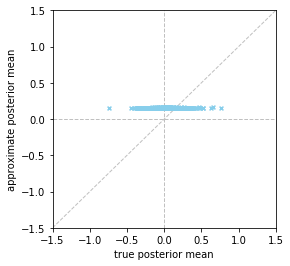

new lr: 0.025000
epoch 6 iteration 5000 loss 30.720 CE 30.673 KL 0.047 weighted KL: 0.047 weight 1.000
epoch 6 iteration 5100 loss 27.878 CE 27.878 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5200 loss 32.880 CE 32.875 KL 0.004 weighted KL: 0.004 weight 1.000
epoch 6 iteration 5300 loss 31.118 CE 31.118 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5400 loss 28.505 CE 28.504 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5500 loss 35.791 CE 35.790 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5600 loss 29.970 CE 29.970 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5700 loss 31.384 CE 31.384 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5800 loss 33.613 CE 33.613 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5900 loss 30.697 CE 30.697 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [6/30], Training Loss: 30.0806,  Training KL: 0.0000, Training Perplexity: 28.28, Validation Loss: 38.8572, KL 0.0000

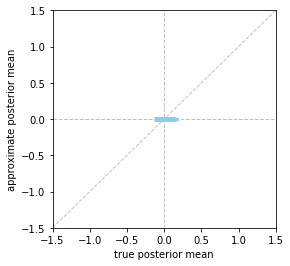

epoch 7 iteration 6000 loss 29.663 CE 29.663 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6100 loss 32.041 CE 32.040 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6200 loss 31.339 CE 31.339 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6300 loss 33.466 CE 33.465 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 7 iteration 6400 loss 32.092 CE 32.092 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6500 loss 31.059 CE 31.059 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6600 loss 32.084 CE 32.084 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6700 loss 31.906 CE 31.906 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6800 loss 27.308 CE 27.307 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6900 loss 27.995 CE 27.995 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [7/30], Training Loss: 29.7839,  Training KL: 0.0000, Training Perplexity: 27.37, Validation Loss: 39.2282, KL 0.0000, Val Perplexity:

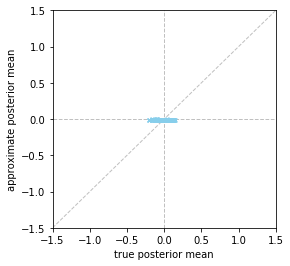

new lr: 0.012500
epoch 8 iteration 7000 loss 25.195 CE 25.194 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7100 loss 28.109 CE 28.107 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 8 iteration 7200 loss 25.595 CE 25.592 KL 0.003 weighted KL: 0.003 weight 1.000
epoch 8 iteration 7300 loss 31.616 CE 31.616 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7400 loss 27.830 CE 27.830 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7500 loss 31.059 CE 31.059 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7600 loss 28.515 CE 28.515 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7700 loss 29.996 CE 29.996 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7800 loss 30.270 CE 30.270 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7900 loss 30.227 CE 30.227 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [8/30], Training Loss: 29.5304,  Training KL: 0.0000, Training Perplexity: 26.61, Validation Loss: 39.7074, KL 0.0000

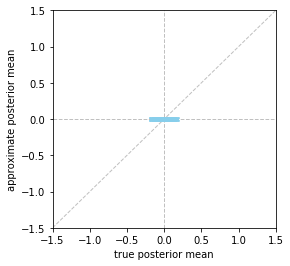

epoch 9 iteration 8000 loss 32.724 CE 32.724 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 9 iteration 8100 loss 29.735 CE 29.735 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 9 iteration 8200 loss 27.708 CE 27.708 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 9 iteration 8300 loss 27.346 CE 27.346 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 9 iteration 8400 loss 33.217 CE 33.217 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 9 iteration 8500 loss 27.035 CE 27.035 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 9 iteration 8600 loss 29.768 CE 29.768 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 9 iteration 8700 loss 25.486 CE 25.485 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 9 iteration 8800 loss 27.940 CE 27.933 KL 0.007 weighted KL: 0.007 weight 1.000
epoch 9 iteration 8900 loss 32.056 CE 32.055 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [9/30], Training Loss: 29.3191,  Training KL: 0.0001, Training Perplexity: 25.99, Validation Loss: 39.4941, KL 0.0001, Val Perplexity:

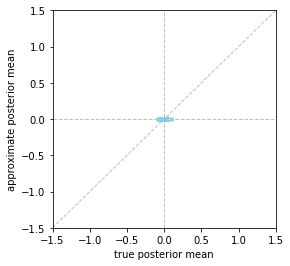

new lr: 0.006250
epoch 10 iteration 9000 loss 30.666 CE 30.666 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9100 loss 27.768 CE 27.768 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9200 loss 28.596 CE 28.596 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9300 loss 30.094 CE 30.093 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 10 iteration 9400 loss 32.230 CE 32.230 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9500 loss 27.817 CE 27.817 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9600 loss 26.763 CE 26.763 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9700 loss 26.835 CE 26.835 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9800 loss 28.020 CE 28.020 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9900 loss 25.611 CE 25.611 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [10/30], Training Loss: 29.2123,  Training KL: 0.0001, Training Perplexity: 25.68, Validation Loss: 39.9176

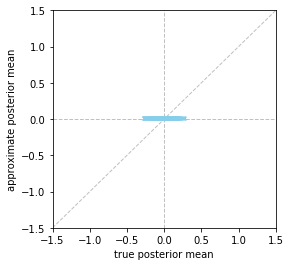

epoch 11 iteration 10000 loss 30.102 CE 30.102 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 11 iteration 10100 loss 27.966 CE 27.966 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 11 iteration 10200 loss 30.794 CE 30.794 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 11 iteration 10300 loss 32.890 CE 32.890 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 11 iteration 10400 loss 30.794 CE 30.794 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 11 iteration 10500 loss 27.587 CE 27.587 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 11 iteration 10600 loss 29.231 CE 29.231 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 11 iteration 10700 loss 29.356 CE 29.356 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 11 iteration 10800 loss 28.250 CE 28.250 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 11 iteration 10900 loss 27.840 CE 27.840 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [11/30], Training Loss: 29.1182,  Training KL: 0.0000, Training Perplexity: 25.42, Validation Loss: 39.8910, KL 0.

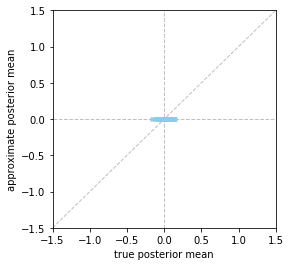

new lr: 0.003125
epoch 12 iteration 11000 loss 30.003 CE 30.003 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 12 iteration 11100 loss 30.205 CE 30.205 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 12 iteration 11200 loss 28.934 CE 28.934 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 12 iteration 11300 loss 30.746 CE 30.746 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 12 iteration 11400 loss 26.848 CE 26.848 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 12 iteration 11500 loss 29.216 CE 29.216 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 12 iteration 11600 loss 29.947 CE 29.947 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 12 iteration 11700 loss 23.023 CE 23.022 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 12 iteration 11800 loss 33.313 CE 33.313 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 12 iteration 11900 loss 26.185 CE 26.185 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [12/30], Training Loss: 29.0700,  Training KL: 0.0000, Training Perplexity: 25.28, Validation Los

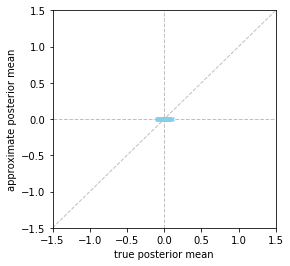

epoch 13 iteration 12000 loss 30.463 CE 30.463 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 13 iteration 12100 loss 30.145 CE 30.145 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 13 iteration 12200 loss 27.891 CE 27.891 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 13 iteration 12300 loss 26.156 CE 26.156 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 13 iteration 12400 loss 29.025 CE 29.025 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 13 iteration 12500 loss 29.280 CE 29.280 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 13 iteration 12600 loss 27.323 CE 27.323 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 13 iteration 12700 loss 28.649 CE 28.649 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 13 iteration 12800 loss 28.852 CE 28.852 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 13 iteration 12900 loss 29.195 CE 29.195 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [13/30], Training Loss: 29.0152,  Training KL: 0.0001, Training Perplexity: 25.13, Validation Loss: 39.9540, KL 0.

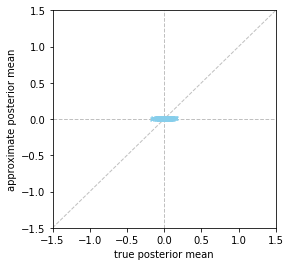

new lr: 0.001563


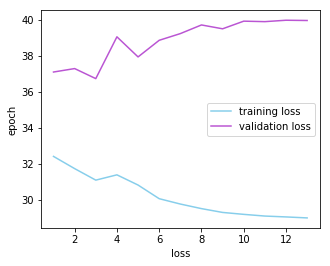

In [68]:
# without annealing
vocab_size = 1000
hidden_size = 50
embedding_size = 50
latent_size = 1
num_layers = 1
step = 0.25
learning_rate = 0.05
epochs = 30
max_sentence_length = 10

embedding_weights = nn.Embedding(vocab_size, embedding_size).weight
vae_basic = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

return_dict_basic = train(vae_basic, inputs, targets, val_inputs, val_inputs, epochs, vocab_size, hidden_size, 
                          latent_size, max_sentence_length, synthetic=True, learning_rate=learning_rate,
                          step=step, tracked_inputs=tracked_inputs, tracked_targets=tracked_targets, 
                          plot_lim=1.5, verbose=True, plot=True, plot_dir="plots_basic")

plot_losses(return_dict_basic['total_epoch_losses'], return_dict_basic['val_total_epoch_losses'])

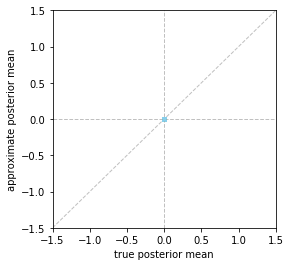

epoch 1 iteration 0 loss 62.162 CE 62.162 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 100 loss 44.022 CE 44.022 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 200 loss 45.108 CE 45.108 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 300 loss 40.450 CE 40.447 KL 0.003 weighted KL: 0.003 weight 1.000
epoch 1 iteration 400 loss 38.277 CE 38.264 KL 0.014 weighted KL: 0.014 weight 1.000
epoch 1 iteration 500 loss 35.699 CE 35.658 KL 0.040 weighted KL: 0.040 weight 1.000
epoch 1 iteration 600 loss 39.347 CE 39.263 KL 0.084 weighted KL: 0.084 weight 1.000
epoch 1 iteration 700 loss 36.111 CE 35.911 KL 0.200 weighted KL: 0.200 weight 1.000
epoch 1 iteration 800 loss 34.030 CE 33.573 KL 0.457 weighted KL: 0.457 weight 1.000
epoch 1 iteration 900 loss 36.927 CE 36.596 KL 0.331 weighted KL: 0.331 weight 1.000
Epoch [1/30], Training Loss: 34.2553,  Training KL: 0.4138, Training Perplexity: 44.98, Validation Loss: 38.7225, KL 0.4249, Val Perplexity: 73.88



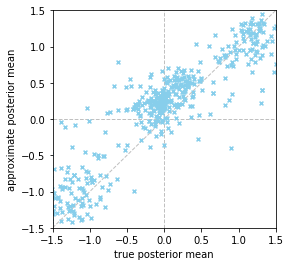

epoch 2 iteration 1000 loss 35.401 CE 35.100 KL 0.301 weighted KL: 0.301 weight 1.000
epoch 2 iteration 1100 loss 32.375 CE 31.880 KL 0.494 weighted KL: 0.494 weight 1.000
epoch 2 iteration 1200 loss 33.671 CE 33.205 KL 0.466 weighted KL: 0.466 weight 1.000
epoch 2 iteration 1300 loss 34.916 CE 34.483 KL 0.432 weighted KL: 0.432 weight 1.000
epoch 2 iteration 1400 loss 34.087 CE 33.497 KL 0.590 weighted KL: 0.590 weight 1.000
epoch 2 iteration 1500 loss 34.635 CE 33.996 KL 0.639 weighted KL: 0.639 weight 1.000
epoch 2 iteration 1600 loss 36.185 CE 35.642 KL 0.543 weighted KL: 0.543 weight 1.000
epoch 2 iteration 1700 loss 44.133 CE 43.548 KL 0.585 weighted KL: 0.585 weight 1.000
epoch 2 iteration 1800 loss 37.117 CE 36.561 KL 0.556 weighted KL: 0.556 weight 1.000
epoch 2 iteration 1900 loss 31.439 CE 30.787 KL 0.653 weighted KL: 0.653 weight 1.000
Epoch [2/30], Training Loss: 32.3301,  Training KL: 0.7738, Training Perplexity: 36.31, Validation Loss: 38.1322, KL 0.7912, Val Perplexity:

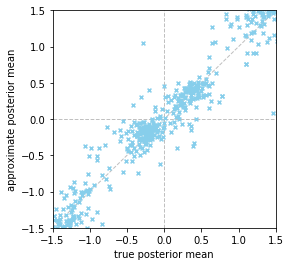

epoch 3 iteration 2000 loss 37.013 CE 36.278 KL 0.735 weighted KL: 0.735 weight 1.000
epoch 3 iteration 2100 loss 33.904 CE 33.149 KL 0.755 weighted KL: 0.755 weight 1.000
epoch 3 iteration 2200 loss 30.521 CE 29.751 KL 0.770 weighted KL: 0.770 weight 1.000
epoch 3 iteration 2300 loss 27.955 CE 27.084 KL 0.870 weighted KL: 0.870 weight 1.000
epoch 3 iteration 2400 loss 29.851 CE 29.133 KL 0.719 weighted KL: 0.719 weight 1.000
epoch 3 iteration 2500 loss 33.814 CE 33.034 KL 0.780 weighted KL: 0.780 weight 1.000
epoch 3 iteration 2600 loss 31.086 CE 30.229 KL 0.856 weighted KL: 0.856 weight 1.000
epoch 3 iteration 2700 loss 30.110 CE 29.353 KL 0.756 weighted KL: 0.756 weight 1.000
epoch 3 iteration 2800 loss 30.507 CE 29.720 KL 0.787 weighted KL: 0.787 weight 1.000
epoch 3 iteration 2900 loss 33.680 CE 32.872 KL 0.808 weighted KL: 0.808 weight 1.000
Epoch [3/30], Training Loss: 31.4282,  Training KL: 0.8369, Training Perplexity: 32.85, Validation Loss: 37.9648, KL 0.8463, Val Perplexity:

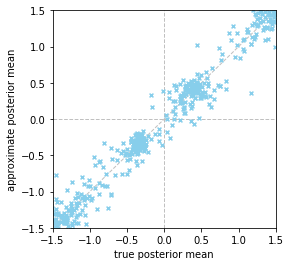

epoch 4 iteration 3000 loss 33.047 CE 32.127 KL 0.920 weighted KL: 0.920 weight 1.000
epoch 4 iteration 3100 loss 31.628 CE 30.738 KL 0.890 weighted KL: 0.890 weight 1.000
epoch 4 iteration 3200 loss 35.076 CE 34.156 KL 0.919 weighted KL: 0.919 weight 1.000
epoch 4 iteration 3300 loss 29.092 CE 28.254 KL 0.838 weighted KL: 0.838 weight 1.000
epoch 4 iteration 3400 loss 30.999 CE 30.003 KL 0.996 weighted KL: 0.996 weight 1.000
epoch 4 iteration 3500 loss 35.109 CE 34.224 KL 0.885 weighted KL: 0.885 weight 1.000
epoch 4 iteration 3600 loss 28.747 CE 27.966 KL 0.781 weighted KL: 0.781 weight 1.000
epoch 4 iteration 3700 loss 30.705 CE 29.725 KL 0.980 weighted KL: 0.980 weight 1.000
epoch 4 iteration 3800 loss 32.151 CE 31.398 KL 0.753 weighted KL: 0.753 weight 1.000
epoch 4 iteration 3900 loss 33.941 CE 33.221 KL 0.719 weighted KL: 0.719 weight 1.000
Epoch [4/30], Training Loss: 30.8893,  Training KL: 0.8438, Training Perplexity: 30.94, Validation Loss: 37.8443, KL 0.8523, Val Perplexity:

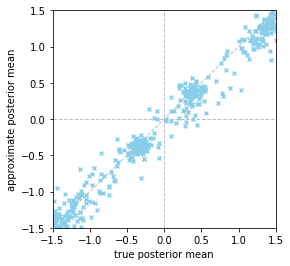

epoch 5 iteration 4000 loss 28.947 CE 28.202 KL 0.745 weighted KL: 0.745 weight 1.000
epoch 5 iteration 4100 loss 26.816 CE 25.953 KL 0.863 weighted KL: 0.863 weight 1.000
epoch 5 iteration 4200 loss 32.900 CE 32.096 KL 0.804 weighted KL: 0.804 weight 1.000
epoch 5 iteration 4300 loss 29.802 CE 28.887 KL 0.915 weighted KL: 0.915 weight 1.000
epoch 5 iteration 4400 loss 34.852 CE 34.045 KL 0.807 weighted KL: 0.807 weight 1.000
epoch 5 iteration 4500 loss 26.626 CE 25.755 KL 0.871 weighted KL: 0.871 weight 1.000
epoch 5 iteration 4600 loss 30.914 CE 30.017 KL 0.897 weighted KL: 0.897 weight 1.000
epoch 5 iteration 4700 loss 29.585 CE 28.770 KL 0.815 weighted KL: 0.815 weight 1.000
epoch 5 iteration 4800 loss 30.224 CE 29.346 KL 0.878 weighted KL: 0.878 weight 1.000
epoch 5 iteration 4900 loss 32.808 CE 31.879 KL 0.930 weighted KL: 0.930 weight 1.000
Epoch [5/30], Training Loss: 30.3989,  Training KL: 0.8366, Training Perplexity: 29.30, Validation Loss: 38.2242, KL 0.8439, Val Perplexity:

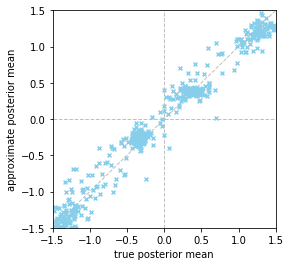

epoch 6 iteration 5000 loss 29.410 CE 28.546 KL 0.864 weighted KL: 0.864 weight 1.000
epoch 6 iteration 5100 loss 34.013 CE 33.201 KL 0.812 weighted KL: 0.812 weight 1.000
epoch 6 iteration 5200 loss 36.047 CE 35.238 KL 0.808 weighted KL: 0.808 weight 1.000
epoch 6 iteration 5300 loss 29.867 CE 29.041 KL 0.827 weighted KL: 0.827 weight 1.000
epoch 6 iteration 5400 loss 28.942 CE 28.158 KL 0.784 weighted KL: 0.784 weight 1.000
epoch 6 iteration 5500 loss 32.383 CE 31.570 KL 0.813 weighted KL: 0.813 weight 1.000
epoch 6 iteration 5600 loss 34.647 CE 33.832 KL 0.815 weighted KL: 0.815 weight 1.000
epoch 6 iteration 5700 loss 29.962 CE 29.121 KL 0.841 weighted KL: 0.841 weight 1.000
epoch 6 iteration 5800 loss 28.635 CE 27.722 KL 0.913 weighted KL: 0.913 weight 1.000
epoch 6 iteration 5900 loss 26.294 CE 25.424 KL 0.870 weighted KL: 0.870 weight 1.000
Epoch [6/30], Training Loss: 30.0734,  Training KL: 0.7940, Training Perplexity: 28.26, Validation Loss: 38.2763, KL 0.8028, Val Perplexity:

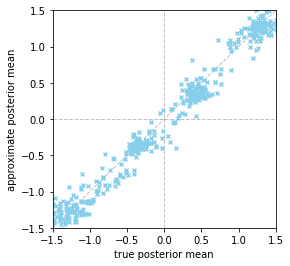

new lr: 0.005000
epoch 7 iteration 6000 loss 35.334 CE 34.634 KL 0.699 weighted KL: 0.699 weight 1.000
epoch 7 iteration 6100 loss 28.985 CE 28.240 KL 0.745 weighted KL: 0.745 weight 1.000
epoch 7 iteration 6200 loss 29.080 CE 28.327 KL 0.753 weighted KL: 0.753 weight 1.000
epoch 7 iteration 6300 loss 31.994 CE 31.233 KL 0.761 weighted KL: 0.761 weight 1.000
epoch 7 iteration 6400 loss 27.114 CE 26.341 KL 0.774 weighted KL: 0.774 weight 1.000
epoch 7 iteration 6500 loss 28.175 CE 27.335 KL 0.840 weighted KL: 0.840 weight 1.000
epoch 7 iteration 6600 loss 29.057 CE 28.232 KL 0.825 weighted KL: 0.825 weight 1.000
epoch 7 iteration 6700 loss 30.960 CE 30.183 KL 0.776 weighted KL: 0.776 weight 1.000
epoch 7 iteration 6800 loss 31.203 CE 30.348 KL 0.856 weighted KL: 0.856 weight 1.000
epoch 7 iteration 6900 loss 27.132 CE 26.348 KL 0.784 weighted KL: 0.784 weight 1.000
Epoch [7/30], Training Loss: 29.7487,  Training KL: 0.8421, Training Perplexity: 27.26, Validation Loss: 38.3988, KL 0.8525

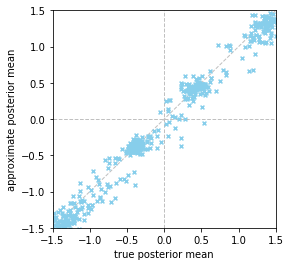

epoch 8 iteration 7000 loss 28.299 CE 27.418 KL 0.881 weighted KL: 0.881 weight 1.000
epoch 8 iteration 7100 loss 28.139 CE 27.374 KL 0.765 weighted KL: 0.765 weight 1.000
epoch 8 iteration 7200 loss 33.172 CE 32.337 KL 0.835 weighted KL: 0.835 weight 1.000
epoch 8 iteration 7300 loss 27.062 CE 26.246 KL 0.816 weighted KL: 0.816 weight 1.000
epoch 8 iteration 7400 loss 32.781 CE 32.073 KL 0.708 weighted KL: 0.708 weight 1.000
epoch 8 iteration 7500 loss 27.634 CE 26.734 KL 0.900 weighted KL: 0.900 weight 1.000
epoch 8 iteration 7600 loss 27.136 CE 26.344 KL 0.791 weighted KL: 0.791 weight 1.000
epoch 8 iteration 7700 loss 32.933 CE 32.094 KL 0.839 weighted KL: 0.839 weight 1.000
epoch 8 iteration 7800 loss 34.268 CE 33.517 KL 0.751 weighted KL: 0.751 weight 1.000
epoch 8 iteration 7900 loss 30.144 CE 29.257 KL 0.887 weighted KL: 0.887 weight 1.000
Epoch [8/30], Training Loss: 29.5375,  Training KL: 0.8476, Training Perplexity: 26.63, Validation Loss: 38.7883, KL 0.8583, Val Perplexity:

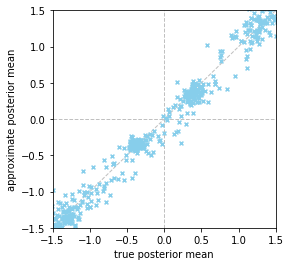

new lr: 0.002500
epoch 9 iteration 8000 loss 35.637 CE 34.778 KL 0.859 weighted KL: 0.859 weight 1.000
epoch 9 iteration 8100 loss 27.333 CE 26.446 KL 0.886 weighted KL: 0.886 weight 1.000
epoch 9 iteration 8200 loss 31.459 CE 30.450 KL 1.009 weighted KL: 1.009 weight 1.000
epoch 9 iteration 8300 loss 32.448 CE 31.575 KL 0.873 weighted KL: 0.873 weight 1.000
epoch 9 iteration 8400 loss 27.531 CE 26.657 KL 0.873 weighted KL: 0.873 weight 1.000
epoch 9 iteration 8500 loss 26.579 CE 25.631 KL 0.948 weighted KL: 0.948 weight 1.000
epoch 9 iteration 8600 loss 27.806 CE 27.020 KL 0.786 weighted KL: 0.786 weight 1.000
epoch 9 iteration 8700 loss 25.154 CE 24.405 KL 0.749 weighted KL: 0.749 weight 1.000
epoch 9 iteration 8800 loss 29.825 CE 29.036 KL 0.790 weighted KL: 0.790 weight 1.000
epoch 9 iteration 8900 loss 29.262 CE 28.415 KL 0.848 weighted KL: 0.848 weight 1.000
Epoch [9/30], Training Loss: 29.4365,  Training KL: 0.8382, Training Perplexity: 26.33, Validation Loss: 38.8652, KL 0.8483

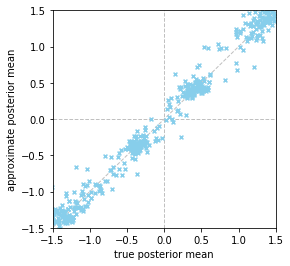

epoch 10 iteration 9000 loss 28.804 CE 27.986 KL 0.818 weighted KL: 0.818 weight 1.000
epoch 10 iteration 9100 loss 30.026 CE 29.247 KL 0.779 weighted KL: 0.779 weight 1.000
epoch 10 iteration 9200 loss 30.434 CE 29.628 KL 0.806 weighted KL: 0.806 weight 1.000
epoch 10 iteration 9300 loss 28.179 CE 27.379 KL 0.800 weighted KL: 0.800 weight 1.000
epoch 10 iteration 9400 loss 32.189 CE 31.339 KL 0.849 weighted KL: 0.849 weight 1.000
epoch 10 iteration 9500 loss 29.313 CE 28.419 KL 0.894 weighted KL: 0.894 weight 1.000
epoch 10 iteration 9600 loss 30.515 CE 29.674 KL 0.842 weighted KL: 0.842 weight 1.000
epoch 10 iteration 9700 loss 22.572 CE 21.563 KL 1.009 weighted KL: 1.009 weight 1.000
epoch 10 iteration 9800 loss 32.969 CE 32.136 KL 0.834 weighted KL: 0.834 weight 1.000
epoch 10 iteration 9900 loss 29.258 CE 28.352 KL 0.906 weighted KL: 0.906 weight 1.000
Epoch [10/30], Training Loss: 29.3087,  Training KL: 0.8589, Training Perplexity: 25.96, Validation Loss: 39.1176, KL 0.8689, Val 

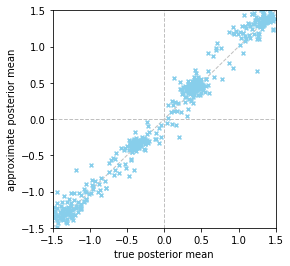

new lr: 0.001250
epoch 11 iteration 10000 loss 26.830 CE 25.986 KL 0.844 weighted KL: 0.844 weight 1.000
epoch 11 iteration 10100 loss 31.590 CE 30.750 KL 0.841 weighted KL: 0.841 weight 1.000
epoch 11 iteration 10200 loss 31.230 CE 30.328 KL 0.902 weighted KL: 0.902 weight 1.000
epoch 11 iteration 10300 loss 31.154 CE 30.317 KL 0.837 weighted KL: 0.837 weight 1.000
epoch 11 iteration 10400 loss 28.923 CE 28.095 KL 0.828 weighted KL: 0.828 weight 1.000
epoch 11 iteration 10500 loss 30.761 CE 29.975 KL 0.786 weighted KL: 0.786 weight 1.000
epoch 11 iteration 10600 loss 32.161 CE 31.346 KL 0.815 weighted KL: 0.815 weight 1.000
epoch 11 iteration 10700 loss 27.697 CE 26.868 KL 0.828 weighted KL: 0.828 weight 1.000
epoch 11 iteration 10800 loss 31.948 CE 31.207 KL 0.741 weighted KL: 0.741 weight 1.000
epoch 11 iteration 10900 loss 27.757 CE 26.846 KL 0.911 weighted KL: 0.911 weight 1.000
Epoch [11/30], Training Loss: 29.2681,  Training KL: 0.8579, Training Perplexity: 25.84, Validation Los

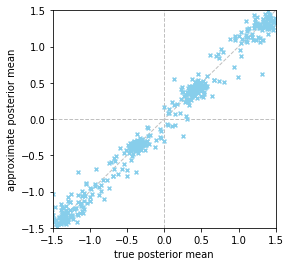

epoch 12 iteration 11000 loss 28.939 CE 28.113 KL 0.826 weighted KL: 0.826 weight 1.000
epoch 12 iteration 11100 loss 31.747 CE 30.844 KL 0.904 weighted KL: 0.904 weight 1.000
epoch 12 iteration 11200 loss 28.043 CE 27.246 KL 0.796 weighted KL: 0.796 weight 1.000
epoch 12 iteration 11300 loss 27.954 CE 27.093 KL 0.861 weighted KL: 0.861 weight 1.000
epoch 12 iteration 11400 loss 28.571 CE 27.730 KL 0.841 weighted KL: 0.841 weight 1.000
epoch 12 iteration 11500 loss 26.793 CE 25.912 KL 0.881 weighted KL: 0.881 weight 1.000
epoch 12 iteration 11600 loss 30.396 CE 29.586 KL 0.811 weighted KL: 0.811 weight 1.000
epoch 12 iteration 11700 loss 30.563 CE 29.641 KL 0.922 weighted KL: 0.922 weight 1.000
epoch 12 iteration 11800 loss 29.406 CE 28.624 KL 0.781 weighted KL: 0.781 weight 1.000
epoch 12 iteration 11900 loss 28.843 CE 28.015 KL 0.828 weighted KL: 0.828 weight 1.000
Epoch [12/30], Training Loss: 29.2335,  Training KL: 0.8386, Training Perplexity: 25.74, Validation Loss: 39.1498, KL 0.

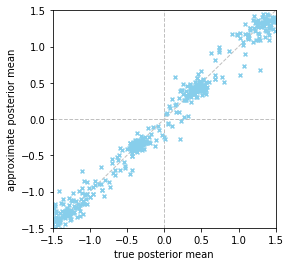

epoch 13 iteration 12000 loss 29.582 CE 28.714 KL 0.868 weighted KL: 0.868 weight 1.000
epoch 13 iteration 12100 loss 34.776 CE 33.926 KL 0.850 weighted KL: 0.850 weight 1.000
epoch 13 iteration 12200 loss 27.984 CE 27.084 KL 0.900 weighted KL: 0.900 weight 1.000
epoch 13 iteration 12300 loss 30.710 CE 29.842 KL 0.869 weighted KL: 0.869 weight 1.000
epoch 13 iteration 12400 loss 28.124 CE 27.298 KL 0.826 weighted KL: 0.826 weight 1.000
epoch 13 iteration 12500 loss 29.548 CE 28.550 KL 0.998 weighted KL: 0.998 weight 1.000
epoch 13 iteration 12600 loss 27.975 CE 27.149 KL 0.825 weighted KL: 0.825 weight 1.000
epoch 13 iteration 12700 loss 29.804 CE 28.977 KL 0.827 weighted KL: 0.827 weight 1.000
epoch 13 iteration 12800 loss 26.899 CE 26.106 KL 0.793 weighted KL: 0.793 weight 1.000
epoch 13 iteration 12900 loss 27.657 CE 26.773 KL 0.885 weighted KL: 0.885 weight 1.000
Epoch [13/30], Training Loss: 29.1918,  Training KL: 0.8527, Training Perplexity: 25.62, Validation Loss: 39.1410, KL 0.

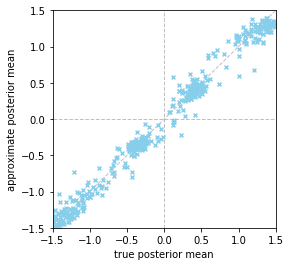

new lr: 0.000625
epoch 14 iteration 13000 loss 29.738 CE 28.936 KL 0.802 weighted KL: 0.802 weight 1.000
epoch 14 iteration 13100 loss 26.967 CE 25.986 KL 0.982 weighted KL: 0.982 weight 1.000
epoch 14 iteration 13200 loss 26.902 CE 26.083 KL 0.819 weighted KL: 0.819 weight 1.000
epoch 14 iteration 13300 loss 28.636 CE 27.816 KL 0.819 weighted KL: 0.819 weight 1.000
epoch 14 iteration 13400 loss 27.177 CE 26.305 KL 0.872 weighted KL: 0.872 weight 1.000
epoch 14 iteration 13500 loss 26.886 CE 25.971 KL 0.915 weighted KL: 0.915 weight 1.000
epoch 14 iteration 13600 loss 30.900 CE 29.974 KL 0.926 weighted KL: 0.926 weight 1.000
epoch 14 iteration 13700 loss 25.590 CE 24.590 KL 1.000 weighted KL: 1.000 weight 1.000
epoch 14 iteration 13800 loss 29.076 CE 28.283 KL 0.793 weighted KL: 0.793 weight 1.000
epoch 14 iteration 13900 loss 30.842 CE 29.880 KL 0.962 weighted KL: 0.962 weight 1.000
Epoch [14/30], Training Loss: 29.1643,  Training KL: 0.8642, Training Perplexity: 25.55, Validation Los

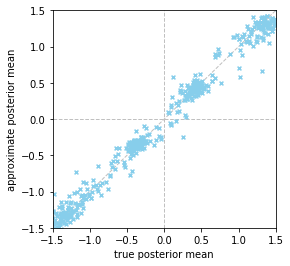

epoch 15 iteration 14000 loss 29.077 CE 28.173 KL 0.904 weighted KL: 0.904 weight 1.000
epoch 15 iteration 14100 loss 25.708 CE 24.767 KL 0.941 weighted KL: 0.941 weight 1.000
epoch 15 iteration 14200 loss 28.160 CE 27.323 KL 0.838 weighted KL: 0.838 weight 1.000
epoch 15 iteration 14300 loss 27.533 CE 26.520 KL 1.013 weighted KL: 1.013 weight 1.000
epoch 15 iteration 14400 loss 28.080 CE 27.100 KL 0.980 weighted KL: 0.980 weight 1.000
epoch 15 iteration 14500 loss 24.143 CE 23.353 KL 0.790 weighted KL: 0.790 weight 1.000
epoch 15 iteration 14600 loss 27.619 CE 26.726 KL 0.893 weighted KL: 0.893 weight 1.000
epoch 15 iteration 14700 loss 29.603 CE 28.697 KL 0.906 weighted KL: 0.906 weight 1.000
epoch 15 iteration 14800 loss 29.789 CE 28.976 KL 0.813 weighted KL: 0.813 weight 1.000
epoch 15 iteration 14900 loss 25.840 CE 24.807 KL 1.033 weighted KL: 1.033 weight 1.000
Epoch [15/30], Training Loss: 29.1387,  Training KL: 0.8694, Training Perplexity: 25.47, Validation Loss: 39.3440, KL 0.

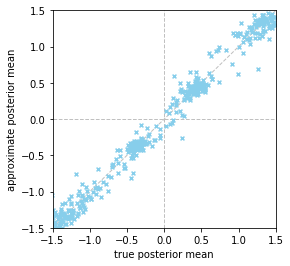

new lr: 0.000313


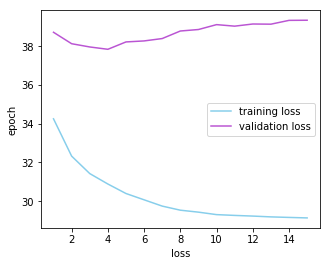

In [61]:
# without annealing
vocab_size = 1000
hidden_size = 50
embedding_size = 50
latent_size = 1
num_layers = 1
step = 0.25
learning_rate = 0.01
epochs = 30
max_sentence_length = 10

embedding_weights = nn.Embedding(vocab_size, embedding_size).weight
vae_basic_new = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

return_dict_basic_new = train(vae_basic_new, inputs, targets, val_inputs, val_inputs, epochs, vocab_size, hidden_size, 
                          latent_size, max_sentence_length, synthetic=True, learning_rate=learning_rate,
                          step=step, tracked_inputs=tracked_inputs, tracked_targets=tracked_targets, 
                          plot_lim=1.5, verbose=True, plot=True, plot_dir="plots_basic_new")

plot_losses(return_dict_basic_new['total_epoch_losses'], return_dict_basic_new['val_total_epoch_losses'])

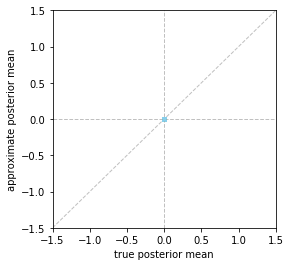

epoch 1 iteration 0 loss 62.167 CE 62.167 KL 0.000 weighted KL: 0.000 weight 0.002
epoch 1 iteration 100 loss 38.183 CE 38.176 KL 2.538 weighted KL: 0.006 weight 0.002
epoch 1 iteration 200 loss 33.639 CE 33.629 KL 3.204 weighted KL: 0.010 weight 0.003
epoch 1 iteration 300 loss 35.390 CE 35.372 KL 4.183 weighted KL: 0.017 weight 0.004
epoch 1 iteration 400 loss 37.693 CE 37.673 KL 3.747 weighted KL: 0.020 weight 0.005
epoch 1 iteration 500 loss 33.559 CE 33.535 KL 3.591 weighted KL: 0.024 weight 0.007
epoch 1 iteration 600 loss 35.537 CE 35.499 KL 4.341 weighted KL: 0.037 weight 0.009
epoch 1 iteration 700 loss 35.572 CE 35.529 KL 3.861 weighted KL: 0.042 weight 0.011
epoch 1 iteration 800 loss 32.600 CE 32.546 KL 3.809 weighted KL: 0.054 weight 0.014
epoch 1 iteration 900 loss 33.997 CE 33.929 KL 3.780 weighted KL: 0.068 weight 0.018
Epoch [1/30], Training Loss: 31.1561,  Training KL: 0.0813, Training Perplexity: 31.87, Validation Loss: 31.9000, KL 0.0815, Val Perplexity: 34.62



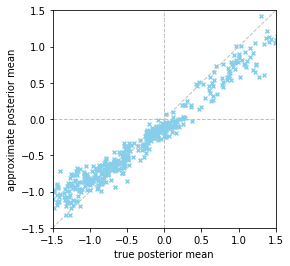

epoch 2 iteration 1000 loss 31.845 CE 31.765 KL 3.481 weighted KL: 0.080 weight 0.023
epoch 2 iteration 1100 loss 31.434 CE 31.332 KL 3.492 weighted KL: 0.102 weight 0.029
epoch 2 iteration 1200 loss 30.366 CE 30.223 KL 3.820 weighted KL: 0.143 weight 0.037
epoch 2 iteration 1300 loss 27.676 CE 27.509 KL 3.513 weighted KL: 0.167 weight 0.047
epoch 2 iteration 1400 loss 35.790 CE 35.601 KL 3.146 weighted KL: 0.189 weight 0.060
epoch 2 iteration 1500 loss 27.485 CE 27.220 KL 3.499 weighted KL: 0.265 weight 0.076
epoch 2 iteration 1600 loss 31.769 CE 31.497 KL 2.860 weighted KL: 0.273 weight 0.095
epoch 2 iteration 1700 loss 28.966 CE 28.590 KL 3.160 weighted KL: 0.377 weight 0.119
epoch 2 iteration 1800 loss 32.268 CE 31.867 KL 2.710 weighted KL: 0.401 weight 0.148
epoch 2 iteration 1900 loss 27.226 CE 26.778 KL 2.457 weighted KL: 0.448 weight 0.182
Epoch [2/30], Training Loss: 30.6656,  Training KL: 0.5350, Training Perplexity: 30.18, Validation Loss: 31.7037, KL 0.5372, Val Perplexity:

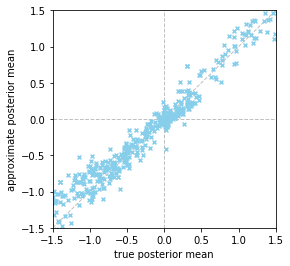

epoch 3 iteration 2000 loss 30.929 CE 30.417 KL 2.296 weighted KL: 0.511 weight 0.223
epoch 3 iteration 2100 loss 34.061 CE 33.371 KL 2.565 weighted KL: 0.690 weight 0.269
epoch 3 iteration 2200 loss 31.145 CE 30.383 KL 2.375 weighted KL: 0.762 weight 0.321
epoch 3 iteration 2300 loss 35.929 CE 35.133 KL 2.109 weighted KL: 0.796 weight 0.378
epoch 3 iteration 2400 loss 34.353 CE 33.517 KL 1.910 weighted KL: 0.836 weight 0.438
epoch 3 iteration 2500 loss 36.765 CE 35.889 KL 1.751 weighted KL: 0.876 weight 0.500
epoch 3 iteration 2600 loss 34.280 CE 33.393 KL 1.577 weighted KL: 0.886 weight 0.562
epoch 3 iteration 2700 loss 31.507 CE 30.388 KL 1.797 weighted KL: 1.118 weight 0.622
epoch 3 iteration 2800 loss 31.234 CE 30.203 KL 1.518 weighted KL: 1.031 weight 0.679
epoch 3 iteration 2900 loss 34.090 CE 32.879 KL 1.656 weighted KL: 1.211 weight 0.731
Epoch [3/30], Training Loss: 31.1861,  Training KL: 1.1874, Training Perplexity: 31.98, Validation Loss: 32.5224, KL 1.1917, Val Perplexity:

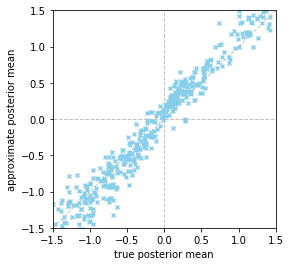

epoch 4 iteration 3000 loss 35.045 CE 33.973 KL 1.379 weighted KL: 1.072 weight 0.777
epoch 4 iteration 3100 loss 30.154 CE 28.881 KL 1.557 weighted KL: 1.273 weight 0.818
epoch 4 iteration 3200 loss 29.979 CE 28.481 KL 1.759 weighted KL: 1.498 weight 0.852
epoch 4 iteration 3300 loss 32.848 CE 31.524 KL 1.502 weighted KL: 1.323 weight 0.881
epoch 4 iteration 3400 loss 29.779 CE 28.492 KL 1.423 weighted KL: 1.287 weight 0.905
epoch 4 iteration 3500 loss 29.817 CE 28.502 KL 1.423 weighted KL: 1.315 weight 0.924
epoch 4 iteration 3600 loss 29.821 CE 28.581 KL 1.318 weighted KL: 1.239 weight 0.940
epoch 4 iteration 3700 loss 32.811 CE 31.588 KL 1.284 weighted KL: 1.223 weight 0.953
epoch 4 iteration 3800 loss 32.343 CE 31.132 KL 1.259 weighted KL: 1.212 weight 0.963
epoch 4 iteration 3900 loss 30.741 CE 29.423 KL 1.359 weighted KL: 1.319 weight 0.971
Epoch [4/30], Training Loss: 31.1966,  Training KL: 1.3015, Training Perplexity: 32.02, Validation Loss: 32.7893, KL 1.3023, Val Perplexity:

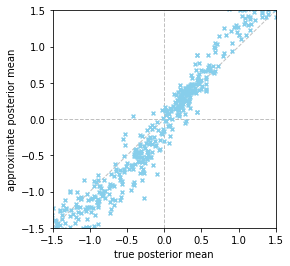

new lr: 0.025000
epoch 5 iteration 4000 loss 27.217 CE 25.712 KL 1.540 weighted KL: 1.504 weight 0.977
epoch 5 iteration 4100 loss 33.584 CE 32.416 KL 1.190 weighted KL: 1.168 weight 0.982
epoch 5 iteration 4200 loss 34.600 CE 33.482 KL 1.134 weighted KL: 1.118 weight 0.986
epoch 5 iteration 4300 loss 26.960 CE 25.683 KL 1.292 weighted KL: 1.278 weight 0.989
epoch 5 iteration 4400 loss 33.482 CE 32.323 KL 1.169 weighted KL: 1.159 weight 0.991
epoch 5 iteration 4500 loss 33.795 CE 32.847 KL 0.954 weighted KL: 0.947 weight 0.993
epoch 5 iteration 4600 loss 29.315 CE 28.079 KL 1.243 weighted KL: 1.237 weight 0.995
epoch 5 iteration 4700 loss 33.469 CE 32.382 KL 1.092 weighted KL: 1.087 weight 0.996
epoch 5 iteration 4800 loss 31.028 CE 29.935 KL 1.096 weighted KL: 1.093 weight 0.997
epoch 5 iteration 4900 loss 28.881 CE 27.751 KL 1.132 weighted KL: 1.129 weight 0.998
Epoch [5/30], Training Loss: 30.4146,  Training KL: 1.0564, Training Perplexity: 29.35, Validation Loss: 32.2595, KL 1.0580

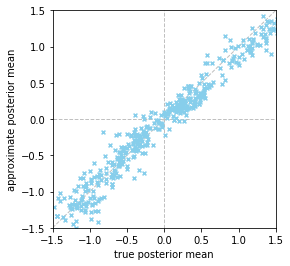

epoch 6 iteration 5000 loss 32.812 CE 31.773 KL 1.041 weighted KL: 1.039 weight 0.998
epoch 6 iteration 5100 loss 31.633 CE 30.621 KL 1.014 weighted KL: 1.012 weight 0.998
epoch 6 iteration 5200 loss 28.193 CE 27.020 KL 1.174 weighted KL: 1.173 weight 0.999
epoch 6 iteration 5300 loss 29.467 CE 28.224 KL 1.245 weighted KL: 1.243 weight 0.999
epoch 6 iteration 5400 loss 30.173 CE 29.042 KL 1.132 weighted KL: 1.131 weight 0.999
epoch 6 iteration 5500 loss 31.733 CE 30.755 KL 0.978 weighted KL: 0.978 weight 0.999
epoch 6 iteration 5600 loss 28.835 CE 27.706 KL 1.130 weighted KL: 1.130 weight 1.000
epoch 6 iteration 5700 loss 30.804 CE 29.747 KL 1.057 weighted KL: 1.056 weight 1.000
epoch 6 iteration 5800 loss 35.859 CE 34.621 KL 1.238 weighted KL: 1.237 weight 1.000
epoch 6 iteration 5900 loss 30.529 CE 29.424 KL 1.106 weighted KL: 1.105 weight 1.000
Epoch [6/30], Training Loss: 30.0621,  Training KL: 1.1103, Training Perplexity: 28.23, Validation Loss: 32.2400, KL 1.1114, Val Perplexity:

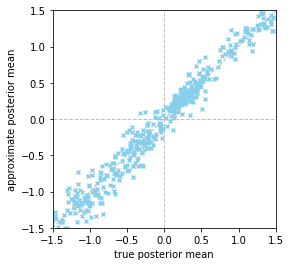

epoch 7 iteration 6000 loss 29.388 CE 28.439 KL 0.950 weighted KL: 0.949 weight 1.000
epoch 7 iteration 6100 loss 31.489 CE 30.473 KL 1.016 weighted KL: 1.016 weight 1.000
epoch 7 iteration 6200 loss 35.059 CE 33.899 KL 1.160 weighted KL: 1.160 weight 1.000
epoch 7 iteration 6300 loss 31.665 CE 30.570 KL 1.095 weighted KL: 1.095 weight 1.000
epoch 7 iteration 6400 loss 27.974 CE 26.838 KL 1.136 weighted KL: 1.135 weight 1.000
epoch 7 iteration 6500 loss 30.548 CE 29.562 KL 0.985 weighted KL: 0.985 weight 1.000
epoch 7 iteration 6600 loss 28.342 CE 27.221 KL 1.122 weighted KL: 1.122 weight 1.000
epoch 7 iteration 6700 loss 28.388 CE 27.136 KL 1.252 weighted KL: 1.252 weight 1.000
epoch 7 iteration 6800 loss 29.226 CE 28.277 KL 0.949 weighted KL: 0.949 weight 1.000
epoch 7 iteration 6900 loss 27.896 CE 26.803 KL 1.093 weighted KL: 1.093 weight 1.000
Epoch [7/30], Training Loss: 29.9130,  Training KL: 1.0197, Training Perplexity: 27.76, Validation Loss: 32.3020, KL 1.0206, Val Perplexity:

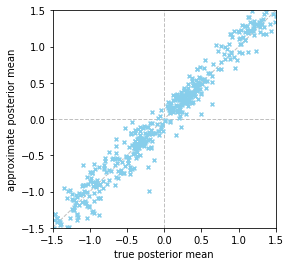

epoch 8 iteration 7000 loss 32.632 CE 31.608 KL 1.024 weighted KL: 1.024 weight 1.000
epoch 8 iteration 7100 loss 31.057 CE 29.948 KL 1.109 weighted KL: 1.109 weight 1.000
epoch 8 iteration 7200 loss 31.637 CE 30.461 KL 1.175 weighted KL: 1.175 weight 1.000
epoch 8 iteration 7300 loss 29.823 CE 28.919 KL 0.904 weighted KL: 0.904 weight 1.000
epoch 8 iteration 7400 loss 26.328 CE 25.403 KL 0.925 weighted KL: 0.925 weight 1.000
epoch 8 iteration 7500 loss 29.072 CE 27.916 KL 1.157 weighted KL: 1.157 weight 1.000
epoch 8 iteration 7600 loss 33.098 CE 32.028 KL 1.070 weighted KL: 1.070 weight 1.000
epoch 8 iteration 7700 loss 30.746 CE 29.806 KL 0.941 weighted KL: 0.941 weight 1.000
epoch 8 iteration 7800 loss 28.088 CE 27.052 KL 1.036 weighted KL: 1.036 weight 1.000
epoch 8 iteration 7900 loss 31.462 CE 30.320 KL 1.142 weighted KL: 1.142 weight 1.000
Epoch [8/30], Training Loss: 29.8573,  Training KL: 0.9190, Training Perplexity: 27.59, Validation Loss: 32.4851, KL 0.9157, Val Perplexity:

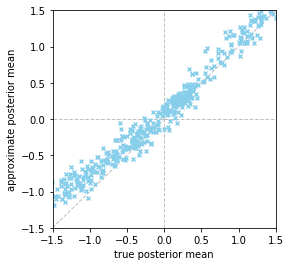

new lr: 0.012500
epoch 9 iteration 8000 loss 28.748 CE 27.789 KL 0.959 weighted KL: 0.959 weight 1.000
epoch 9 iteration 8100 loss 28.070 CE 27.085 KL 0.984 weighted KL: 0.984 weight 1.000
epoch 9 iteration 8200 loss 29.783 CE 28.499 KL 1.284 weighted KL: 1.284 weight 1.000
epoch 9 iteration 8300 loss 29.429 CE 28.384 KL 1.045 weighted KL: 1.045 weight 1.000
epoch 9 iteration 8400 loss 28.410 CE 27.528 KL 0.882 weighted KL: 0.882 weight 1.000
epoch 9 iteration 8500 loss 28.696 CE 27.584 KL 1.112 weighted KL: 1.112 weight 1.000
epoch 9 iteration 8600 loss 30.846 CE 29.788 KL 1.058 weighted KL: 1.058 weight 1.000
epoch 9 iteration 8700 loss 30.697 CE 29.734 KL 0.963 weighted KL: 0.963 weight 1.000
epoch 9 iteration 8800 loss 32.818 CE 31.771 KL 1.047 weighted KL: 1.047 weight 1.000
epoch 9 iteration 8900 loss 31.768 CE 30.742 KL 1.026 weighted KL: 1.026 weight 1.000
Epoch [9/30], Training Loss: 29.4029,  Training KL: 1.0267, Training Perplexity: 26.23, Validation Loss: 32.2208, KL 1.0244

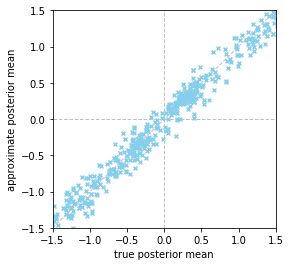

epoch 10 iteration 9000 loss 32.226 CE 31.050 KL 1.177 weighted KL: 1.177 weight 1.000
epoch 10 iteration 9100 loss 30.173 CE 29.226 KL 0.947 weighted KL: 0.947 weight 1.000
epoch 10 iteration 9200 loss 29.425 CE 28.364 KL 1.061 weighted KL: 1.061 weight 1.000
epoch 10 iteration 9300 loss 31.452 CE 30.429 KL 1.024 weighted KL: 1.024 weight 1.000
epoch 10 iteration 9400 loss 27.120 CE 26.048 KL 1.072 weighted KL: 1.072 weight 1.000
epoch 10 iteration 9500 loss 31.299 CE 30.145 KL 1.154 weighted KL: 1.154 weight 1.000
epoch 10 iteration 9600 loss 29.548 CE 28.401 KL 1.147 weighted KL: 1.147 weight 1.000
epoch 10 iteration 9700 loss 26.997 CE 25.964 KL 1.033 weighted KL: 1.033 weight 1.000
epoch 10 iteration 9800 loss 28.933 CE 27.903 KL 1.030 weighted KL: 1.030 weight 1.000
epoch 10 iteration 9900 loss 31.563 CE 30.234 KL 1.328 weighted KL: 1.328 weight 1.000
Epoch [10/30], Training Loss: 29.2974,  Training KL: 1.0878, Training Perplexity: 25.93, Validation Loss: 32.2419, KL 1.0868, Val 

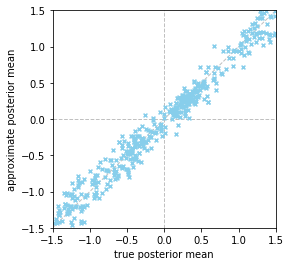

epoch 11 iteration 10000 loss 29.392 CE 28.327 KL 1.065 weighted KL: 1.065 weight 1.000
epoch 11 iteration 10100 loss 28.432 CE 27.444 KL 0.988 weighted KL: 0.988 weight 1.000
epoch 11 iteration 10200 loss 30.120 CE 29.118 KL 1.003 weighted KL: 1.003 weight 1.000
epoch 11 iteration 10300 loss 27.919 CE 26.939 KL 0.980 weighted KL: 0.980 weight 1.000
epoch 11 iteration 10400 loss 32.893 CE 31.745 KL 1.148 weighted KL: 1.148 weight 1.000
epoch 11 iteration 10500 loss 29.562 CE 28.515 KL 1.047 weighted KL: 1.047 weight 1.000
epoch 11 iteration 10600 loss 28.271 CE 27.146 KL 1.125 weighted KL: 1.125 weight 1.000
epoch 11 iteration 10700 loss 27.658 CE 26.604 KL 1.054 weighted KL: 1.054 weight 1.000
epoch 11 iteration 10800 loss 30.768 CE 29.632 KL 1.136 weighted KL: 1.136 weight 1.000
epoch 11 iteration 10900 loss 26.662 CE 25.761 KL 0.901 weighted KL: 0.901 weight 1.000
Epoch [11/30], Training Loss: 29.1834,  Training KL: 1.0769, Training Perplexity: 25.60, Validation Loss: 32.3839, KL 1.

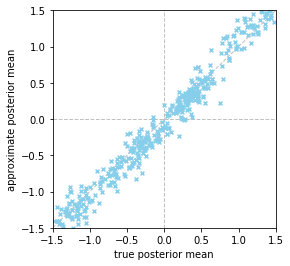

new lr: 0.006250
epoch 12 iteration 11000 loss 29.600 CE 28.595 KL 1.005 weighted KL: 1.005 weight 1.000
epoch 12 iteration 11100 loss 29.135 CE 28.004 KL 1.131 weighted KL: 1.131 weight 1.000
epoch 12 iteration 11200 loss 31.870 CE 30.651 KL 1.219 weighted KL: 1.219 weight 1.000
epoch 12 iteration 11300 loss 33.619 CE 32.614 KL 1.005 weighted KL: 1.005 weight 1.000
epoch 12 iteration 11400 loss 27.410 CE 26.336 KL 1.074 weighted KL: 1.074 weight 1.000
epoch 12 iteration 11500 loss 31.074 CE 29.964 KL 1.110 weighted KL: 1.110 weight 1.000
epoch 12 iteration 11600 loss 33.133 CE 32.019 KL 1.113 weighted KL: 1.113 weight 1.000
epoch 12 iteration 11700 loss 29.930 CE 28.986 KL 0.944 weighted KL: 0.944 weight 1.000
epoch 12 iteration 11800 loss 28.918 CE 27.918 KL 1.000 weighted KL: 1.000 weight 1.000
epoch 12 iteration 11900 loss 34.002 CE 32.903 KL 1.099 weighted KL: 1.099 weight 1.000
Epoch [12/30], Training Loss: 29.0484,  Training KL: 1.1084, Training Perplexity: 25.22, Validation Los

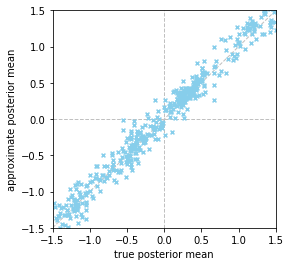

epoch 13 iteration 12000 loss 33.268 CE 32.286 KL 0.982 weighted KL: 0.982 weight 1.000
epoch 13 iteration 12100 loss 27.060 CE 25.822 KL 1.238 weighted KL: 1.238 weight 1.000
epoch 13 iteration 12200 loss 26.440 CE 25.464 KL 0.976 weighted KL: 0.976 weight 1.000
epoch 13 iteration 12300 loss 28.172 CE 27.093 KL 1.079 weighted KL: 1.079 weight 1.000
epoch 13 iteration 12400 loss 28.008 CE 26.919 KL 1.089 weighted KL: 1.089 weight 1.000
epoch 13 iteration 12500 loss 29.702 CE 28.413 KL 1.288 weighted KL: 1.288 weight 1.000
epoch 13 iteration 12600 loss 30.768 CE 29.633 KL 1.135 weighted KL: 1.135 weight 1.000
epoch 13 iteration 12700 loss 32.639 CE 31.675 KL 0.964 weighted KL: 0.964 weight 1.000
epoch 13 iteration 12800 loss 27.969 CE 26.945 KL 1.024 weighted KL: 1.024 weight 1.000
epoch 13 iteration 12900 loss 28.500 CE 27.372 KL 1.128 weighted KL: 1.128 weight 1.000
Epoch [13/30], Training Loss: 28.9771,  Training KL: 1.1207, Training Perplexity: 25.02, Validation Loss: 32.4270, KL 1.

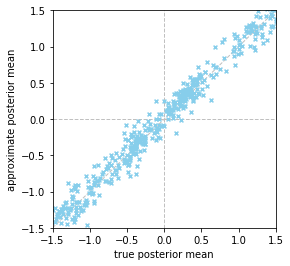

new lr: 0.003125
epoch 14 iteration 13000 loss 26.174 CE 25.098 KL 1.076 weighted KL: 1.076 weight 1.000
epoch 14 iteration 13100 loss 29.375 CE 28.464 KL 0.911 weighted KL: 0.911 weight 1.000
epoch 14 iteration 13200 loss 28.013 CE 26.869 KL 1.144 weighted KL: 1.144 weight 1.000
epoch 14 iteration 13300 loss 30.251 CE 29.161 KL 1.091 weighted KL: 1.091 weight 1.000
epoch 14 iteration 13400 loss 25.602 CE 24.445 KL 1.157 weighted KL: 1.157 weight 1.000
epoch 14 iteration 13500 loss 25.377 CE 24.292 KL 1.085 weighted KL: 1.085 weight 1.000
epoch 14 iteration 13600 loss 28.326 CE 27.109 KL 1.217 weighted KL: 1.217 weight 1.000
epoch 14 iteration 13700 loss 26.385 CE 25.450 KL 0.935 weighted KL: 0.935 weight 1.000
epoch 14 iteration 13800 loss 24.650 CE 23.446 KL 1.204 weighted KL: 1.204 weight 1.000
epoch 14 iteration 13900 loss 31.456 CE 30.353 KL 1.103 weighted KL: 1.103 weight 1.000
Epoch [14/30], Training Loss: 28.9353,  Training KL: 1.0917, Training Perplexity: 24.90, Validation Los

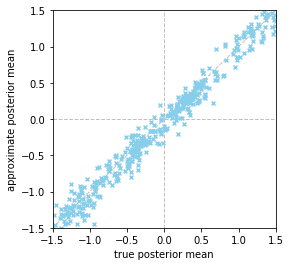

epoch 15 iteration 14000 loss 28.693 CE 27.547 KL 1.147 weighted KL: 1.147 weight 1.000
epoch 15 iteration 14100 loss 30.224 CE 29.250 KL 0.974 weighted KL: 0.974 weight 1.000
epoch 15 iteration 14200 loss 30.603 CE 29.539 KL 1.064 weighted KL: 1.064 weight 1.000
epoch 15 iteration 14300 loss 30.599 CE 29.541 KL 1.058 weighted KL: 1.058 weight 1.000
epoch 15 iteration 14400 loss 27.907 CE 26.793 KL 1.114 weighted KL: 1.114 weight 1.000
epoch 15 iteration 14500 loss 28.586 CE 27.528 KL 1.058 weighted KL: 1.058 weight 1.000
epoch 15 iteration 14600 loss 30.330 CE 29.303 KL 1.027 weighted KL: 1.027 weight 1.000
epoch 15 iteration 14700 loss 28.398 CE 27.276 KL 1.122 weighted KL: 1.122 weight 1.000
epoch 15 iteration 14800 loss 25.798 CE 24.750 KL 1.048 weighted KL: 1.048 weight 1.000
epoch 15 iteration 14900 loss 30.170 CE 29.084 KL 1.086 weighted KL: 1.086 weight 1.000
Epoch [15/30], Training Loss: 28.8621,  Training KL: 1.0922, Training Perplexity: 24.70, Validation Loss: 32.4853, KL 1.

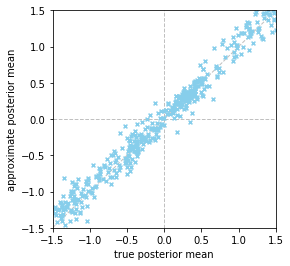

new lr: 0.001563


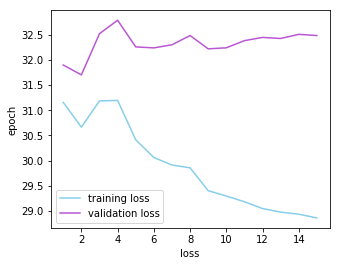

In [47]:
#with annealing
vocab_size = 1000
hidden_size = 50
embedding_size = 50
latent_size = 1
num_layers = 1
step = 0.25
learning_rate = 0.05
epochs = 30
max_sentence_length = 10

embedding_weights = nn.Embedding(vocab_size, embedding_size).weight
vae_anneal = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

annealing_args = {'type':'logistic', 'step':0, 'k':0.0025, 'first_step':2500}

return_dict_anneal = train(vae_anneal, inputs, targets, val_inputs, val_targets, epochs, vocab_size, hidden_size, 
                    latent_size, max_sentence_length, plot=True, learning_rate=learning_rate, synthetic=True, 
                    step=step, plot_lim=1.5, annealing_args=annealing_args, tracked_inputs=tracked_inputs, 
                    tracked_targets=tracked_targets, plot_dir="plots_annealing")
plot_losses(return_dict_anneal['total_epoch_losses'], return_dict_anneal['val_total_epoch_losses'])

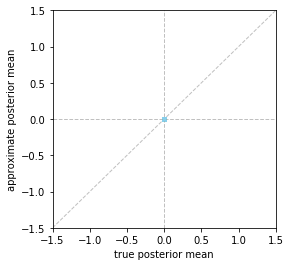

epoch 1 iteration 0 loss 62.165 CE 62.165 KL 0.000 weighted KL: 0.000 weight 0.002
epoch 1 iteration 100 loss 45.667 CE 45.657 KL 3.959 weighted KL: 0.010 weight 0.002
epoch 1 iteration 200 loss 40.213 CE 40.205 KL 2.556 weighted KL: 0.008 weight 0.003
epoch 1 iteration 300 loss 34.116 CE 34.050 KL 16.215 weighted KL: 0.066 weight 0.004
epoch 1 iteration 400 loss 36.463 CE 36.435 KL 5.206 weighted KL: 0.027 weight 0.005
epoch 1 iteration 500 loss 36.846 CE 36.783 KL 9.396 weighted KL: 0.063 weight 0.007
epoch 1 iteration 600 loss 35.620 CE 35.592 KL 3.285 weighted KL: 0.028 weight 0.009
epoch 1 iteration 700 loss 32.095 CE 32.024 KL 6.451 weighted KL: 0.071 weight 0.011
epoch 1 iteration 800 loss 35.034 CE 34.972 KL 4.428 weighted KL: 0.062 weight 0.014
epoch 1 iteration 900 loss 31.427 CE 31.315 KL 6.250 weighted KL: 0.112 weight 0.018
Epoch [1/30], Training Loss: 32.0652,  Training KL: 0.1324, Training Perplexity: 35.26, Validation Loss: 32.6283, KL 0.1285, Val Perplexity: 37.54



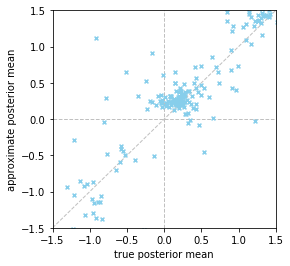

epoch 2 iteration 1000 loss 30.067 CE 29.927 KL 6.083 weighted KL: 0.140 weight 0.023
epoch 2 iteration 1100 loss 33.051 CE 32.901 KL 5.123 weighted KL: 0.150 weight 0.029
epoch 2 iteration 1200 loss 31.504 CE 31.332 KL 4.608 weighted KL: 0.172 weight 0.037
epoch 2 iteration 1300 loss 36.361 CE 36.179 KL 3.841 weighted KL: 0.182 weight 0.047
epoch 2 iteration 1400 loss 35.526 CE 35.274 KL 4.192 weighted KL: 0.252 weight 0.060
epoch 2 iteration 1500 loss 33.169 CE 32.906 KL 3.468 weighted KL: 0.263 weight 0.076
epoch 2 iteration 1600 loss 22.530 CE 22.129 KL 4.202 weighted KL: 0.401 weight 0.095
epoch 2 iteration 1700 loss 32.838 CE 32.482 KL 2.986 weighted KL: 0.356 weight 0.119
epoch 2 iteration 1800 loss 34.389 CE 34.030 KL 2.426 weighted KL: 0.359 weight 0.148
epoch 2 iteration 1900 loss 30.765 CE 30.275 KL 2.684 weighted KL: 0.490 weight 0.182
Epoch [2/30], Training Loss: 31.0249,  Training KL: 0.5896, Training Perplexity: 31.41, Validation Loss: 31.8087, KL 0.5819, Val Perplexity:

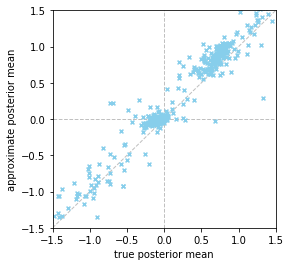

epoch 3 iteration 2000 loss 32.472 CE 31.946 KL 2.361 weighted KL: 0.526 weight 0.223
epoch 3 iteration 2100 loss 36.463 CE 35.843 KL 2.304 weighted KL: 0.620 weight 0.269
epoch 3 iteration 2200 loss 33.927 CE 33.154 KL 2.408 weighted KL: 0.773 weight 0.321
epoch 3 iteration 2300 loss 27.276 CE 26.440 KL 2.214 weighted KL: 0.836 weight 0.378
epoch 3 iteration 2400 loss 31.339 CE 30.336 KL 2.292 weighted KL: 1.003 weight 0.438
epoch 3 iteration 2500 loss 31.226 CE 30.209 KL 2.033 weighted KL: 1.016 weight 0.500
epoch 3 iteration 2600 loss 32.287 CE 31.160 KL 2.005 weighted KL: 1.127 weight 0.562
epoch 3 iteration 2700 loss 34.265 CE 33.178 KL 1.746 weighted KL: 1.087 weight 0.622
epoch 3 iteration 2800 loss 30.064 CE 28.823 KL 1.826 weighted KL: 1.240 weight 0.679
epoch 3 iteration 2900 loss 33.996 CE 32.702 KL 1.770 weighted KL: 1.294 weight 0.731
Epoch [3/30], Training Loss: 31.1668,  Training KL: 1.3317, Training Perplexity: 31.91, Validation Loss: 32.1357, KL 1.3200, Val Perplexity:

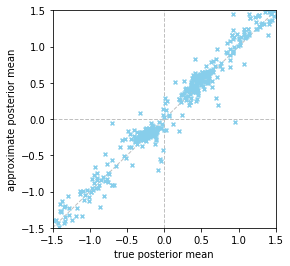

epoch 4 iteration 3000 loss 30.095 CE 28.837 KL 1.618 weighted KL: 1.258 weight 0.777
epoch 4 iteration 3100 loss 31.672 CE 30.316 KL 1.659 weighted KL: 1.356 weight 0.818
epoch 4 iteration 3200 loss 30.139 CE 28.390 KL 2.053 weighted KL: 1.749 weight 0.852
epoch 4 iteration 3300 loss 34.151 CE 32.677 KL 1.674 weighted KL: 1.474 weight 0.881
epoch 4 iteration 3400 loss 28.304 CE 26.927 KL 1.522 weighted KL: 1.377 weight 0.905
epoch 4 iteration 3500 loss 31.209 CE 29.667 KL 1.668 weighted KL: 1.542 weight 0.924
epoch 4 iteration 3600 loss 32.023 CE 30.638 KL 1.473 weighted KL: 1.385 weight 0.940
epoch 4 iteration 3700 loss 29.606 CE 28.082 KL 1.600 weighted KL: 1.524 weight 0.953
epoch 4 iteration 3800 loss 35.240 CE 33.855 KL 1.438 weighted KL: 1.385 weight 0.963
epoch 4 iteration 3900 loss 32.158 CE 30.657 KL 1.546 weighted KL: 1.501 weight 0.971
Epoch [4/30], Training Loss: 30.9939,  Training KL: 1.5296, Training Perplexity: 31.30, Validation Loss: 32.1457, KL 1.5087, Val Perplexity:

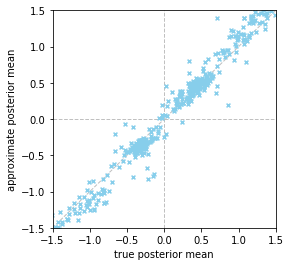

new lr: 0.005000
epoch 5 iteration 4000 loss 30.675 CE 29.008 KL 1.707 weighted KL: 1.668 weight 0.977
epoch 5 iteration 4100 loss 32.993 CE 31.551 KL 1.468 weighted KL: 1.442 weight 0.982
epoch 5 iteration 4200 loss 34.640 CE 33.235 KL 1.424 weighted KL: 1.404 weight 0.986
epoch 5 iteration 4300 loss 34.413 CE 32.981 KL 1.448 weighted KL: 1.432 weight 0.989
epoch 5 iteration 4400 loss 26.551 CE 25.137 KL 1.426 weighted KL: 1.414 weight 0.991
epoch 5 iteration 4500 loss 35.558 CE 34.186 KL 1.382 weighted KL: 1.372 weight 0.993
epoch 5 iteration 4600 loss 25.590 CE 23.675 KL 1.925 weighted KL: 1.915 weight 0.995
epoch 5 iteration 4700 loss 28.956 CE 27.412 KL 1.550 weighted KL: 1.544 weight 0.996
epoch 5 iteration 4800 loss 32.608 CE 31.331 KL 1.282 weighted KL: 1.278 weight 0.997
epoch 5 iteration 4900 loss 31.249 CE 29.929 KL 1.323 weighted KL: 1.319 weight 0.998
Epoch [5/30], Training Loss: 30.4885,  Training KL: 1.4307, Training Perplexity: 29.60, Validation Loss: 31.8550, KL 1.4147

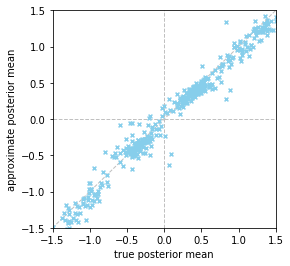

epoch 6 iteration 5000 loss 30.456 CE 29.028 KL 1.431 weighted KL: 1.428 weight 0.998
epoch 6 iteration 5100 loss 29.531 CE 28.187 KL 1.346 weighted KL: 1.344 weight 0.998
epoch 6 iteration 5200 loss 28.052 CE 26.511 KL 1.543 weighted KL: 1.541 weight 0.999
epoch 6 iteration 5300 loss 33.629 CE 32.214 KL 1.416 weighted KL: 1.415 weight 0.999
epoch 6 iteration 5400 loss 30.393 CE 28.682 KL 1.712 weighted KL: 1.711 weight 0.999
epoch 6 iteration 5500 loss 34.208 CE 32.920 KL 1.289 weighted KL: 1.288 weight 0.999
epoch 6 iteration 5600 loss 25.141 CE 23.663 KL 1.479 weighted KL: 1.478 weight 1.000
epoch 6 iteration 5700 loss 31.725 CE 30.251 KL 1.475 weighted KL: 1.474 weight 1.000
epoch 6 iteration 5800 loss 33.781 CE 32.450 KL 1.331 weighted KL: 1.331 weight 1.000
epoch 6 iteration 5900 loss 31.037 CE 29.602 KL 1.435 weighted KL: 1.435 weight 1.000
Epoch [6/30], Training Loss: 30.2119,  Training KL: 1.4290, Training Perplexity: 28.70, Validation Loss: 31.7840, KL 1.4142, Val Perplexity:

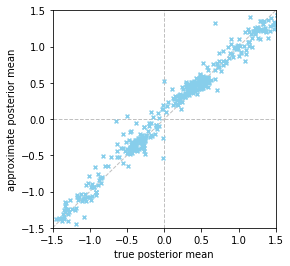

epoch 7 iteration 6000 loss 31.345 CE 30.047 KL 1.298 weighted KL: 1.297 weight 1.000
epoch 7 iteration 6100 loss 34.210 CE 32.752 KL 1.458 weighted KL: 1.458 weight 1.000
epoch 7 iteration 6200 loss 28.237 CE 26.744 KL 1.493 weighted KL: 1.493 weight 1.000
epoch 7 iteration 6300 loss 28.413 CE 26.779 KL 1.634 weighted KL: 1.634 weight 1.000
epoch 7 iteration 6400 loss 27.668 CE 25.878 KL 1.791 weighted KL: 1.790 weight 1.000
epoch 7 iteration 6500 loss 31.544 CE 30.137 KL 1.407 weighted KL: 1.407 weight 1.000
epoch 7 iteration 6600 loss 30.153 CE 28.577 KL 1.576 weighted KL: 1.576 weight 1.000
epoch 7 iteration 6700 loss 30.783 CE 29.146 KL 1.637 weighted KL: 1.637 weight 1.000
epoch 7 iteration 6800 loss 26.634 CE 25.265 KL 1.369 weighted KL: 1.369 weight 1.000
epoch 7 iteration 6900 loss 27.786 CE 26.331 KL 1.455 weighted KL: 1.455 weight 1.000
Epoch [7/30], Training Loss: 30.0129,  Training KL: 1.4172, Training Perplexity: 28.07, Validation Loss: 31.8012, KL 1.4008, Val Perplexity:

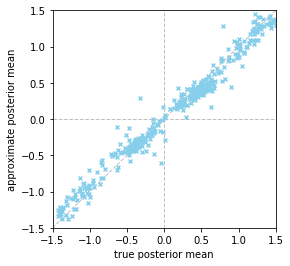

epoch 8 iteration 7000 loss 26.723 CE 25.246 KL 1.477 weighted KL: 1.477 weight 1.000
epoch 8 iteration 7100 loss 27.105 CE 25.651 KL 1.455 weighted KL: 1.455 weight 1.000
epoch 8 iteration 7200 loss 27.782 CE 26.516 KL 1.267 weighted KL: 1.267 weight 1.000
epoch 8 iteration 7300 loss 29.736 CE 28.201 KL 1.536 weighted KL: 1.536 weight 1.000
epoch 8 iteration 7400 loss 32.461 CE 30.980 KL 1.481 weighted KL: 1.481 weight 1.000
epoch 8 iteration 7500 loss 30.001 CE 28.556 KL 1.445 weighted KL: 1.445 weight 1.000
epoch 8 iteration 7600 loss 31.033 CE 29.520 KL 1.513 weighted KL: 1.513 weight 1.000
epoch 8 iteration 7700 loss 24.792 CE 22.861 KL 1.932 weighted KL: 1.932 weight 1.000
epoch 8 iteration 7800 loss 31.060 CE 29.781 KL 1.278 weighted KL: 1.278 weight 1.000
epoch 8 iteration 7900 loss 29.341 CE 27.547 KL 1.794 weighted KL: 1.794 weight 1.000
Epoch [8/30], Training Loss: 29.8394,  Training KL: 1.4318, Training Perplexity: 27.54, Validation Loss: 31.7911, KL 1.4164, Val Perplexity:

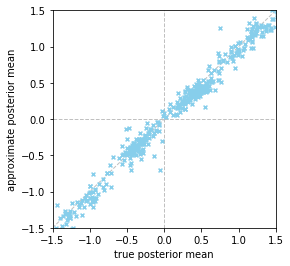

new lr: 0.002500
epoch 9 iteration 8000 loss 29.456 CE 28.041 KL 1.415 weighted KL: 1.415 weight 1.000
epoch 9 iteration 8100 loss 27.946 CE 26.457 KL 1.489 weighted KL: 1.489 weight 1.000
epoch 9 iteration 8200 loss 31.537 CE 30.089 KL 1.448 weighted KL: 1.448 weight 1.000
epoch 9 iteration 8300 loss 31.027 CE 29.546 KL 1.481 weighted KL: 1.481 weight 1.000
epoch 9 iteration 8400 loss 31.111 CE 29.765 KL 1.347 weighted KL: 1.347 weight 1.000
epoch 9 iteration 8500 loss 33.068 CE 31.646 KL 1.421 weighted KL: 1.421 weight 1.000
epoch 9 iteration 8600 loss 30.137 CE 28.657 KL 1.480 weighted KL: 1.480 weight 1.000
epoch 9 iteration 8700 loss 27.747 CE 26.245 KL 1.502 weighted KL: 1.502 weight 1.000
epoch 9 iteration 8800 loss 28.629 CE 27.269 KL 1.360 weighted KL: 1.360 weight 1.000
epoch 9 iteration 8900 loss 30.581 CE 29.116 KL 1.465 weighted KL: 1.465 weight 1.000
Epoch [9/30], Training Loss: 29.6481,  Training KL: 1.4365, Training Perplexity: 26.96, Validation Loss: 31.7379, KL 1.4189

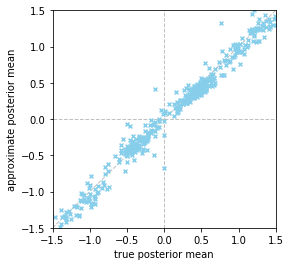

epoch 10 iteration 9000 loss 34.029 CE 32.725 KL 1.304 weighted KL: 1.304 weight 1.000
epoch 10 iteration 9100 loss 32.376 CE 31.045 KL 1.331 weighted KL: 1.331 weight 1.000
epoch 10 iteration 9200 loss 28.160 CE 26.596 KL 1.565 weighted KL: 1.565 weight 1.000
epoch 10 iteration 9300 loss 28.108 CE 26.625 KL 1.484 weighted KL: 1.484 weight 1.000
epoch 10 iteration 9400 loss 28.401 CE 26.980 KL 1.421 weighted KL: 1.421 weight 1.000
epoch 10 iteration 9500 loss 33.673 CE 32.217 KL 1.456 weighted KL: 1.456 weight 1.000
epoch 10 iteration 9600 loss 25.567 CE 24.113 KL 1.454 weighted KL: 1.454 weight 1.000
epoch 10 iteration 9700 loss 29.566 CE 28.169 KL 1.397 weighted KL: 1.397 weight 1.000
epoch 10 iteration 9800 loss 30.846 CE 29.226 KL 1.620 weighted KL: 1.620 weight 1.000
epoch 10 iteration 9900 loss 33.620 CE 32.207 KL 1.412 weighted KL: 1.412 weight 1.000
Epoch [10/30], Training Loss: 29.5456,  Training KL: 1.4697, Training Perplexity: 26.65, Validation Loss: 31.7701, KL 1.4533, Val 

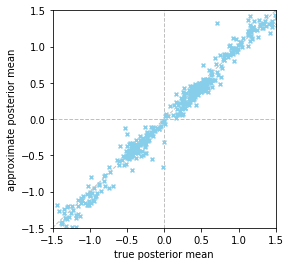

epoch 11 iteration 10000 loss 32.062 CE 30.609 KL 1.453 weighted KL: 1.453 weight 1.000
epoch 11 iteration 10100 loss 27.550 CE 26.148 KL 1.402 weighted KL: 1.402 weight 1.000
epoch 11 iteration 10200 loss 28.080 CE 26.577 KL 1.503 weighted KL: 1.503 weight 1.000
epoch 11 iteration 10300 loss 32.159 CE 30.827 KL 1.333 weighted KL: 1.333 weight 1.000
epoch 11 iteration 10400 loss 30.854 CE 29.429 KL 1.425 weighted KL: 1.425 weight 1.000
epoch 11 iteration 10500 loss 32.027 CE 30.648 KL 1.378 weighted KL: 1.378 weight 1.000
epoch 11 iteration 10600 loss 32.068 CE 30.431 KL 1.636 weighted KL: 1.636 weight 1.000
epoch 11 iteration 10700 loss 27.970 CE 26.436 KL 1.533 weighted KL: 1.533 weight 1.000
epoch 11 iteration 10800 loss 28.180 CE 26.669 KL 1.511 weighted KL: 1.511 weight 1.000
epoch 11 iteration 10900 loss 29.757 CE 28.173 KL 1.585 weighted KL: 1.585 weight 1.000
Epoch [11/30], Training Loss: 29.4595,  Training KL: 1.5227, Training Perplexity: 26.40, Validation Loss: 31.7642, KL 1.

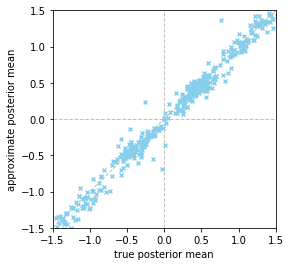

new lr: 0.001250
epoch 12 iteration 11000 loss 29.440 CE 27.857 KL 1.583 weighted KL: 1.583 weight 1.000
epoch 12 iteration 11100 loss 30.190 CE 28.791 KL 1.399 weighted KL: 1.399 weight 1.000
epoch 12 iteration 11200 loss 27.699 CE 26.246 KL 1.453 weighted KL: 1.453 weight 1.000
epoch 12 iteration 11300 loss 31.620 CE 30.189 KL 1.431 weighted KL: 1.431 weight 1.000
epoch 12 iteration 11400 loss 32.701 CE 31.240 KL 1.460 weighted KL: 1.460 weight 1.000
epoch 12 iteration 11500 loss 29.258 CE 27.800 KL 1.458 weighted KL: 1.458 weight 1.000
epoch 12 iteration 11600 loss 28.031 CE 26.618 KL 1.413 weighted KL: 1.413 weight 1.000
epoch 12 iteration 11700 loss 33.066 CE 31.643 KL 1.423 weighted KL: 1.423 weight 1.000
epoch 12 iteration 11800 loss 30.233 CE 28.806 KL 1.427 weighted KL: 1.427 weight 1.000
epoch 12 iteration 11900 loss 29.831 CE 28.350 KL 1.480 weighted KL: 1.480 weight 1.000
Epoch [12/30], Training Loss: 29.3963,  Training KL: 1.5014, Training Perplexity: 26.21, Validation Los

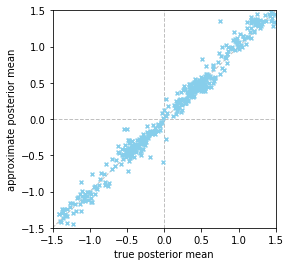

epoch 13 iteration 12000 loss 30.500 CE 29.106 KL 1.394 weighted KL: 1.394 weight 1.000
epoch 13 iteration 12100 loss 31.826 CE 30.350 KL 1.476 weighted KL: 1.476 weight 1.000
epoch 13 iteration 12200 loss 34.095 CE 32.624 KL 1.472 weighted KL: 1.472 weight 1.000
epoch 13 iteration 12300 loss 29.002 CE 27.137 KL 1.864 weighted KL: 1.864 weight 1.000
epoch 13 iteration 12400 loss 31.776 CE 30.429 KL 1.348 weighted KL: 1.348 weight 1.000
epoch 13 iteration 12500 loss 28.926 CE 27.452 KL 1.474 weighted KL: 1.474 weight 1.000
epoch 13 iteration 12600 loss 30.728 CE 29.324 KL 1.403 weighted KL: 1.403 weight 1.000
epoch 13 iteration 12700 loss 34.015 CE 32.535 KL 1.480 weighted KL: 1.480 weight 1.000
epoch 13 iteration 12800 loss 27.410 CE 25.948 KL 1.462 weighted KL: 1.462 weight 1.000
epoch 13 iteration 12900 loss 31.096 CE 29.674 KL 1.422 weighted KL: 1.422 weight 1.000
Epoch [13/30], Training Loss: 29.3345,  Training KL: 1.4741, Training Perplexity: 26.03, Validation Loss: 31.7882, KL 1.

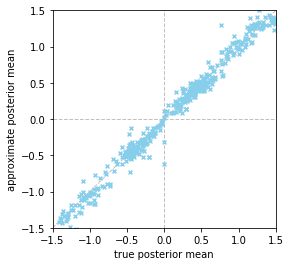

new lr: 0.000625
epoch 14 iteration 13000 loss 29.235 CE 27.779 KL 1.455 weighted KL: 1.455 weight 1.000
epoch 14 iteration 13100 loss 26.275 CE 24.659 KL 1.616 weighted KL: 1.616 weight 1.000
epoch 14 iteration 13200 loss 30.680 CE 29.087 KL 1.593 weighted KL: 1.593 weight 1.000
epoch 14 iteration 13300 loss 30.103 CE 28.502 KL 1.600 weighted KL: 1.600 weight 1.000
epoch 14 iteration 13400 loss 28.947 CE 27.419 KL 1.528 weighted KL: 1.528 weight 1.000
epoch 14 iteration 13500 loss 31.812 CE 30.402 KL 1.410 weighted KL: 1.410 weight 1.000
epoch 14 iteration 13600 loss 24.949 CE 23.234 KL 1.715 weighted KL: 1.715 weight 1.000
epoch 14 iteration 13700 loss 27.868 CE 26.320 KL 1.548 weighted KL: 1.548 weight 1.000
epoch 14 iteration 13800 loss 29.423 CE 27.872 KL 1.551 weighted KL: 1.551 weight 1.000
epoch 14 iteration 13900 loss 29.119 CE 27.643 KL 1.476 weighted KL: 1.476 weight 1.000
Epoch [14/30], Training Loss: 29.3071,  Training KL: 1.4792, Training Perplexity: 25.95, Validation Los

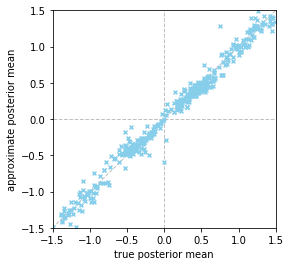

epoch 15 iteration 14000 loss 28.009 CE 26.405 KL 1.604 weighted KL: 1.604 weight 1.000
epoch 15 iteration 14100 loss 29.292 CE 27.923 KL 1.369 weighted KL: 1.369 weight 1.000
epoch 15 iteration 14200 loss 27.433 CE 25.864 KL 1.570 weighted KL: 1.570 weight 1.000
epoch 15 iteration 14300 loss 30.414 CE 29.000 KL 1.414 weighted KL: 1.414 weight 1.000
epoch 15 iteration 14400 loss 28.847 CE 27.318 KL 1.528 weighted KL: 1.528 weight 1.000
epoch 15 iteration 14500 loss 29.076 CE 27.605 KL 1.472 weighted KL: 1.472 weight 1.000
epoch 15 iteration 14600 loss 26.635 CE 24.937 KL 1.699 weighted KL: 1.699 weight 1.000
epoch 15 iteration 14700 loss 28.068 CE 26.696 KL 1.372 weighted KL: 1.372 weight 1.000
epoch 15 iteration 14800 loss 31.363 CE 29.941 KL 1.422 weighted KL: 1.422 weight 1.000
epoch 15 iteration 14900 loss 27.429 CE 25.832 KL 1.597 weighted KL: 1.597 weight 1.000
Epoch [15/30], Training Loss: 29.2779,  Training KL: 1.4873, Training Perplexity: 25.87, Validation Loss: 31.8431, KL 1.

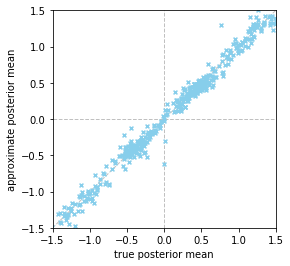

new lr: 0.000313


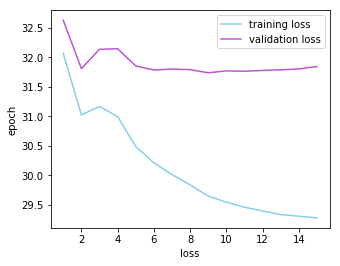

In [60]:
#with annealing
vocab_size = 1000
hidden_size = 50
embedding_size = 50
latent_size = 1
num_layers = 1
step = 0.25
learning_rate = 0.01
epochs = 30
max_sentence_length = 10

embedding_weights = nn.Embedding(vocab_size, embedding_size).weight
vae_anneal_new = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

annealing_args = {'type':'logistic', 'step':0, 'k':0.0025, 'first_step':2500}

return_dict_anneal_new = train(vae_anneal_new, inputs, targets, val_inputs, val_targets, epochs, vocab_size, hidden_size, 
                    latent_size, max_sentence_length, plot=True, learning_rate=learning_rate, synthetic=True, 
                    step=step, plot_lim=1.5, annealing_args=annealing_args, tracked_inputs=tracked_inputs, 
                    tracked_targets=tracked_targets, plot_dir="plots_annealing_new")
plot_losses(return_dict_anneal_new['total_epoch_losses'], return_dict_anneal_new['val_total_epoch_losses'])

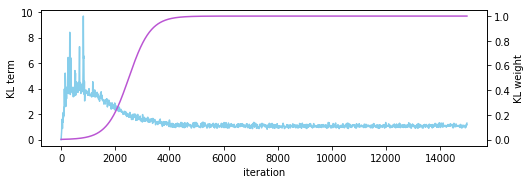

In [49]:
plot_kl(return_dict_anneal['kl_terms'], return_dict_anneal['kl_weights'], save=True, plot_dir="plots_annealing")

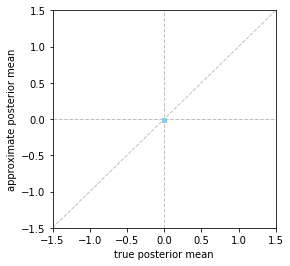

epoch 1 iteration 0 loss 62.165 CE 62.165 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 100 loss 48.643 CE 48.640 KL 0.003 weighted KL: 0.003 weight 1.000
epoch 1 iteration 200 loss 44.395 CE 44.355 KL 0.040 weighted KL: 0.040 weight 1.000
epoch 1 iteration 300 loss 35.072 CE 33.934 KL 1.138 weighted KL: 1.138 weight 1.000
epoch 1 iteration 400 loss 34.229 CE 32.900 KL 1.329 weighted KL: 1.329 weight 1.000
epoch 1 iteration 500 loss 37.765 CE 36.320 KL 1.445 weighted KL: 1.445 weight 1.000
epoch 1 iteration 600 loss 31.404 CE 29.814 KL 1.589 weighted KL: 1.589 weight 1.000
epoch 1 iteration 700 loss 37.990 CE 36.463 KL 1.527 weighted KL: 1.527 weight 1.000
epoch 1 iteration 800 loss 32.141 CE 30.566 KL 1.575 weighted KL: 1.575 weight 1.000
epoch 1 iteration 900 loss 33.608 CE 32.155 KL 1.452 weighted KL: 1.452 weight 1.000
current_mi: 2.7700221939086913
Epoch [1/30], Training Loss: 33.7613,  Training KL: 1.4283, Training Perplexity: 42.57, Validation Loss: 34.2745, KL 1.42

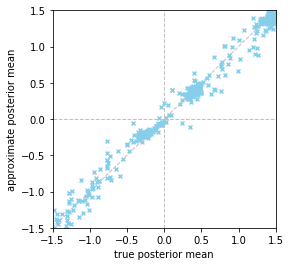

epoch 2 iteration 1000 loss 33.084 CE 31.472 KL 1.611 weighted KL: 1.611 weight 1.000
epoch 2 iteration 1100 loss 33.358 CE 31.853 KL 1.505 weighted KL: 1.505 weight 1.000
epoch 2 iteration 1200 loss 35.911 CE 34.375 KL 1.536 weighted KL: 1.536 weight 1.000
epoch 2 iteration 1300 loss 31.281 CE 29.648 KL 1.633 weighted KL: 1.633 weight 1.000
epoch 2 iteration 1400 loss 36.830 CE 35.283 KL 1.547 weighted KL: 1.547 weight 1.000
epoch 2 iteration 1500 loss 31.907 CE 30.411 KL 1.495 weighted KL: 1.495 weight 1.000
epoch 2 iteration 1600 loss 33.824 CE 32.447 KL 1.377 weighted KL: 1.377 weight 1.000
epoch 2 iteration 1700 loss 32.967 CE 31.464 KL 1.503 weighted KL: 1.503 weight 1.000
epoch 2 iteration 1800 loss 35.159 CE 33.435 KL 1.724 weighted KL: 1.724 weight 1.000
epoch 2 iteration 1900 loss 30.842 CE 29.259 KL 1.583 weighted KL: 1.583 weight 1.000
current_mi: 2.7903158416748046
Epoch [2/30], Training Loss: 32.2499,  Training KL: 1.6755, Training Perplexity: 35.99, Validation Loss: 33.0

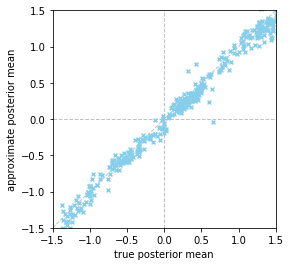

epoch 3 iteration 2000 loss 30.039 CE 28.420 KL 1.619 weighted KL: 1.619 weight 1.000
epoch 3 iteration 2100 loss 32.072 CE 30.518 KL 1.554 weighted KL: 1.554 weight 1.000
epoch 3 iteration 2200 loss 33.129 CE 31.346 KL 1.783 weighted KL: 1.783 weight 1.000
epoch 3 iteration 2300 loss 32.121 CE 30.464 KL 1.658 weighted KL: 1.658 weight 1.000
epoch 3 iteration 2400 loss 34.331 CE 32.654 KL 1.676 weighted KL: 1.676 weight 1.000
epoch 3 iteration 2500 loss 34.820 CE 33.123 KL 1.697 weighted KL: 1.697 weight 1.000
epoch 3 iteration 2600 loss 29.310 CE 27.598 KL 1.712 weighted KL: 1.712 weight 1.000
epoch 3 iteration 2700 loss 30.008 CE 28.423 KL 1.585 weighted KL: 1.585 weight 1.000
epoch 3 iteration 2800 loss 29.809 CE 28.204 KL 1.606 weighted KL: 1.606 weight 1.000
epoch 3 iteration 2900 loss 31.006 CE 29.357 KL 1.649 weighted KL: 1.649 weight 1.000
current_mi: 2.7538056449890136
STOP AGGRESSIVE
Epoch [3/30], Training Loss: 31.5295,  Training KL: 1.6793, Training Perplexity: 33.22, Valid

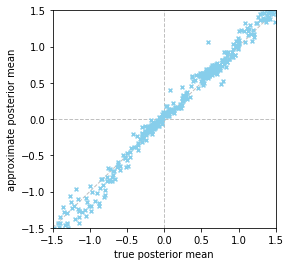

epoch 4 iteration 3000 loss 30.616 CE 28.891 KL 1.724 weighted KL: 1.724 weight 1.000
epoch 4 iteration 3100 loss 31.977 CE 30.419 KL 1.559 weighted KL: 1.559 weight 1.000
epoch 4 iteration 3200 loss 28.355 CE 26.767 KL 1.588 weighted KL: 1.588 weight 1.000
epoch 4 iteration 3300 loss 27.701 CE 26.121 KL 1.579 weighted KL: 1.579 weight 1.000
epoch 4 iteration 3400 loss 30.695 CE 29.089 KL 1.605 weighted KL: 1.605 weight 1.000
epoch 4 iteration 3500 loss 31.620 CE 30.020 KL 1.600 weighted KL: 1.600 weight 1.000
epoch 4 iteration 3600 loss 29.134 CE 27.631 KL 1.503 weighted KL: 1.503 weight 1.000
epoch 4 iteration 3700 loss 30.593 CE 29.028 KL 1.565 weighted KL: 1.565 weight 1.000
epoch 4 iteration 3800 loss 35.184 CE 33.606 KL 1.577 weighted KL: 1.577 weight 1.000
epoch 4 iteration 3900 loss 34.941 CE 33.275 KL 1.665 weighted KL: 1.665 weight 1.000
Epoch [4/30], Training Loss: 30.8936,  Training KL: 1.6047, Training Perplexity: 30.96, Validation Loss: 32.1205, KL 1.6023, Val Perplexity:

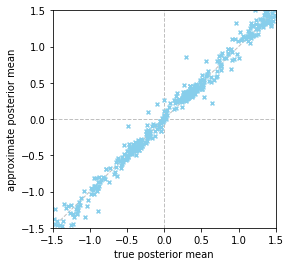

epoch 5 iteration 4000 loss 28.870 CE 27.297 KL 1.573 weighted KL: 1.573 weight 1.000
epoch 5 iteration 4100 loss 28.239 CE 26.652 KL 1.586 weighted KL: 1.586 weight 1.000
epoch 5 iteration 4200 loss 31.194 CE 29.641 KL 1.553 weighted KL: 1.553 weight 1.000
epoch 5 iteration 4300 loss 27.755 CE 26.118 KL 1.637 weighted KL: 1.637 weight 1.000
epoch 5 iteration 4400 loss 31.725 CE 30.214 KL 1.510 weighted KL: 1.510 weight 1.000
epoch 5 iteration 4500 loss 29.012 CE 27.461 KL 1.551 weighted KL: 1.551 weight 1.000
epoch 5 iteration 4600 loss 33.155 CE 31.527 KL 1.628 weighted KL: 1.628 weight 1.000
epoch 5 iteration 4700 loss 29.406 CE 27.840 KL 1.567 weighted KL: 1.567 weight 1.000
epoch 5 iteration 4800 loss 34.078 CE 32.504 KL 1.574 weighted KL: 1.574 weight 1.000
epoch 5 iteration 4900 loss 33.662 CE 31.858 KL 1.804 weighted KL: 1.804 weight 1.000
Epoch [5/30], Training Loss: 30.6167,  Training KL: 1.5874, Training Perplexity: 30.02, Validation Loss: 31.9263, KL 1.5881, Val Perplexity:

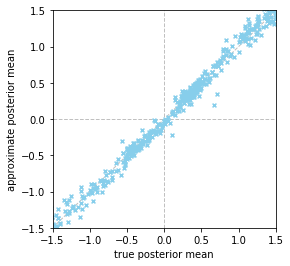

epoch 6 iteration 5000 loss 29.581 CE 27.995 KL 1.586 weighted KL: 1.586 weight 1.000
epoch 6 iteration 5100 loss 27.712 CE 26.118 KL 1.594 weighted KL: 1.594 weight 1.000
epoch 6 iteration 5200 loss 30.011 CE 28.475 KL 1.536 weighted KL: 1.536 weight 1.000
epoch 6 iteration 5300 loss 30.868 CE 29.270 KL 1.598 weighted KL: 1.598 weight 1.000
epoch 6 iteration 5400 loss 28.423 CE 26.814 KL 1.609 weighted KL: 1.609 weight 1.000
epoch 6 iteration 5500 loss 30.506 CE 28.840 KL 1.666 weighted KL: 1.666 weight 1.000
epoch 6 iteration 5600 loss 35.022 CE 33.391 KL 1.631 weighted KL: 1.631 weight 1.000
epoch 6 iteration 5700 loss 30.664 CE 29.040 KL 1.624 weighted KL: 1.624 weight 1.000
epoch 6 iteration 5800 loss 31.406 CE 29.791 KL 1.615 weighted KL: 1.615 weight 1.000
epoch 6 iteration 5900 loss 27.612 CE 25.991 KL 1.620 weighted KL: 1.620 weight 1.000
Epoch [6/30], Training Loss: 30.3280,  Training KL: 1.5944, Training Perplexity: 29.07, Validation Loss: 31.8862, KL 1.5951, Val Perplexity:

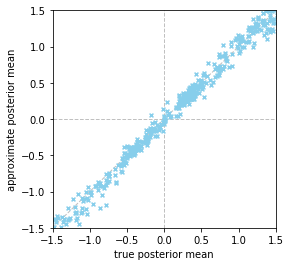

epoch 7 iteration 6000 loss 31.760 CE 30.136 KL 1.624 weighted KL: 1.624 weight 1.000
epoch 7 iteration 6100 loss 30.933 CE 29.255 KL 1.678 weighted KL: 1.678 weight 1.000
epoch 7 iteration 6200 loss 27.117 CE 25.454 KL 1.663 weighted KL: 1.663 weight 1.000
epoch 7 iteration 6300 loss 28.235 CE 26.630 KL 1.605 weighted KL: 1.605 weight 1.000
epoch 7 iteration 6400 loss 30.294 CE 28.790 KL 1.504 weighted KL: 1.504 weight 1.000
epoch 7 iteration 6500 loss 32.237 CE 30.726 KL 1.511 weighted KL: 1.511 weight 1.000
epoch 7 iteration 6600 loss 28.972 CE 27.266 KL 1.707 weighted KL: 1.707 weight 1.000
epoch 7 iteration 6700 loss 32.506 CE 30.946 KL 1.560 weighted KL: 1.560 weight 1.000
epoch 7 iteration 6800 loss 33.656 CE 31.916 KL 1.739 weighted KL: 1.739 weight 1.000
epoch 7 iteration 6900 loss 30.001 CE 28.500 KL 1.501 weighted KL: 1.501 weight 1.000
Epoch [7/30], Training Loss: 30.1781,  Training KL: 1.5872, Training Perplexity: 28.59, Validation Loss: 31.9443, KL 1.5848, Val Perplexity:

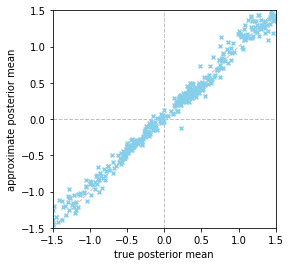

epoch 8 iteration 7000 loss 29.283 CE 27.646 KL 1.637 weighted KL: 1.637 weight 1.000
epoch 8 iteration 7100 loss 27.010 CE 25.412 KL 1.598 weighted KL: 1.598 weight 1.000
epoch 8 iteration 7200 loss 31.025 CE 29.451 KL 1.575 weighted KL: 1.575 weight 1.000
epoch 8 iteration 7300 loss 34.897 CE 33.290 KL 1.607 weighted KL: 1.607 weight 1.000
epoch 8 iteration 7400 loss 24.369 CE 22.755 KL 1.613 weighted KL: 1.613 weight 1.000
epoch 8 iteration 7500 loss 34.338 CE 32.701 KL 1.637 weighted KL: 1.637 weight 1.000
epoch 8 iteration 7600 loss 29.462 CE 27.836 KL 1.626 weighted KL: 1.626 weight 1.000
epoch 8 iteration 7700 loss 33.419 CE 31.883 KL 1.535 weighted KL: 1.535 weight 1.000
epoch 8 iteration 7800 loss 30.827 CE 29.260 KL 1.567 weighted KL: 1.567 weight 1.000
epoch 8 iteration 7900 loss 30.459 CE 28.769 KL 1.690 weighted KL: 1.690 weight 1.000
Epoch [8/30], Training Loss: 29.8857,  Training KL: 1.5167, Training Perplexity: 27.68, Validation Loss: 31.8678, KL 1.5175, Val Perplexity:

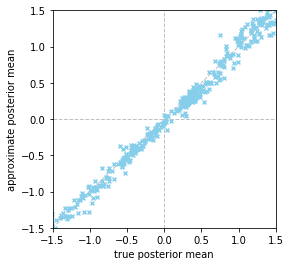

epoch 9 iteration 8000 loss 34.825 CE 33.234 KL 1.591 weighted KL: 1.591 weight 1.000
epoch 9 iteration 8100 loss 29.550 CE 27.824 KL 1.726 weighted KL: 1.726 weight 1.000
epoch 9 iteration 8200 loss 30.923 CE 29.414 KL 1.509 weighted KL: 1.509 weight 1.000
epoch 9 iteration 8300 loss 32.258 CE 30.761 KL 1.496 weighted KL: 1.496 weight 1.000
epoch 9 iteration 8400 loss 31.547 CE 29.967 KL 1.580 weighted KL: 1.580 weight 1.000
epoch 9 iteration 8500 loss 27.720 CE 26.218 KL 1.502 weighted KL: 1.502 weight 1.000
epoch 9 iteration 8600 loss 31.770 CE 30.134 KL 1.636 weighted KL: 1.636 weight 1.000
epoch 9 iteration 8700 loss 28.838 CE 27.281 KL 1.557 weighted KL: 1.557 weight 1.000
epoch 9 iteration 8800 loss 28.217 CE 26.503 KL 1.713 weighted KL: 1.713 weight 1.000
epoch 9 iteration 8900 loss 27.986 CE 26.436 KL 1.550 weighted KL: 1.550 weight 1.000
Epoch [9/30], Training Loss: 29.7213,  Training KL: 1.5702, Training Perplexity: 27.18, Validation Loss: 31.9555, KL 1.5713, Val Perplexity:

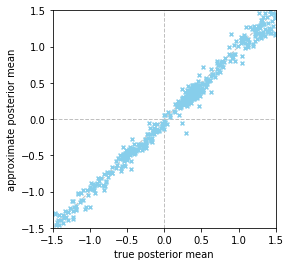

epoch 10 iteration 9000 loss 29.330 CE 27.726 KL 1.604 weighted KL: 1.604 weight 1.000
epoch 10 iteration 9100 loss 29.969 CE 28.478 KL 1.490 weighted KL: 1.490 weight 1.000
epoch 10 iteration 9200 loss 28.886 CE 27.288 KL 1.598 weighted KL: 1.598 weight 1.000
epoch 10 iteration 9300 loss 27.176 CE 25.645 KL 1.531 weighted KL: 1.531 weight 1.000
epoch 10 iteration 9400 loss 32.458 CE 30.750 KL 1.708 weighted KL: 1.708 weight 1.000
epoch 10 iteration 9500 loss 30.394 CE 28.805 KL 1.589 weighted KL: 1.589 weight 1.000
epoch 10 iteration 9600 loss 27.672 CE 25.846 KL 1.827 weighted KL: 1.827 weight 1.000
epoch 10 iteration 9700 loss 28.968 CE 27.350 KL 1.618 weighted KL: 1.618 weight 1.000
epoch 10 iteration 9800 loss 31.422 CE 29.860 KL 1.562 weighted KL: 1.562 weight 1.000
epoch 10 iteration 9900 loss 32.522 CE 30.891 KL 1.631 weighted KL: 1.631 weight 1.000
Epoch [10/30], Training Loss: 29.5867,  Training KL: 1.5643, Training Perplexity: 26.77, Validation Loss: 31.9877, KL 1.5662, Val 

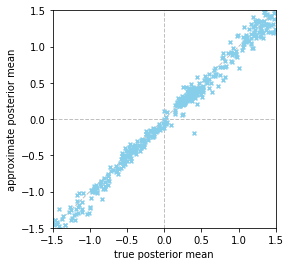

new lr: 0.005000
epoch 11 iteration 10000 loss 26.227 CE 24.609 KL 1.618 weighted KL: 1.618 weight 1.000
epoch 11 iteration 10100 loss 28.234 CE 26.704 KL 1.530 weighted KL: 1.530 weight 1.000
epoch 11 iteration 10200 loss 30.991 CE 29.386 KL 1.605 weighted KL: 1.605 weight 1.000
epoch 11 iteration 10300 loss 30.512 CE 28.970 KL 1.542 weighted KL: 1.542 weight 1.000
epoch 11 iteration 10400 loss 31.034 CE 29.552 KL 1.482 weighted KL: 1.482 weight 1.000
epoch 11 iteration 10500 loss 28.624 CE 27.048 KL 1.576 weighted KL: 1.576 weight 1.000
epoch 11 iteration 10600 loss 28.789 CE 27.255 KL 1.534 weighted KL: 1.534 weight 1.000
epoch 11 iteration 10700 loss 31.240 CE 29.775 KL 1.464 weighted KL: 1.464 weight 1.000
epoch 11 iteration 10800 loss 25.253 CE 23.740 KL 1.513 weighted KL: 1.513 weight 1.000
epoch 11 iteration 10900 loss 29.545 CE 27.935 KL 1.610 weighted KL: 1.610 weight 1.000
Epoch [11/30], Training Loss: 29.3301,  Training KL: 1.5829, Training Perplexity: 26.02, Validation Los

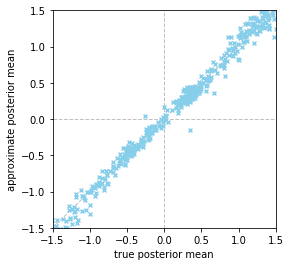

epoch 12 iteration 11000 loss 29.880 CE 28.266 KL 1.614 weighted KL: 1.614 weight 1.000
epoch 12 iteration 11100 loss 27.593 CE 25.886 KL 1.707 weighted KL: 1.707 weight 1.000
epoch 12 iteration 11200 loss 31.953 CE 30.344 KL 1.609 weighted KL: 1.609 weight 1.000
epoch 12 iteration 11300 loss 30.769 CE 29.292 KL 1.476 weighted KL: 1.476 weight 1.000
epoch 12 iteration 11400 loss 28.225 CE 26.664 KL 1.561 weighted KL: 1.561 weight 1.000
epoch 12 iteration 11500 loss 23.368 CE 21.676 KL 1.692 weighted KL: 1.692 weight 1.000
epoch 12 iteration 11600 loss 27.796 CE 26.243 KL 1.553 weighted KL: 1.553 weight 1.000
epoch 12 iteration 11700 loss 28.049 CE 26.399 KL 1.651 weighted KL: 1.651 weight 1.000
epoch 12 iteration 11800 loss 32.522 CE 30.863 KL 1.658 weighted KL: 1.658 weight 1.000
epoch 12 iteration 11900 loss 25.703 CE 24.133 KL 1.570 weighted KL: 1.570 weight 1.000
Epoch [12/30], Training Loss: 29.2044,  Training KL: 1.5992, Training Perplexity: 25.66, Validation Loss: 31.9863, KL 1.

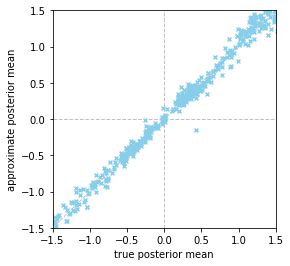

epoch 13 iteration 12000 loss 28.835 CE 27.117 KL 1.718 weighted KL: 1.718 weight 1.000
epoch 13 iteration 12100 loss 31.881 CE 30.221 KL 1.660 weighted KL: 1.660 weight 1.000
epoch 13 iteration 12200 loss 29.735 CE 28.170 KL 1.566 weighted KL: 1.566 weight 1.000
epoch 13 iteration 12300 loss 27.465 CE 25.988 KL 1.477 weighted KL: 1.477 weight 1.000
epoch 13 iteration 12400 loss 26.473 CE 24.841 KL 1.632 weighted KL: 1.632 weight 1.000
epoch 13 iteration 12500 loss 26.921 CE 25.283 KL 1.638 weighted KL: 1.638 weight 1.000
epoch 13 iteration 12600 loss 28.114 CE 26.513 KL 1.601 weighted KL: 1.601 weight 1.000
epoch 13 iteration 12700 loss 31.895 CE 30.234 KL 1.661 weighted KL: 1.661 weight 1.000
epoch 13 iteration 12800 loss 28.246 CE 26.553 KL 1.693 weighted KL: 1.693 weight 1.000
epoch 13 iteration 12900 loss 29.571 CE 28.056 KL 1.515 weighted KL: 1.515 weight 1.000
Epoch [13/30], Training Loss: 29.1149,  Training KL: 1.5964, Training Perplexity: 25.41, Validation Loss: 32.0641, KL 1.

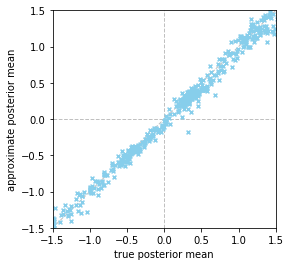

new lr: 0.002500
epoch 14 iteration 13000 loss 31.187 CE 29.479 KL 1.708 weighted KL: 1.708 weight 1.000
epoch 14 iteration 13100 loss 30.663 CE 29.206 KL 1.457 weighted KL: 1.457 weight 1.000
epoch 14 iteration 13200 loss 24.361 CE 22.805 KL 1.557 weighted KL: 1.557 weight 1.000
epoch 14 iteration 13300 loss 32.735 CE 31.155 KL 1.580 weighted KL: 1.580 weight 1.000
epoch 14 iteration 13400 loss 27.488 CE 25.960 KL 1.528 weighted KL: 1.528 weight 1.000
epoch 14 iteration 13500 loss 28.330 CE 26.893 KL 1.436 weighted KL: 1.436 weight 1.000
epoch 14 iteration 13600 loss 28.308 CE 26.776 KL 1.532 weighted KL: 1.532 weight 1.000
epoch 14 iteration 13700 loss 25.966 CE 24.389 KL 1.576 weighted KL: 1.576 weight 1.000
epoch 14 iteration 13800 loss 26.555 CE 24.764 KL 1.791 weighted KL: 1.791 weight 1.000
epoch 14 iteration 13900 loss 25.691 CE 24.136 KL 1.555 weighted KL: 1.555 weight 1.000
Epoch [14/30], Training Loss: 28.9856,  Training KL: 1.6306, Training Perplexity: 25.04, Validation Los

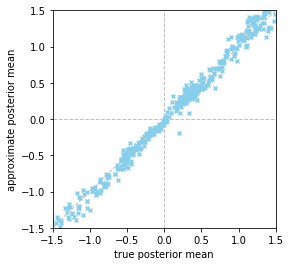

epoch 15 iteration 14000 loss 28.345 CE 26.687 KL 1.658 weighted KL: 1.658 weight 1.000
epoch 15 iteration 14100 loss 30.667 CE 29.046 KL 1.621 weighted KL: 1.621 weight 1.000
epoch 15 iteration 14200 loss 29.580 CE 27.977 KL 1.602 weighted KL: 1.602 weight 1.000
epoch 15 iteration 14300 loss 30.914 CE 29.268 KL 1.646 weighted KL: 1.646 weight 1.000
epoch 15 iteration 14400 loss 27.836 CE 26.070 KL 1.766 weighted KL: 1.766 weight 1.000
epoch 15 iteration 14500 loss 29.068 CE 27.470 KL 1.597 weighted KL: 1.597 weight 1.000
epoch 15 iteration 14600 loss 30.321 CE 28.647 KL 1.674 weighted KL: 1.674 weight 1.000
epoch 15 iteration 14700 loss 28.507 CE 26.917 KL 1.590 weighted KL: 1.590 weight 1.000
epoch 15 iteration 14800 loss 30.062 CE 28.520 KL 1.542 weighted KL: 1.542 weight 1.000
epoch 15 iteration 14900 loss 27.339 CE 25.796 KL 1.543 weighted KL: 1.543 weight 1.000
Epoch [15/30], Training Loss: 28.9124,  Training KL: 1.6450, Training Perplexity: 24.84, Validation Loss: 32.0680, KL 1.

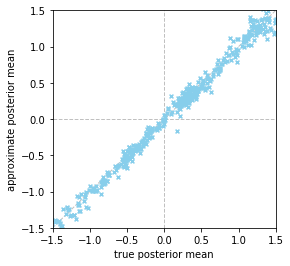

new lr: 0.001250
epoch 16 iteration 15000 loss 25.468 CE 23.814 KL 1.654 weighted KL: 1.654 weight 1.000
epoch 16 iteration 15100 loss 26.826 CE 25.225 KL 1.601 weighted KL: 1.601 weight 1.000
epoch 16 iteration 15200 loss 26.126 CE 24.517 KL 1.610 weighted KL: 1.610 weight 1.000
epoch 16 iteration 15300 loss 27.847 CE 26.357 KL 1.489 weighted KL: 1.489 weight 1.000
epoch 16 iteration 15400 loss 30.933 CE 29.329 KL 1.604 weighted KL: 1.604 weight 1.000
epoch 16 iteration 15500 loss 28.383 CE 26.805 KL 1.577 weighted KL: 1.577 weight 1.000
epoch 16 iteration 15600 loss 30.595 CE 29.055 KL 1.540 weighted KL: 1.540 weight 1.000
epoch 16 iteration 15700 loss 32.288 CE 30.681 KL 1.608 weighted KL: 1.608 weight 1.000
epoch 16 iteration 15800 loss 24.771 CE 23.204 KL 1.566 weighted KL: 1.566 weight 1.000
epoch 16 iteration 15900 loss 26.667 CE 25.063 KL 1.604 weighted KL: 1.604 weight 1.000
Epoch [16/30], Training Loss: 28.8735,  Training KL: 1.6450, Training Perplexity: 24.73, Validation Los

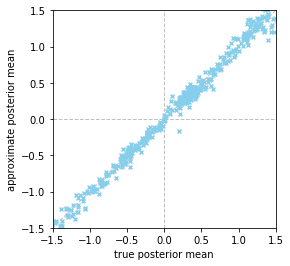

epoch 17 iteration 16000 loss 30.748 CE 29.154 KL 1.595 weighted KL: 1.595 weight 1.000
epoch 17 iteration 16100 loss 26.898 CE 25.374 KL 1.523 weighted KL: 1.523 weight 1.000
epoch 17 iteration 16200 loss 30.990 CE 29.308 KL 1.683 weighted KL: 1.683 weight 1.000
epoch 17 iteration 16300 loss 29.790 CE 28.170 KL 1.621 weighted KL: 1.621 weight 1.000
epoch 17 iteration 16400 loss 31.366 CE 29.687 KL 1.679 weighted KL: 1.679 weight 1.000
epoch 17 iteration 16500 loss 31.046 CE 29.374 KL 1.672 weighted KL: 1.672 weight 1.000
epoch 17 iteration 16600 loss 28.267 CE 26.608 KL 1.659 weighted KL: 1.659 weight 1.000
epoch 17 iteration 16700 loss 27.253 CE 25.713 KL 1.539 weighted KL: 1.539 weight 1.000
epoch 17 iteration 16800 loss 32.858 CE 31.230 KL 1.628 weighted KL: 1.628 weight 1.000
epoch 17 iteration 16900 loss 31.549 CE 29.841 KL 1.707 weighted KL: 1.707 weight 1.000
Epoch [17/30], Training Loss: 28.8420,  Training KL: 1.6230, Training Perplexity: 24.65, Validation Loss: 32.1571, KL 1.

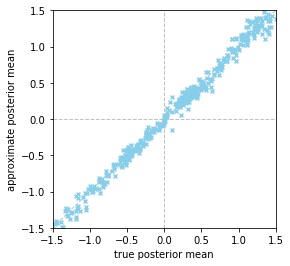

new lr: 0.000625
epoch 18 iteration 17000 loss 26.358 CE 24.756 KL 1.602 weighted KL: 1.602 weight 1.000
epoch 18 iteration 17100 loss 26.162 CE 24.486 KL 1.676 weighted KL: 1.676 weight 1.000
epoch 18 iteration 17200 loss 27.423 CE 25.824 KL 1.599 weighted KL: 1.599 weight 1.000
epoch 18 iteration 17300 loss 29.002 CE 27.375 KL 1.626 weighted KL: 1.626 weight 1.000
epoch 18 iteration 17400 loss 31.362 CE 29.766 KL 1.597 weighted KL: 1.597 weight 1.000
epoch 18 iteration 17500 loss 33.575 CE 31.843 KL 1.732 weighted KL: 1.732 weight 1.000
epoch 18 iteration 17600 loss 28.261 CE 26.564 KL 1.697 weighted KL: 1.697 weight 1.000
epoch 18 iteration 17700 loss 28.996 CE 27.358 KL 1.638 weighted KL: 1.638 weight 1.000
epoch 18 iteration 17800 loss 24.916 CE 23.253 KL 1.664 weighted KL: 1.664 weight 1.000
epoch 18 iteration 17900 loss 27.158 CE 25.593 KL 1.565 weighted KL: 1.565 weight 1.000
Epoch [18/30], Training Loss: 28.8326,  Training KL: 1.6271, Training Perplexity: 24.62, Validation Los

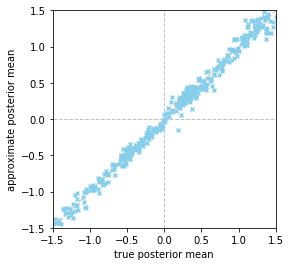

epoch 19 iteration 18000 loss 28.578 CE 26.931 KL 1.647 weighted KL: 1.647 weight 1.000
epoch 19 iteration 18100 loss 26.174 CE 24.592 KL 1.582 weighted KL: 1.582 weight 1.000
epoch 19 iteration 18200 loss 31.227 CE 29.497 KL 1.731 weighted KL: 1.731 weight 1.000
epoch 19 iteration 18300 loss 29.221 CE 27.667 KL 1.554 weighted KL: 1.554 weight 1.000
epoch 19 iteration 18400 loss 29.716 CE 28.175 KL 1.540 weighted KL: 1.540 weight 1.000
epoch 19 iteration 18500 loss 32.251 CE 30.639 KL 1.612 weighted KL: 1.612 weight 1.000
epoch 19 iteration 18600 loss 30.297 CE 28.703 KL 1.593 weighted KL: 1.593 weight 1.000
epoch 19 iteration 18700 loss 27.632 CE 26.070 KL 1.562 weighted KL: 1.562 weight 1.000
epoch 19 iteration 18800 loss 26.481 CE 24.882 KL 1.600 weighted KL: 1.600 weight 1.000
epoch 19 iteration 18900 loss 31.017 CE 29.248 KL 1.769 weighted KL: 1.769 weight 1.000
Epoch [19/30], Training Loss: 28.8071,  Training KL: 1.6470, Training Perplexity: 24.55, Validation Loss: 32.1915, KL 1.

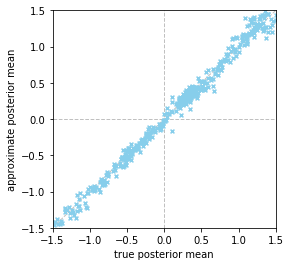

new lr: 0.000313


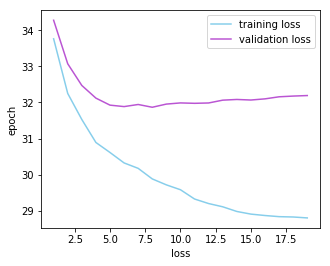

In [58]:
# aggressive training
vocab_size = 1000
hidden_size = 50
embedding_size = 50
latent_size = 1
num_layers = 1
step = 0.25
learning_rate = 0.01
epochs = 30
max_sentence_length = 10

embedding_weights = nn.Embedding(vocab_size, embedding_size).weight
vae_aggressive = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

return_dict_aggressive = train(vae_aggressive, inputs, targets, val_inputs, val_targets, epochs, vocab_size, hidden_size, 
                    latent_size, max_sentence_length, plot=True, learning_rate=learning_rate,
                    synthetic=True, step=step, tracked_inputs=tracked_inputs, tracked_targets=tracked_targets, 
                    plot_lim=1.5, is_aggressive=True, plot_dir="plots_aggressive")
plot_losses(return_dict_aggressive['total_epoch_losses'], return_dict_aggressive['val_total_epoch_losses'])

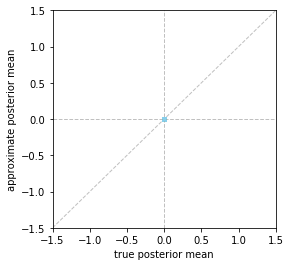

epoch 1 iteration 0 loss 62.159 CE 62.155 KL 0.004 weighted KL: 0.004 weight 1.000
epoch 1 iteration 100 loss 38.009 CE 36.941 KL 1.068 weighted KL: 1.068 weight 1.000
epoch 1 iteration 200 loss 31.654 CE 30.661 KL 0.993 weighted KL: 0.993 weight 1.000
epoch 1 iteration 300 loss 35.638 CE 34.367 KL 1.271 weighted KL: 1.271 weight 1.000
epoch 1 iteration 400 loss 33.085 CE 31.631 KL 1.454 weighted KL: 1.454 weight 1.000
epoch 1 iteration 500 loss 41.030 CE 39.669 KL 1.361 weighted KL: 1.361 weight 1.000
epoch 1 iteration 600 loss 34.893 CE 33.724 KL 1.169 weighted KL: 1.169 weight 1.000
epoch 1 iteration 700 loss 33.906 CE 32.750 KL 1.156 weighted KL: 1.156 weight 1.000
epoch 1 iteration 800 loss 32.997 CE 31.790 KL 1.207 weighted KL: 1.207 weight 1.000
epoch 1 iteration 900 loss 36.048 CE 34.850 KL 1.198 weighted KL: 1.198 weight 1.000
current_mi: 2.787183581352234
Epoch [1/30], Training Loss: 32.6783,  Training KL: 1.2879, Training Perplexity: 37.75, Validation Loss: 33.4011, KL 1.291

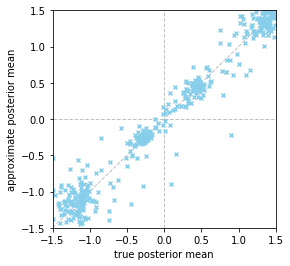

epoch 2 iteration 1000 loss 34.645 CE 33.326 KL 1.319 weighted KL: 1.319 weight 1.000
epoch 2 iteration 1100 loss 32.416 CE 31.202 KL 1.214 weighted KL: 1.214 weight 1.000
epoch 2 iteration 1200 loss 31.944 CE 30.804 KL 1.140 weighted KL: 1.140 weight 1.000
epoch 2 iteration 1300 loss 32.915 CE 31.576 KL 1.339 weighted KL: 1.339 weight 1.000
epoch 2 iteration 1400 loss 32.614 CE 31.476 KL 1.138 weighted KL: 1.138 weight 1.000
epoch 2 iteration 1500 loss 32.134 CE 30.957 KL 1.178 weighted KL: 1.178 weight 1.000
epoch 2 iteration 1600 loss 2487.642 CE 26.815 KL 2460.828 weighted KL: 2460.828 weight 1.000
epoch 2 iteration 1700 loss 33.493 CE 32.258 KL 1.235 weighted KL: 1.235 weight 1.000
epoch 2 iteration 1800 loss 39.407 CE 38.177 KL 1.230 weighted KL: 1.230 weight 1.000
epoch 2 iteration 1900 loss 33.219 CE 32.131 KL 1.087 weighted KL: 1.087 weight 1.000
current_mi: 2.758496512413025
STOP AGGRESSIVE
Epoch [2/30], Training Loss: 31.8735,  Training KL: 1.1783, Training Perplexity: 34.52

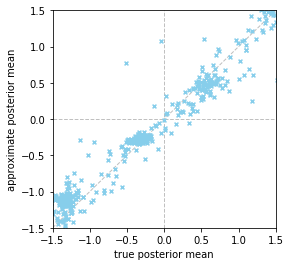

epoch 3 iteration 2000 loss 36.486 CE 35.299 KL 1.187 weighted KL: 1.187 weight 1.000
epoch 3 iteration 2100 loss 38.344 CE 37.417 KL 0.926 weighted KL: 0.926 weight 1.000
epoch 3 iteration 2200 loss 33.599 CE 32.397 KL 1.202 weighted KL: 1.202 weight 1.000
epoch 3 iteration 2300 loss 29.256 CE 28.212 KL 1.044 weighted KL: 1.044 weight 1.000
epoch 3 iteration 2400 loss 34.312 CE 33.280 KL 1.032 weighted KL: 1.032 weight 1.000
epoch 3 iteration 2500 loss 31.345 CE 30.351 KL 0.995 weighted KL: 0.995 weight 1.000
epoch 3 iteration 2600 loss 25.793 CE 24.699 KL 1.093 weighted KL: 1.093 weight 1.000
epoch 3 iteration 2700 loss 30.183 CE 29.016 KL 1.166 weighted KL: 1.166 weight 1.000
epoch 3 iteration 2800 loss 31.267 CE 30.169 KL 1.097 weighted KL: 1.097 weight 1.000
epoch 3 iteration 2900 loss 30.314 CE 29.269 KL 1.045 weighted KL: 1.045 weight 1.000
Epoch [3/30], Training Loss: 31.5078,  Training KL: 0.8670, Training Perplexity: 33.14, Validation Loss: 32.7203, KL 0.8730, Val Perplexity:

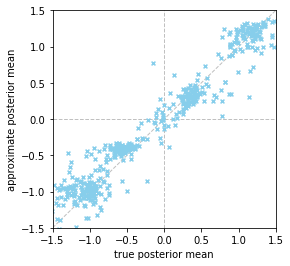

epoch 4 iteration 3000 loss 28.818 CE 27.918 KL 0.900 weighted KL: 0.900 weight 1.000
epoch 4 iteration 3100 loss 33.903 CE 33.163 KL 0.739 weighted KL: 0.739 weight 1.000
epoch 4 iteration 3200 loss 35.164 CE 34.437 KL 0.727 weighted KL: 0.727 weight 1.000
epoch 4 iteration 3300 loss 32.437 CE 31.626 KL 0.811 weighted KL: 0.811 weight 1.000
epoch 4 iteration 3400 loss 33.006 CE 32.298 KL 0.708 weighted KL: 0.708 weight 1.000
epoch 4 iteration 3500 loss 33.848 CE 33.140 KL 0.708 weighted KL: 0.708 weight 1.000
epoch 4 iteration 3600 loss 30.525 CE 29.699 KL 0.827 weighted KL: 0.827 weight 1.000
epoch 4 iteration 3700 loss 30.677 CE 29.967 KL 0.711 weighted KL: 0.711 weight 1.000
epoch 4 iteration 3800 loss 29.699 CE 28.934 KL 0.764 weighted KL: 0.764 weight 1.000
epoch 4 iteration 3900 loss 27.715 CE 27.038 KL 0.677 weighted KL: 0.677 weight 1.000
Epoch [4/30], Training Loss: 31.0997,  Training KL: 0.7393, Training Perplexity: 31.67, Validation Loss: 32.6676, KL 0.7427, Val Perplexity:

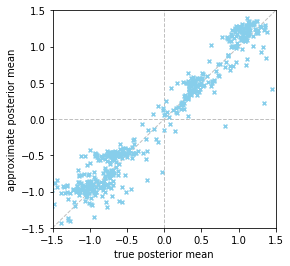

epoch 5 iteration 4000 loss 28.471 CE 27.628 KL 0.842 weighted KL: 0.842 weight 1.000
epoch 5 iteration 4100 loss 26.955 CE 26.245 KL 0.710 weighted KL: 0.710 weight 1.000
epoch 5 iteration 4200 loss 33.042 CE 31.744 KL 1.298 weighted KL: 1.298 weight 1.000
epoch 5 iteration 4300 loss 27.968 CE 27.326 KL 0.642 weighted KL: 0.642 weight 1.000
epoch 5 iteration 4400 loss 33.181 CE 32.570 KL 0.611 weighted KL: 0.611 weight 1.000
epoch 5 iteration 4500 loss 35.658 CE 35.011 KL 0.647 weighted KL: 0.647 weight 1.000
epoch 5 iteration 4600 loss 33.339 CE 32.608 KL 0.731 weighted KL: 0.731 weight 1.000
epoch 5 iteration 4700 loss 32.340 CE 31.640 KL 0.700 weighted KL: 0.700 weight 1.000
epoch 5 iteration 4800 loss 35.051 CE 34.539 KL 0.511 weighted KL: 0.511 weight 1.000
epoch 5 iteration 4900 loss 31.513 CE 30.786 KL 0.728 weighted KL: 0.728 weight 1.000
Epoch [5/30], Training Loss: 31.0041,  Training KL: 0.6756, Training Perplexity: 31.34, Validation Loss: 32.8269, KL 0.6770, Val Perplexity:

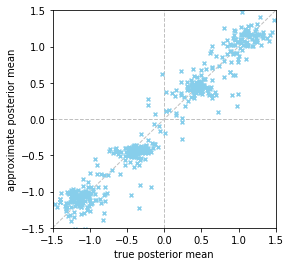

epoch 6 iteration 5000 loss 31.066 CE 30.361 KL 0.705 weighted KL: 0.705 weight 1.000
epoch 6 iteration 5100 loss 34.929 CE 34.187 KL 0.742 weighted KL: 0.742 weight 1.000
epoch 6 iteration 5200 loss 29.853 CE 29.174 KL 0.679 weighted KL: 0.679 weight 1.000
epoch 6 iteration 5300 loss 33.468 CE 32.943 KL 0.525 weighted KL: 0.525 weight 1.000
epoch 6 iteration 5400 loss 31.582 CE 30.928 KL 0.654 weighted KL: 0.654 weight 1.000
epoch 6 iteration 5500 loss 26.416 CE 25.860 KL 0.556 weighted KL: 0.556 weight 1.000
epoch 6 iteration 5600 loss 26.768 CE 26.225 KL 0.543 weighted KL: 0.543 weight 1.000
epoch 6 iteration 5700 loss 34.409 CE 33.722 KL 0.686 weighted KL: 0.686 weight 1.000
epoch 6 iteration 5800 loss 33.605 CE 33.013 KL 0.592 weighted KL: 0.592 weight 1.000
epoch 6 iteration 5900 loss 34.493 CE 33.931 KL 0.562 weighted KL: 0.562 weight 1.000
Epoch [6/30], Training Loss: 30.8658,  Training KL: 0.6780, Training Perplexity: 30.86, Validation Loss: 32.7334, KL 0.6823, Val Perplexity:

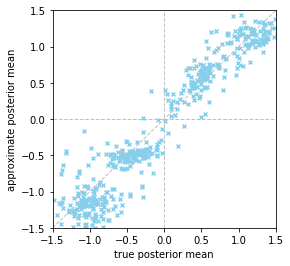

new lr: 0.025000
epoch 7 iteration 6000 loss 32.208 CE 31.567 KL 0.641 weighted KL: 0.641 weight 1.000
epoch 7 iteration 6100 loss 31.933 CE 31.254 KL 0.679 weighted KL: 0.679 weight 1.000
epoch 7 iteration 6200 loss 31.324 CE 30.873 KL 0.451 weighted KL: 0.451 weight 1.000
epoch 7 iteration 6300 loss 27.449 CE 26.854 KL 0.595 weighted KL: 0.595 weight 1.000
epoch 7 iteration 6400 loss 30.181 CE 29.599 KL 0.582 weighted KL: 0.582 weight 1.000
epoch 7 iteration 6500 loss 30.045 CE 29.470 KL 0.575 weighted KL: 0.575 weight 1.000
epoch 7 iteration 6600 loss 29.374 CE 28.731 KL 0.643 weighted KL: 0.643 weight 1.000
epoch 7 iteration 6700 loss 31.092 CE 30.470 KL 0.622 weighted KL: 0.622 weight 1.000
epoch 7 iteration 6800 loss 27.453 CE 26.863 KL 0.590 weighted KL: 0.590 weight 1.000
epoch 7 iteration 6900 loss 27.590 CE 27.062 KL 0.527 weighted KL: 0.527 weight 1.000
Epoch [7/30], Training Loss: 30.1709,  Training KL: 0.6226, Training Perplexity: 28.57, Validation Loss: 32.3256, KL 0.6307

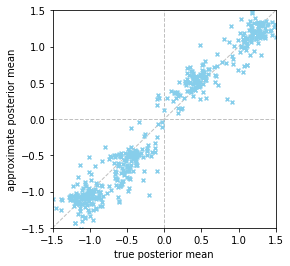

epoch 8 iteration 7000 loss 35.012 CE 34.418 KL 0.593 weighted KL: 0.593 weight 1.000
epoch 8 iteration 7100 loss 28.596 CE 27.972 KL 0.624 weighted KL: 0.624 weight 1.000
epoch 8 iteration 7200 loss 33.345 CE 32.717 KL 0.629 weighted KL: 0.629 weight 1.000
epoch 8 iteration 7300 loss 28.506 CE 27.658 KL 0.849 weighted KL: 0.849 weight 1.000
epoch 8 iteration 7400 loss 30.248 CE 29.643 KL 0.605 weighted KL: 0.605 weight 1.000
epoch 8 iteration 7500 loss 27.324 CE 26.644 KL 0.679 weighted KL: 0.679 weight 1.000
epoch 8 iteration 7600 loss 28.475 CE 27.893 KL 0.582 weighted KL: 0.582 weight 1.000
epoch 8 iteration 7700 loss 33.764 CE 33.232 KL 0.532 weighted KL: 0.532 weight 1.000
epoch 8 iteration 7800 loss 31.455 CE 30.999 KL 0.455 weighted KL: 0.455 weight 1.000
epoch 8 iteration 7900 loss 30.159 CE 29.510 KL 0.650 weighted KL: 0.650 weight 1.000
Epoch [8/30], Training Loss: 29.9352,  Training KL: 0.6148, Training Perplexity: 27.83, Validation Loss: 32.2523, KL 0.6197, Val Perplexity:

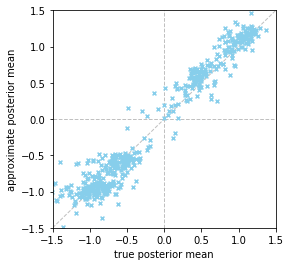

epoch 9 iteration 8000 loss 31.926 CE 31.310 KL 0.616 weighted KL: 0.616 weight 1.000
epoch 9 iteration 8100 loss 33.263 CE 32.838 KL 0.426 weighted KL: 0.426 weight 1.000
epoch 9 iteration 8200 loss 29.393 CE 28.864 KL 0.528 weighted KL: 0.528 weight 1.000
epoch 9 iteration 8300 loss 30.203 CE 29.724 KL 0.479 weighted KL: 0.479 weight 1.000
epoch 9 iteration 8400 loss 28.607 CE 28.158 KL 0.449 weighted KL: 0.449 weight 1.000
epoch 9 iteration 8500 loss 29.442 CE 28.978 KL 0.464 weighted KL: 0.464 weight 1.000
epoch 9 iteration 8600 loss 29.508 CE 28.939 KL 0.569 weighted KL: 0.569 weight 1.000
epoch 9 iteration 8700 loss 30.983 CE 30.474 KL 0.509 weighted KL: 0.509 weight 1.000
epoch 9 iteration 8800 loss 32.994 CE 32.534 KL 0.460 weighted KL: 0.460 weight 1.000
epoch 9 iteration 8900 loss 28.862 CE 28.341 KL 0.521 weighted KL: 0.521 weight 1.000
Epoch [9/30], Training Loss: 29.8942,  Training KL: 0.5147, Training Perplexity: 27.70, Validation Loss: 32.4369, KL 0.5201, Val Perplexity:

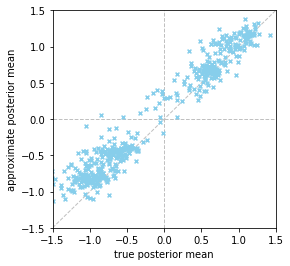

epoch 10 iteration 9000 loss 29.985 CE 29.469 KL 0.516 weighted KL: 0.516 weight 1.000
epoch 10 iteration 9100 loss 32.084 CE 31.540 KL 0.543 weighted KL: 0.543 weight 1.000
epoch 10 iteration 9200 loss 34.912 CE 34.437 KL 0.475 weighted KL: 0.475 weight 1.000
epoch 10 iteration 9300 loss 31.551 CE 31.036 KL 0.515 weighted KL: 0.515 weight 1.000
epoch 10 iteration 9400 loss 35.486 CE 34.964 KL 0.522 weighted KL: 0.522 weight 1.000
epoch 10 iteration 9500 loss 30.708 CE 30.132 KL 0.576 weighted KL: 0.576 weight 1.000
epoch 10 iteration 9600 loss 28.907 CE 28.325 KL 0.582 weighted KL: 0.582 weight 1.000
epoch 10 iteration 9700 loss 28.627 CE 28.016 KL 0.611 weighted KL: 0.611 weight 1.000
epoch 10 iteration 9800 loss 33.039 CE 32.502 KL 0.537 weighted KL: 0.537 weight 1.000
epoch 10 iteration 9900 loss 32.517 CE 31.989 KL 0.528 weighted KL: 0.528 weight 1.000
Epoch [10/30], Training Loss: 29.6380,  Training KL: 0.6003, Training Perplexity: 26.93, Validation Loss: 32.4397, KL 0.6041, Val 

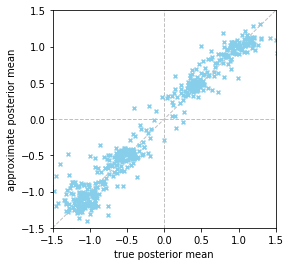

new lr: 0.012500
epoch 11 iteration 10000 loss 26.902 CE 26.296 KL 0.607 weighted KL: 0.607 weight 1.000
epoch 11 iteration 10100 loss 31.089 CE 30.570 KL 0.519 weighted KL: 0.519 weight 1.000
epoch 11 iteration 10200 loss 29.438 CE 28.867 KL 0.572 weighted KL: 0.572 weight 1.000
epoch 11 iteration 10300 loss 33.117 CE 32.553 KL 0.564 weighted KL: 0.564 weight 1.000
epoch 11 iteration 10400 loss 26.654 CE 26.076 KL 0.578 weighted KL: 0.578 weight 1.000
epoch 11 iteration 10500 loss 28.581 CE 27.934 KL 0.647 weighted KL: 0.647 weight 1.000
epoch 11 iteration 10600 loss 31.810 CE 31.263 KL 0.547 weighted KL: 0.547 weight 1.000
epoch 11 iteration 10700 loss 27.000 CE 26.553 KL 0.447 weighted KL: 0.447 weight 1.000
epoch 11 iteration 10800 loss 30.776 CE 30.282 KL 0.494 weighted KL: 0.494 weight 1.000
epoch 11 iteration 10900 loss 32.006 CE 31.492 KL 0.514 weighted KL: 0.514 weight 1.000
Epoch [11/30], Training Loss: 29.3297,  Training KL: 0.5283, Training Perplexity: 26.02, Validation Los

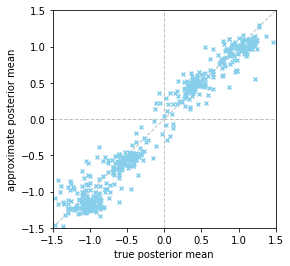

epoch 12 iteration 11000 loss 30.145 CE 29.590 KL 0.555 weighted KL: 0.555 weight 1.000
epoch 12 iteration 11100 loss 29.004 CE 28.478 KL 0.526 weighted KL: 0.526 weight 1.000
epoch 12 iteration 11200 loss 25.627 CE 25.073 KL 0.554 weighted KL: 0.554 weight 1.000
epoch 12 iteration 11300 loss 28.705 CE 28.247 KL 0.458 weighted KL: 0.458 weight 1.000
epoch 12 iteration 11400 loss 30.379 CE 29.884 KL 0.495 weighted KL: 0.495 weight 1.000
epoch 12 iteration 11500 loss 29.578 CE 29.116 KL 0.462 weighted KL: 0.462 weight 1.000
epoch 12 iteration 11600 loss 31.349 CE 30.851 KL 0.498 weighted KL: 0.498 weight 1.000
epoch 12 iteration 11700 loss 29.965 CE 29.512 KL 0.453 weighted KL: 0.453 weight 1.000
epoch 12 iteration 11800 loss 36.243 CE 35.692 KL 0.551 weighted KL: 0.551 weight 1.000
epoch 12 iteration 11900 loss 26.596 CE 26.108 KL 0.488 weighted KL: 0.488 weight 1.000
Epoch [12/30], Training Loss: 29.1825,  Training KL: 0.5607, Training Perplexity: 25.60, Validation Loss: 32.4538, KL 0.

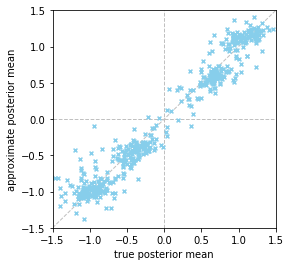

new lr: 0.006250
epoch 13 iteration 12000 loss 30.373 CE 29.785 KL 0.588 weighted KL: 0.588 weight 1.000
epoch 13 iteration 12100 loss 29.222 CE 28.692 KL 0.531 weighted KL: 0.531 weight 1.000
epoch 13 iteration 12200 loss 29.230 CE 28.706 KL 0.524 weighted KL: 0.524 weight 1.000
epoch 13 iteration 12300 loss 27.999 CE 27.420 KL 0.579 weighted KL: 0.579 weight 1.000
epoch 13 iteration 12400 loss 26.116 CE 25.556 KL 0.560 weighted KL: 0.560 weight 1.000
epoch 13 iteration 12500 loss 28.697 CE 28.165 KL 0.532 weighted KL: 0.532 weight 1.000
epoch 13 iteration 12600 loss 30.066 CE 29.530 KL 0.536 weighted KL: 0.536 weight 1.000
epoch 13 iteration 12700 loss 27.791 CE 27.220 KL 0.571 weighted KL: 0.571 weight 1.000
epoch 13 iteration 12800 loss 24.227 CE 23.697 KL 0.529 weighted KL: 0.529 weight 1.000
epoch 13 iteration 12900 loss 27.355 CE 26.784 KL 0.570 weighted KL: 0.570 weight 1.000
Epoch [13/30], Training Loss: 29.0712,  Training KL: 0.5563, Training Perplexity: 25.28, Validation Los

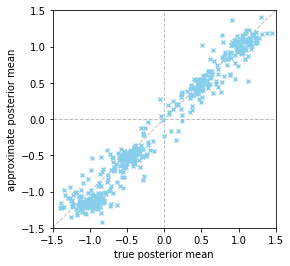

epoch 14 iteration 13000 loss 28.765 CE 28.166 KL 0.598 weighted KL: 0.598 weight 1.000
epoch 14 iteration 13100 loss 26.630 CE 26.152 KL 0.478 weighted KL: 0.478 weight 1.000
epoch 14 iteration 13200 loss 26.004 CE 25.397 KL 0.607 weighted KL: 0.607 weight 1.000
epoch 14 iteration 13300 loss 25.851 CE 25.373 KL 0.478 weighted KL: 0.478 weight 1.000
epoch 14 iteration 13400 loss 26.742 CE 26.159 KL 0.583 weighted KL: 0.583 weight 1.000
epoch 14 iteration 13500 loss 28.801 CE 28.224 KL 0.577 weighted KL: 0.577 weight 1.000
epoch 14 iteration 13600 loss 31.528 CE 30.938 KL 0.590 weighted KL: 0.590 weight 1.000
epoch 14 iteration 13700 loss 29.885 CE 29.317 KL 0.568 weighted KL: 0.568 weight 1.000
epoch 14 iteration 13800 loss 35.833 CE 35.242 KL 0.591 weighted KL: 0.591 weight 1.000
epoch 14 iteration 13900 loss 31.655 CE 31.109 KL 0.546 weighted KL: 0.546 weight 1.000
Epoch [14/30], Training Loss: 28.9752,  Training KL: 0.5562, Training Perplexity: 25.01, Validation Loss: 32.5632, KL 0.

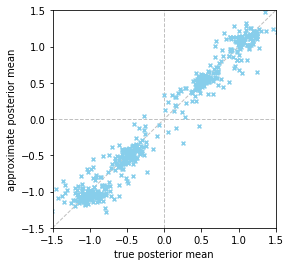

new lr: 0.003125
epoch 15 iteration 14000 loss 24.618 CE 24.129 KL 0.489 weighted KL: 0.489 weight 1.000
epoch 15 iteration 14100 loss 28.617 CE 28.074 KL 0.543 weighted KL: 0.543 weight 1.000
epoch 15 iteration 14200 loss 22.984 CE 22.396 KL 0.588 weighted KL: 0.588 weight 1.000
epoch 15 iteration 14300 loss 33.361 CE 32.796 KL 0.565 weighted KL: 0.565 weight 1.000
epoch 15 iteration 14400 loss 28.667 CE 28.023 KL 0.643 weighted KL: 0.643 weight 1.000
epoch 15 iteration 14500 loss 26.984 CE 26.430 KL 0.554 weighted KL: 0.554 weight 1.000
epoch 15 iteration 14600 loss 29.139 CE 28.571 KL 0.568 weighted KL: 0.568 weight 1.000
epoch 15 iteration 14700 loss 32.944 CE 32.366 KL 0.578 weighted KL: 0.578 weight 1.000
epoch 15 iteration 14800 loss 29.260 CE 28.675 KL 0.586 weighted KL: 0.586 weight 1.000
epoch 15 iteration 14900 loss 32.774 CE 32.190 KL 0.584 weighted KL: 0.584 weight 1.000
Epoch [15/30], Training Loss: 28.9631,  Training KL: 0.5598, Training Perplexity: 24.98, Validation Los

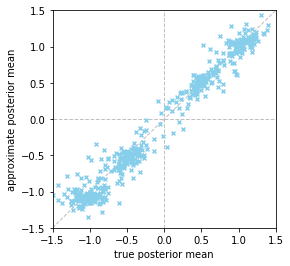

epoch 16 iteration 15000 loss 29.176 CE 28.575 KL 0.601 weighted KL: 0.601 weight 1.000
epoch 16 iteration 15100 loss 29.663 CE 29.107 KL 0.556 weighted KL: 0.556 weight 1.000
epoch 16 iteration 15200 loss 28.508 CE 27.954 KL 0.555 weighted KL: 0.555 weight 1.000
epoch 16 iteration 15300 loss 31.799 CE 31.322 KL 0.477 weighted KL: 0.477 weight 1.000
epoch 16 iteration 15400 loss 25.292 CE 24.719 KL 0.572 weighted KL: 0.572 weight 1.000
epoch 16 iteration 15500 loss 30.741 CE 30.175 KL 0.566 weighted KL: 0.566 weight 1.000
epoch 16 iteration 15600 loss 33.352 CE 32.817 KL 0.534 weighted KL: 0.534 weight 1.000
epoch 16 iteration 15700 loss 29.117 CE 28.534 KL 0.583 weighted KL: 0.583 weight 1.000
epoch 16 iteration 15800 loss 32.268 CE 31.733 KL 0.535 weighted KL: 0.535 weight 1.000
epoch 16 iteration 15900 loss 28.846 CE 28.248 KL 0.598 weighted KL: 0.598 weight 1.000
Epoch [16/30], Training Loss: 28.9057,  Training KL: 0.5462, Training Perplexity: 24.82, Validation Loss: 32.6555, KL 0.

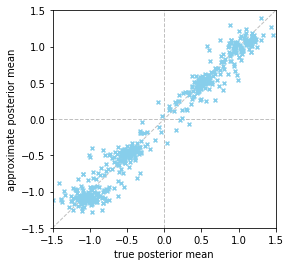

new lr: 0.001563


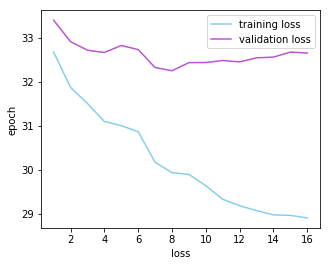

In [88]:
# aggressive training
vocab_size = 1000
hidden_size = 50
embedding_size = 50
latent_size = 1
num_layers = 1
step = 0.25
learning_rate = 0.05
epochs = 30
max_sentence_length = 10

embedding_weights = nn.Embedding(vocab_size, embedding_size).weight
vae_aggressive_new = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

return_dict_aggressive_new = train(vae_aggressive_new, inputs, targets, val_inputs, val_targets, epochs, vocab_size, hidden_size, 
                    latent_size, max_sentence_length, plot=True, learning_rate=learning_rate,
                    synthetic=True, step=step, tracked_inputs=tracked_inputs, tracked_targets=tracked_targets, 
                    plot_lim=1.5, is_aggressive=True, plot_dir="plots_aggressive_new")
plot_losses(return_dict_aggressive_new['total_epoch_losses'], return_dict_aggressive_new['val_total_epoch_losses'])

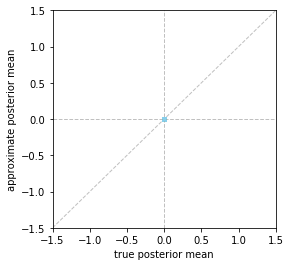

epoch 1 iteration 0 loss 62.178 CE 62.177 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 1 iteration 100 loss 40.087 CE 38.063 KL 2.024 weighted KL: 2.024 weight 1.000
epoch 1 iteration 200 loss 38.494 CE 37.479 KL 1.015 weighted KL: 1.015 weight 1.000
epoch 1 iteration 300 loss 32.920 CE 31.856 KL 1.064 weighted KL: 1.064 weight 1.000
epoch 1 iteration 400 loss 36.407 CE 35.496 KL 0.911 weighted KL: 0.911 weight 1.000
epoch 1 iteration 500 loss 31.954 CE 30.799 KL 1.154 weighted KL: 1.154 weight 1.000
epoch 1 iteration 600 loss 29.877 CE 28.836 KL 1.041 weighted KL: 1.041 weight 1.000
epoch 1 iteration 700 loss 32.887 CE 31.744 KL 1.143 weighted KL: 1.143 weight 1.000
epoch 1 iteration 800 loss 37.513 CE 36.471 KL 1.042 weighted KL: 1.042 weight 1.000
epoch 1 iteration 900 loss 33.363 CE 32.432 KL 0.931 weighted KL: 0.931 weight 1.000
current_mi: 2.7712098693847658
Epoch [1/30], Training Loss: 32.7091,  Training KL: 1.1540, Training Perplexity: 37.88, Validation Loss: 33.4336, KL 1.17

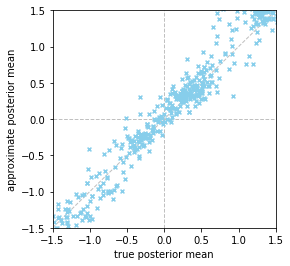

epoch 2 iteration 1000 loss 27.080 CE 26.156 KL 0.923 weighted KL: 0.923 weight 1.000
epoch 2 iteration 1100 loss 31.815 CE 30.749 KL 1.065 weighted KL: 1.065 weight 1.000
epoch 2 iteration 1200 loss 35.199 CE 34.139 KL 1.060 weighted KL: 1.060 weight 1.000
epoch 2 iteration 1300 loss 32.259 CE 31.241 KL 1.019 weighted KL: 1.019 weight 1.000
epoch 2 iteration 1400 loss 37.672 CE 36.665 KL 1.007 weighted KL: 1.007 weight 1.000
epoch 2 iteration 1500 loss 28.300 CE 27.332 KL 0.967 weighted KL: 0.967 weight 1.000
epoch 2 iteration 1600 loss 31.957 CE 31.000 KL 0.957 weighted KL: 0.957 weight 1.000
epoch 2 iteration 1700 loss 28.861 CE 27.685 KL 1.176 weighted KL: 1.176 weight 1.000
epoch 2 iteration 1800 loss 31.155 CE 29.966 KL 1.189 weighted KL: 1.189 weight 1.000
epoch 2 iteration 1900 loss 32.446 CE 31.357 KL 1.088 weighted KL: 1.088 weight 1.000
current_mi: 2.756983742713928
STOP AGGRESSIVE
Epoch [2/30], Training Loss: 31.7165,  Training KL: 0.9981, Training Perplexity: 33.92, Valida

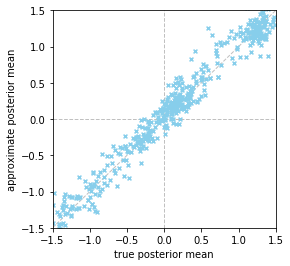

epoch 3 iteration 2000 loss 32.533 CE 31.540 KL 0.993 weighted KL: 0.993 weight 1.000
epoch 3 iteration 2100 loss 34.659 CE 33.550 KL 1.110 weighted KL: 1.110 weight 1.000
epoch 3 iteration 2200 loss 29.127 CE 28.158 KL 0.970 weighted KL: 0.970 weight 1.000
epoch 3 iteration 2300 loss 31.301 CE 30.303 KL 0.998 weighted KL: 0.998 weight 1.000
epoch 3 iteration 2400 loss 34.171 CE 33.249 KL 0.921 weighted KL: 0.921 weight 1.000
epoch 3 iteration 2500 loss 33.180 CE 32.118 KL 1.062 weighted KL: 1.062 weight 1.000
epoch 3 iteration 2600 loss 32.609 CE 31.600 KL 1.009 weighted KL: 1.009 weight 1.000
epoch 3 iteration 2700 loss 31.689 CE 30.736 KL 0.953 weighted KL: 0.953 weight 1.000
epoch 3 iteration 2800 loss 34.098 CE 33.064 KL 1.035 weighted KL: 1.035 weight 1.000
epoch 3 iteration 2900 loss 27.663 CE 26.533 KL 1.130 weighted KL: 1.130 weight 1.000
Epoch [3/30], Training Loss: 31.3808,  Training KL: 1.0004, Training Perplexity: 32.68, Validation Loss: 32.6749, KL 1.0104, Val Perplexity:

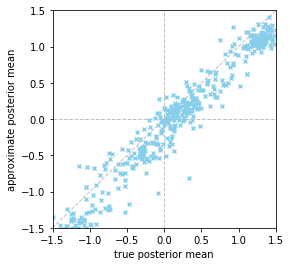

epoch 4 iteration 3000 loss 28.374 CE 27.434 KL 0.940 weighted KL: 0.940 weight 1.000
epoch 4 iteration 3100 loss 31.678 CE 30.777 KL 0.901 weighted KL: 0.901 weight 1.000
epoch 4 iteration 3200 loss 31.881 CE 30.903 KL 0.979 weighted KL: 0.979 weight 1.000
epoch 4 iteration 3300 loss 30.737 CE 29.628 KL 1.109 weighted KL: 1.109 weight 1.000
epoch 4 iteration 3400 loss 29.650 CE 28.642 KL 1.008 weighted KL: 1.008 weight 1.000
epoch 4 iteration 3500 loss 30.896 CE 29.966 KL 0.931 weighted KL: 0.931 weight 1.000
epoch 4 iteration 3600 loss 33.881 CE 32.835 KL 1.046 weighted KL: 1.046 weight 1.000
epoch 4 iteration 3700 loss 28.434 CE 27.304 KL 1.131 weighted KL: 1.131 weight 1.000
epoch 4 iteration 3800 loss 37.561 CE 36.658 KL 0.903 weighted KL: 0.903 weight 1.000
epoch 4 iteration 3900 loss 31.052 CE 30.094 KL 0.958 weighted KL: 0.958 weight 1.000
Epoch [4/30], Training Loss: 30.9451,  Training KL: 0.9602, Training Perplexity: 31.14, Validation Loss: 32.4551, KL 0.9647, Val Perplexity:

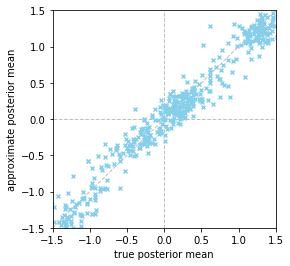

epoch 5 iteration 4000 loss 29.774 CE 28.716 KL 1.057 weighted KL: 1.057 weight 1.000
epoch 5 iteration 4100 loss 36.508 CE 35.514 KL 0.994 weighted KL: 0.994 weight 1.000
epoch 5 iteration 4200 loss 29.702 CE 28.785 KL 0.917 weighted KL: 0.917 weight 1.000
epoch 5 iteration 4300 loss 34.826 CE 33.830 KL 0.996 weighted KL: 0.996 weight 1.000
epoch 5 iteration 4400 loss 33.843 CE 32.905 KL 0.938 weighted KL: 0.938 weight 1.000
epoch 5 iteration 4500 loss 34.611 CE 33.592 KL 1.018 weighted KL: 1.018 weight 1.000
epoch 5 iteration 4600 loss 30.099 CE 29.131 KL 0.969 weighted KL: 0.969 weight 1.000
epoch 5 iteration 4700 loss 32.127 CE 31.199 KL 0.928 weighted KL: 0.928 weight 1.000
epoch 5 iteration 4800 loss 29.084 CE 27.902 KL 1.183 weighted KL: 1.183 weight 1.000
epoch 5 iteration 4900 loss 32.490 CE 31.486 KL 1.004 weighted KL: 1.004 weight 1.000
Epoch [5/30], Training Loss: 30.7938,  Training KL: 1.0139, Training Perplexity: 30.62, Validation Loss: 32.5726, KL 1.0134, Val Perplexity:

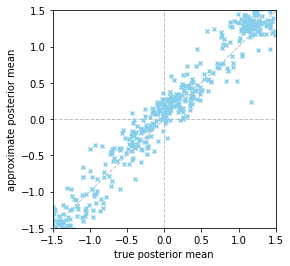

epoch 6 iteration 5000 loss 35.347 CE 34.363 KL 0.984 weighted KL: 0.984 weight 1.000
epoch 6 iteration 5100 loss 32.030 CE 31.079 KL 0.951 weighted KL: 0.951 weight 1.000
epoch 6 iteration 5200 loss 31.777 CE 30.836 KL 0.941 weighted KL: 0.941 weight 1.000
epoch 6 iteration 5300 loss 33.081 CE 32.026 KL 1.055 weighted KL: 1.055 weight 1.000
epoch 6 iteration 5400 loss 28.310 CE 27.283 KL 1.027 weighted KL: 1.027 weight 1.000
epoch 6 iteration 5500 loss 34.687 CE 33.775 KL 0.912 weighted KL: 0.912 weight 1.000
epoch 6 iteration 5600 loss 32.087 CE 31.089 KL 0.998 weighted KL: 0.998 weight 1.000
epoch 6 iteration 5700 loss 31.713 CE 30.803 KL 0.910 weighted KL: 0.910 weight 1.000
epoch 6 iteration 5800 loss 31.841 CE 31.009 KL 0.832 weighted KL: 0.832 weight 1.000
epoch 6 iteration 5900 loss 32.718 CE 31.859 KL 0.859 weighted KL: 0.859 weight 1.000
Epoch [6/30], Training Loss: 30.6609,  Training KL: 0.9485, Training Perplexity: 30.17, Validation Loss: 32.5886, KL 0.9512, Val Perplexity:

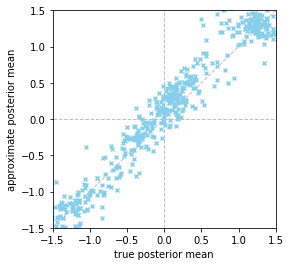

new lr: 0.025000
epoch 7 iteration 6000 loss 33.250 CE 32.285 KL 0.965 weighted KL: 0.965 weight 1.000
epoch 7 iteration 6100 loss 30.411 CE 29.634 KL 0.777 weighted KL: 0.777 weight 1.000
epoch 7 iteration 6200 loss 28.892 CE 28.100 KL 0.792 weighted KL: 0.792 weight 1.000
epoch 7 iteration 6300 loss 34.177 CE 33.320 KL 0.856 weighted KL: 0.856 weight 1.000
epoch 7 iteration 6400 loss 30.139 CE 29.333 KL 0.806 weighted KL: 0.806 weight 1.000
epoch 7 iteration 6500 loss 28.877 CE 28.060 KL 0.817 weighted KL: 0.817 weight 1.000
epoch 7 iteration 6600 loss 31.304 CE 30.328 KL 0.976 weighted KL: 0.976 weight 1.000
epoch 7 iteration 6700 loss 31.514 CE 30.644 KL 0.869 weighted KL: 0.869 weight 1.000
epoch 7 iteration 6800 loss 32.624 CE 31.878 KL 0.746 weighted KL: 0.746 weight 1.000
epoch 7 iteration 6900 loss 30.151 CE 29.256 KL 0.895 weighted KL: 0.895 weight 1.000
Epoch [7/30], Training Loss: 30.0176,  Training KL: 0.8558, Training Perplexity: 28.09, Validation Loss: 32.1809, KL 0.8540

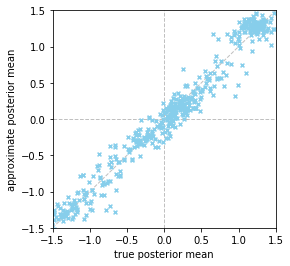

epoch 8 iteration 7000 loss 28.636 CE 27.745 KL 0.891 weighted KL: 0.891 weight 1.000
epoch 8 iteration 7100 loss 37.161 CE 36.403 KL 0.758 weighted KL: 0.758 weight 1.000
epoch 8 iteration 7200 loss 28.759 CE 27.947 KL 0.811 weighted KL: 0.811 weight 1.000
epoch 8 iteration 7300 loss 34.441 CE 33.684 KL 0.757 weighted KL: 0.757 weight 1.000
epoch 8 iteration 7400 loss 29.788 CE 28.848 KL 0.940 weighted KL: 0.940 weight 1.000
epoch 8 iteration 7500 loss 27.576 CE 26.689 KL 0.887 weighted KL: 0.887 weight 1.000
epoch 8 iteration 7600 loss 28.141 CE 27.301 KL 0.840 weighted KL: 0.840 weight 1.000
epoch 8 iteration 7700 loss 27.752 CE 26.759 KL 0.993 weighted KL: 0.993 weight 1.000
epoch 8 iteration 7800 loss 29.730 CE 28.857 KL 0.873 weighted KL: 0.873 weight 1.000
epoch 8 iteration 7900 loss 27.530 CE 26.553 KL 0.977 weighted KL: 0.977 weight 1.000
Epoch [8/30], Training Loss: 29.8027,  Training KL: 0.8987, Training Perplexity: 27.42, Validation Loss: 32.3258, KL 0.8980, Val Perplexity:

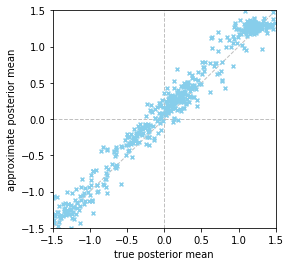

epoch 9 iteration 8000 loss 30.475 CE 29.573 KL 0.902 weighted KL: 0.902 weight 1.000
epoch 9 iteration 8100 loss 31.031 CE 30.178 KL 0.853 weighted KL: 0.853 weight 1.000
epoch 9 iteration 8200 loss 29.598 CE 28.669 KL 0.930 weighted KL: 0.930 weight 1.000
epoch 9 iteration 8300 loss 37.117 CE 36.314 KL 0.803 weighted KL: 0.803 weight 1.000
epoch 9 iteration 8400 loss 30.691 CE 29.735 KL 0.956 weighted KL: 0.956 weight 1.000
epoch 9 iteration 8500 loss 25.448 CE 24.542 KL 0.906 weighted KL: 0.906 weight 1.000
epoch 9 iteration 8600 loss 30.359 CE 29.390 KL 0.969 weighted KL: 0.969 weight 1.000
epoch 9 iteration 8700 loss 29.974 CE 28.997 KL 0.977 weighted KL: 0.977 weight 1.000
epoch 9 iteration 8800 loss 26.815 CE 25.962 KL 0.853 weighted KL: 0.853 weight 1.000
epoch 9 iteration 8900 loss 33.161 CE 32.318 KL 0.843 weighted KL: 0.843 weight 1.000
Epoch [9/30], Training Loss: 29.6067,  Training KL: 0.8815, Training Perplexity: 26.83, Validation Loss: 32.2841, KL 0.8850, Val Perplexity:

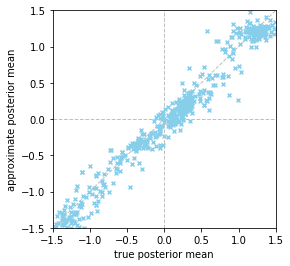

new lr: 0.012500
epoch 10 iteration 9000 loss 32.505 CE 31.602 KL 0.903 weighted KL: 0.903 weight 1.000
epoch 10 iteration 9100 loss 29.373 CE 28.456 KL 0.916 weighted KL: 0.916 weight 1.000
epoch 10 iteration 9200 loss 30.516 CE 29.494 KL 1.022 weighted KL: 1.022 weight 1.000
epoch 10 iteration 9300 loss 31.547 CE 30.610 KL 0.937 weighted KL: 0.937 weight 1.000
epoch 10 iteration 9400 loss 28.952 CE 28.052 KL 0.900 weighted KL: 0.900 weight 1.000
epoch 10 iteration 9500 loss 31.448 CE 30.636 KL 0.812 weighted KL: 0.812 weight 1.000
epoch 10 iteration 9600 loss 29.607 CE 28.857 KL 0.750 weighted KL: 0.750 weight 1.000
epoch 10 iteration 9700 loss 33.769 CE 32.835 KL 0.934 weighted KL: 0.934 weight 1.000
epoch 10 iteration 9800 loss 28.602 CE 27.668 KL 0.934 weighted KL: 0.934 weight 1.000
epoch 10 iteration 9900 loss 27.599 CE 26.695 KL 0.904 weighted KL: 0.904 weight 1.000
Epoch [10/30], Training Loss: 29.3526,  Training KL: 0.8981, Training Perplexity: 26.09, Validation Loss: 32.2639

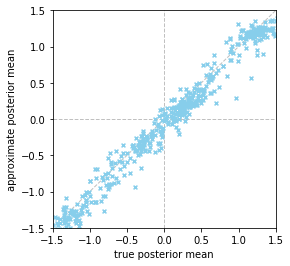

epoch 11 iteration 10000 loss 32.533 CE 31.678 KL 0.854 weighted KL: 0.854 weight 1.000
epoch 11 iteration 10100 loss 23.651 CE 22.770 KL 0.881 weighted KL: 0.881 weight 1.000
epoch 11 iteration 10200 loss 31.409 CE 30.449 KL 0.960 weighted KL: 0.960 weight 1.000
epoch 11 iteration 10300 loss 33.024 CE 32.074 KL 0.950 weighted KL: 0.950 weight 1.000
epoch 11 iteration 10400 loss 30.259 CE 29.394 KL 0.865 weighted KL: 0.865 weight 1.000
epoch 11 iteration 10500 loss 28.969 CE 28.052 KL 0.917 weighted KL: 0.917 weight 1.000
epoch 11 iteration 10600 loss 29.082 CE 28.164 KL 0.918 weighted KL: 0.918 weight 1.000
epoch 11 iteration 10700 loss 30.305 CE 29.316 KL 0.988 weighted KL: 0.988 weight 1.000
epoch 11 iteration 10800 loss 29.044 CE 28.065 KL 0.978 weighted KL: 0.978 weight 1.000
epoch 11 iteration 10900 loss 32.016 CE 31.112 KL 0.905 weighted KL: 0.905 weight 1.000
Epoch [11/30], Training Loss: 29.1739,  Training KL: 0.9275, Training Perplexity: 25.57, Validation Loss: 32.3784, KL 0.

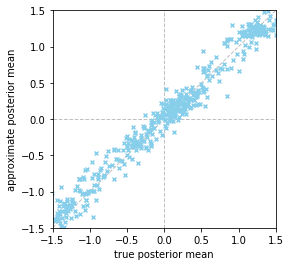

epoch 12 iteration 11000 loss 26.540 CE 25.478 KL 1.062 weighted KL: 1.062 weight 1.000
epoch 12 iteration 11100 loss 33.299 CE 32.389 KL 0.909 weighted KL: 0.909 weight 1.000
epoch 12 iteration 11200 loss 29.873 CE 28.964 KL 0.909 weighted KL: 0.909 weight 1.000
epoch 12 iteration 11300 loss 29.031 CE 28.174 KL 0.857 weighted KL: 0.857 weight 1.000
epoch 12 iteration 11400 loss 27.185 CE 26.376 KL 0.809 weighted KL: 0.809 weight 1.000
epoch 12 iteration 11500 loss 27.622 CE 26.741 KL 0.881 weighted KL: 0.881 weight 1.000
epoch 12 iteration 11600 loss 27.000 CE 26.105 KL 0.895 weighted KL: 0.895 weight 1.000
epoch 12 iteration 11700 loss 27.636 CE 26.767 KL 0.870 weighted KL: 0.870 weight 1.000
epoch 12 iteration 11800 loss 28.366 CE 27.371 KL 0.994 weighted KL: 0.994 weight 1.000
epoch 12 iteration 11900 loss 27.916 CE 26.946 KL 0.969 weighted KL: 0.969 weight 1.000
Epoch [12/30], Training Loss: 29.0950,  Training KL: 0.9688, Training Perplexity: 25.35, Validation Loss: 32.4739, KL 0.

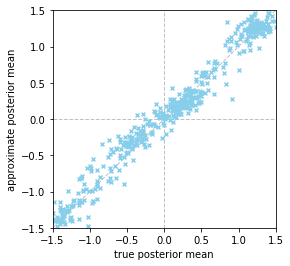

new lr: 0.006250
epoch 13 iteration 12000 loss 30.239 CE 29.230 KL 1.008 weighted KL: 1.008 weight 1.000
epoch 13 iteration 12100 loss 29.069 CE 28.179 KL 0.890 weighted KL: 0.890 weight 1.000
epoch 13 iteration 12200 loss 29.911 CE 29.094 KL 0.817 weighted KL: 0.817 weight 1.000
epoch 13 iteration 12300 loss 34.175 CE 33.381 KL 0.794 weighted KL: 0.794 weight 1.000
epoch 13 iteration 12400 loss 25.673 CE 24.800 KL 0.873 weighted KL: 0.873 weight 1.000
epoch 13 iteration 12500 loss 32.515 CE 31.632 KL 0.883 weighted KL: 0.883 weight 1.000
epoch 13 iteration 12600 loss 24.860 CE 23.850 KL 1.010 weighted KL: 1.010 weight 1.000
epoch 13 iteration 12700 loss 27.906 CE 27.079 KL 0.827 weighted KL: 0.827 weight 1.000
epoch 13 iteration 12800 loss 28.291 CE 27.296 KL 0.995 weighted KL: 0.995 weight 1.000
epoch 13 iteration 12900 loss 30.537 CE 29.633 KL 0.904 weighted KL: 0.904 weight 1.000
Epoch [13/30], Training Loss: 28.9873,  Training KL: 0.8567, Training Perplexity: 25.05, Validation Los

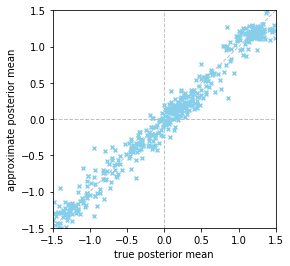

epoch 14 iteration 13000 loss 28.944 CE 28.018 KL 0.926 weighted KL: 0.926 weight 1.000
epoch 14 iteration 13100 loss 27.999 CE 27.145 KL 0.854 weighted KL: 0.854 weight 1.000
epoch 14 iteration 13200 loss 31.492 CE 30.612 KL 0.881 weighted KL: 0.881 weight 1.000
epoch 14 iteration 13300 loss 24.728 CE 23.719 KL 1.009 weighted KL: 1.009 weight 1.000
epoch 14 iteration 13400 loss 28.597 CE 27.743 KL 0.855 weighted KL: 0.855 weight 1.000
epoch 14 iteration 13500 loss 30.037 CE 29.120 KL 0.917 weighted KL: 0.917 weight 1.000
epoch 14 iteration 13600 loss 31.129 CE 30.236 KL 0.893 weighted KL: 0.893 weight 1.000
epoch 14 iteration 13700 loss 27.104 CE 26.169 KL 0.935 weighted KL: 0.935 weight 1.000
epoch 14 iteration 13800 loss 28.301 CE 27.467 KL 0.833 weighted KL: 0.833 weight 1.000
epoch 14 iteration 13900 loss 32.667 CE 31.804 KL 0.863 weighted KL: 0.863 weight 1.000
Epoch [14/30], Training Loss: 28.8729,  Training KL: 0.9485, Training Perplexity: 24.73, Validation Loss: 32.5126, KL 0.

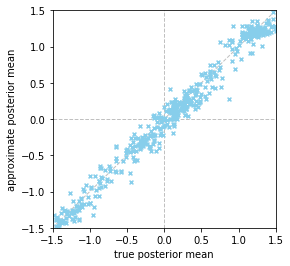

new lr: 0.003125
epoch 15 iteration 14000 loss 29.826 CE 28.847 KL 0.978 weighted KL: 0.978 weight 1.000
epoch 15 iteration 14100 loss 29.611 CE 28.670 KL 0.941 weighted KL: 0.941 weight 1.000
epoch 15 iteration 14200 loss 30.893 CE 29.883 KL 1.011 weighted KL: 1.011 weight 1.000
epoch 15 iteration 14300 loss 27.310 CE 26.373 KL 0.937 weighted KL: 0.937 weight 1.000
epoch 15 iteration 14400 loss 28.658 CE 27.761 KL 0.897 weighted KL: 0.897 weight 1.000
epoch 15 iteration 14500 loss 29.464 CE 28.552 KL 0.913 weighted KL: 0.913 weight 1.000
epoch 15 iteration 14600 loss 28.095 CE 27.168 KL 0.927 weighted KL: 0.927 weight 1.000
epoch 15 iteration 14700 loss 31.140 CE 30.140 KL 1.000 weighted KL: 1.000 weight 1.000
epoch 15 iteration 14800 loss 27.467 CE 26.521 KL 0.946 weighted KL: 0.946 weight 1.000
epoch 15 iteration 14900 loss 32.131 CE 31.281 KL 0.850 weighted KL: 0.850 weight 1.000
Epoch [15/30], Training Loss: 28.8524,  Training KL: 0.9534, Training Perplexity: 24.68, Validation Los

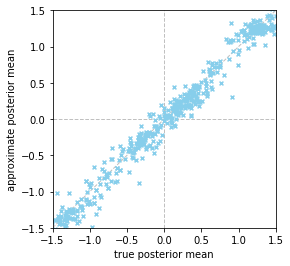

epoch 16 iteration 15000 loss 27.917 CE 27.058 KL 0.859 weighted KL: 0.859 weight 1.000
epoch 16 iteration 15100 loss 28.316 CE 27.446 KL 0.871 weighted KL: 0.871 weight 1.000
epoch 16 iteration 15200 loss 29.081 CE 28.154 KL 0.927 weighted KL: 0.927 weight 1.000
epoch 16 iteration 15300 loss 29.949 CE 29.014 KL 0.935 weighted KL: 0.935 weight 1.000
epoch 16 iteration 15400 loss 26.127 CE 25.153 KL 0.975 weighted KL: 0.975 weight 1.000
epoch 16 iteration 15500 loss 31.963 CE 31.036 KL 0.928 weighted KL: 0.928 weight 1.000
epoch 16 iteration 15600 loss 29.715 CE 28.728 KL 0.987 weighted KL: 0.987 weight 1.000
epoch 16 iteration 15700 loss 30.771 CE 29.785 KL 0.986 weighted KL: 0.986 weight 1.000
epoch 16 iteration 15800 loss 28.388 CE 27.526 KL 0.863 weighted KL: 0.863 weight 1.000
epoch 16 iteration 15900 loss 31.623 CE 30.843 KL 0.779 weighted KL: 0.779 weight 1.000
Epoch [16/30], Training Loss: 28.8078,  Training KL: 0.9384, Training Perplexity: 24.55, Validation Loss: 32.5797, KL 0.

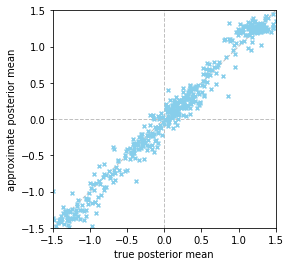

new lr: 0.001563


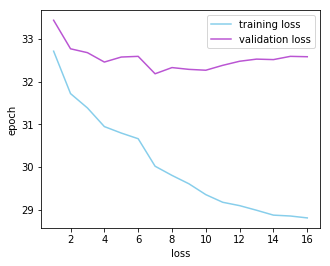

In [92]:
# aggressive training
vocab_size = 1000
hidden_size = 50
embedding_size = 50
latent_size = 1
num_layers = 1
step = 0.25
learning_rate = 0.05
epochs = 30
max_sentence_length = 10

embedding_weights = nn.Embedding(vocab_size, embedding_size).weight
vae_aggressive_new_new = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

return_dict_aggressive_new_new = train(vae_aggressive_new_new, inputs, targets, val_inputs, val_targets, epochs, vocab_size, hidden_size, 
                    latent_size, max_sentence_length, plot=True, learning_rate=learning_rate,
                    synthetic=True, step=step, tracked_inputs=tracked_inputs, tracked_targets=tracked_targets, 
                    plot_lim=1.5, is_aggressive=True, plot_dir="plots_aggressive_new_new")
plot_losses(return_dict_aggressive_new_new['total_epoch_losses'], return_dict_aggressive_new_new['val_total_epoch_losses'])

In [ ]:
# aggressive training
vocab_size = 1000
hidden_size = 50
embedding_size = 50
latent_size = 1
num_layers = 1
step = 0.25
learning_rate = 0.05
epochs = 30
max_sentence_length = 10

embedding_weights = nn.Embedding(vocab_size, embedding_size).weight
vae_test = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

return_dict_test = train(vae_test, inputs, targets, val_inputs, val_targets, epochs, vocab_size, hidden_size, 
                    latent_size, max_sentence_length, plot=True, learning_rate=learning_rate,
                    synthetic=True, step=step, tracked_inputs=tracked_inputs, tracked_targets=tracked_targets, 
                    plot_lim=1.5, is_aggressive=True, plot_dir="plots")
# plot_losses(return_dict_aggressive_new_new['total_epoch_losses'], return_dict_aggressive_new_new['val_total_epoch_losses'])

In [ ]:
hist_active_units(vae, inputs)

# TEXT DATA

### Load Penn Treebank data

In [ ]:
max_sentence_length = 50
train_data, train_data_padded = load_data("data/ptb.train.txt", max_sentence_length)
val_data, val_data_padded = load_data("data/ptb.valid.txt", max_sentence_length)
test_data, test_data_padded = load_data("data/ptb.test.txt", max_sentence_length)

In [ ]:
embedding_size = 500
epochs_w2v = 100

word2vec_model = Word2Vec(train_data, min_count=1, size=embedding_size, window=5)
word2vec_model.train(train_data, epochs=epochs_w2v, total_examples=word2vec_model.corpus_count)

word2vec_model = Word2Vec.load("word2vec.model")
# print(word2vec_model.wv.most_similar("stocks"))
# word2vec_model.wv['credit']

vocabulary_size = len(word2vec_model.wv.vocab)
# print("size of the vocabulary:", vocabulary_size)
# word2vec_model.save("word2vec.model")

In [ ]:
# make the word embeddings into a pythorch tensor
embedding_weights = word2vec_model.wv.vectors
embedding_weights = np.vstack((embedding_weights, np.zeros((1,embedding_size))))  # add zero vector for <pad>
embedding_weights = torch.tensor(embedding_weights)

In [ ]:
batch_size = 20
use_first_k = 500
padding_index = vocabulary_size
train_batches, train_targets, train_sentence_lens = get_batches_text(train_data[:use_first_k], train_data_padded[:use_first_k], 
                                                                batch_size, padding_index, word2vec_model)

In [ ]:
#with annealing
vocab_size = 1000
hidden_size = 50
embedding_size = 50
latent_size = 2
num_layers = 1
step = 0.25
learning_rate = 0.01
epochs = 1

vae = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=False)

annealing_args = {'type':'logistic', 'step':0, 'k':0.0025, 'first_step':2500}

train(vae, inputs, targets, val_inputs, val_targets, epochs, vocab_size, hidden_size, latent_size, max_sentence_length, plot=False, learning_rate=learning_rate,
      synthetic=True, step=step, plot_lim=3, annealing_args=annealing_args, tracked_inputs=tracked_inputs, 
      tracked_targets=tracked_targets)

### Inference/Generation/Interpolation

In [ ]:
def generate(vae, z, first_word_index, last_word_index, max_sentence_length):
    generator_batch_size = z.shape[0]
    hidden_concatenated = vae.stochastic_decoder.forward(z)
    hidden = torch.split(hidden_concatenated, vae.hidden_dim, dim=-1)
    generated_sequence = greedy(vae, hidden, first_word_index, last_word_index, max_sentence_length, generator_batch_size)
    return generated_sequence

def greedy(vae, hidden, first_word_index, last_word_index, max_sentence_length, generator_batch_size):
    vae_decoder = vae.decoder   
    first_word_index = torch.tensor(first_word_index, dtype=torch.long)
    predicted = []
    curr_words = torch.tensor([first_word_index] * generator_batch_size, dtype=torch.long).unsqueeze(1)
    iteration = 0
    while iteration != max_sentence_length: #next_word_index != last_word_index and
        curr_words_embeddings = vae_decoder.embed(curr_words)
        curr_words_embeddings = curr_words_embeddings.view(generator_batch_size, 1, vae_decoder.embedding_size)
        
        outputs, hidden = vae_decoder.lstm(curr_words_embeddings.float(), (hidden[0].unsqueeze(0), hidden[1].unsqueeze(0)))
        outputs = vae_decoder.linear(outputs)
        outputs = outputs.squeeze(1)
        hidden = (hidden[0].squeeze(0), hidden[1].squeeze(0))
        softmax_outputs = F.softmax(outputs, dim=1).detach().numpy()
    
        next_words_indices = []
        for t in range(generator_batch_size):
            
            # IS THE NEXT LINE OK? DO INDICES MATCH PROBABILITES?            
            
            next_words_indices.append(np.random.choice(np.arange(softmax_outputs.shape[1]), size=1, p=softmax_outputs[t])[0])        
        curr_words = torch.tensor(next_words_indices, dtype=torch.long).unsqueeze(1)
                
        predicted.append(next_words_indices)

        iteration += 1
        
#     if predicted[-1] != last_word_index:
#         predicted.append(last_word_index)
    return predicted

In [ ]:
z1 = torch.randn([latent_size]).numpy()
z2 = torch.randn([latent_size]).numpy()
number_of_sentences_to_decode = 2
max_sentence_length = 10
interpolation_points = generate_interpolation_sequence(z1, z2, number_of_sentences_to_decode=number_of_sentences_to_decode)

sentences = generate(vae, torch.tensor(interpolation_points, dtype=torch.float), word2vec_model.wv.vocab['<sos>'].index, word2vec_model.wv.vocab['<eos>'].index, max_sentence_length)
words_sentences = []
sentences = np.array(sentences).T
for curr_sentence in sentences:
    words_curr_sentence = []
    for j in curr_sentence:
        words_curr_sentence.append(word2vec_model.wv.index2word[j])
    words_sentences.append(words_curr_sentence)
for s in words_sentences:
    for word in s:
        print(word, end = ' ')
    print()

### Create Word2Vec word embeddings

### Define RNNLM

In [ ]:
class RNNLM(nn.Module):
    def __init__(self, vocabulary_size, embedding_size, hidden_size, num_layers, embedding_weights):
        super(RNNLM, self).__init__()
        self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocabulary_size)
        self.embedding_size = embedding_size
        
    def forward(self, x, hidden, x_lens, train=True):
        batch_size, max_len, _ = x.shape
        embedding_dim = self.embedding_size

        x = self.embed(torch.tensor(x, dtype=torch.long)).view(batch_size, max_len, embedding_dim)
        if train:
            x_lens = torch.tensor(x_lens, dtype=torch.long)
            x = pack_padded_sequence(x, x_lens, batch_first=True)

        out, hidden = self.lstm(x.float(), hidden) 
        
        if train:
            out, output_lens = pad_packed_sequence(out, batch_first=True, total_length=max_sentence_length-1)

        out = out.reshape(out.size(0)*out.size(1), out.size(2))
        out = self.linear(out)
        
        return out, hidden

### Train and predict with RNNLM

In [ ]:
input_size = 100
output_size = 100
hidden_size = 50

batch_size = 20
use_first_k = 500
padding_index = vocabulary_size
train_batches, train_targets, train_sentence_lens = get_batches_text(train_data[:use_first_k], train_data_padded[:use_first_k], 
                                                                batch_size, padding_index, word2vec_model)

# make the word embeddings into a pythorch tensor
embedding_weights = word2vec_model.wv.vectors
embedding_weights = np.vstack((embedding_weights, np.zeros((1,embedding_size))))  # add zero vector for <pad>
embedding_weights = torch.tensor(embedding_weights)

learning_rate = 0.001
num_layers = 1
epochs = 100

model = RNNLM(vocabulary_size, embedding_size, hidden_size, num_layers, embedding_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    hidden = (torch.zeros(num_layers, batch_size, hidden_size), torch.zeros(num_layers, batch_size, hidden_size))
    for i in range(len(train_batches)):
        x = train_batches[i]
        x_lens = train_sentence_lens[i]
        y = torch.tensor(train_targets[i].reshape(-1), dtype=torch.long)   
        h, c = hidden
        h = h.detach()
        c = c.detach()
        hidden = (h, c)
    
        outputs, hidden = model(x, hidden, x_lens)
        
        mask = (y < padding_index)
        loss = nn.CrossEntropyLoss()(outputs[mask], y[mask])

        model.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    if epoch % 1 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}, Perplexity: {:5.2f}'
               .format(epoch + 1, epochs, loss.item(), np.exp(loss.item())))

In [ ]:
# Predict
test_sentences = ["in terms"]
sentence, _ = tokenize_sentence(test_sentences[0], max_sentence_length)
sentence = sentence[:-1]
word_indexes = np.array([word2vec_model.wv.vocab[word].index for word in sentence]).reshape(1, len(sentence), 1)

hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))
h, c = hidden
h = h.detach()
c = c.detach()
hidden = (h, c)

outputs, hidden = model(word_indexes, hidden, x_lens, train=False)
softmax_outputs = F.softmax(outputs, dim=1).detach().numpy()
last_word = softmax_outputs[-1,:]

predicted_next_word_idx = np.random.choice(range(len(last_word)), p=last_word)
print("Argmax: ", word2vec_model.wv.index2word[np.argmax(last_word)])
print("Next word: ", word2vec_model.wv.index2word[predicted_next_word_idx])

### Yelp data

In [ ]:
max_sentence_len = 50
yelp_train_data_original, yelp_train_data_padded = load_data("yelp_data/yelp.train.txt", max_sentence_len, with_labels=True)
yelp_test_data_original, yelp_test_data_padded = load_data("yelp_data/yelp.test.txt", max_sentence_len, with_labels=True)
yelp_val_dat_original, yelp_val_data_padded = load_data("yelp_data/yelp.valid.txt", max_sentence_len, with_labels=True)

In [ ]:
embedding_size = 512
epochs_w2v = 100
word2vec_model_name = "word2vec_yelp.model"

if os.path.isfile(word2vec_model_name):
    print('Loading word2vec model:', word2vec_model_name)
    word2vec_yelp = Word2Vec.load(word2vec_model_name)
else:
    print('Training word2vec model')
    word2vec_yelp = Word2Vec(yelp_train_data_original, min_count=1, size=embedding_size, window=5)
    word2vec_yelp.train(yelp_train_data_original, epochs=epochs_w2v, total_examples=word2vec_yelp.corpus_count)
    word2vec_yelp.save(word2vec_model_name)
    print('Saved word2vec model:', word2vec_model_name)

In [ ]:
# make the word embeddings into a pythorch tensor
embedding_weights = word2vec_yelp.wv.vectors
embedding_weights = np.vstack((embedding_weights, np.zeros((1,embedding_size))))  # add zero vector for <pad>
embedding_weights = torch.tensor(embedding_weights)

In [ ]:
print(word2vec_yelp.wv.most_similar("coffee"))

In [ ]:
batch_size = 16
vocabulary_size = len(word2vec_yelp.wv.vocab)
padding_index = vocabulary_size

yelp_train_inputs, yelp_train_targets, yelp_train_lengths = \
                get_batches_text(yelp_train_data_original, yelp_train_data_padded, batch_size, padding_index, word2vec_yelp, '_unk')

yelp_test_inputs, yelp_test_targets, yelp_test_lengths = \
                get_batches_text(yelp_test_data_original, yelp_test_data_padded, batch_size, padding_index, word2vec_yelp, '_unk')

yelp_val_inputs, yelp_val_targets, yelp_val_lengths = \
                get_batches_text(yelp_val_dat_original, yelp_val_data_padded, batch_size, padding_index, word2vec_yelp, '_unk')

In [ ]:
hidden_size = 1024
latent_size = 1
num_layers = 1
step = 0.25
learning_rate = 0.01
epochs = 5

vae = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

train(vae, yelp_train_inputs[:], yelp_train_targets[:], yelp_val_inputs, yelp_val_targets, epochs, vocabulary_size, 
      hidden_size, latent_size, max_sentence_length, yelp_train_lengths[:], plot=False, learning_rate=learning_rate,
      synthetic=False, step=step, tracked_inputs=None, tracked_targets=None, plot_lim=1.5)

## ENCODER-DECODER BASELINE

In [ ]:
class Baseline(nn.Module):
    # just a basic encoder-decoder with no VAE layers in the middle
    def __init__(self, hidden_dim, num_layers, embedding_weights, synthetic=False):
        super(Baseline, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_first = True
        
        self.encoder = Encoder(self.hidden_dim, num_layers, embedding_weights, synthetic)
        self.decoder = Decoder(self.hidden_dim, num_layers, embedding_weights, synthetic)

        if synthetic:          
            for param in self.parameters():
                nn.init.uniform_(param, -0.01, 0.01)
            nn.init.uniform_(self.encoder.embed.weight, -0.1, 0.1)
            nn.init.uniform_(self.decoder.embed.weight, -0.1, 0.1)
        
    def encode(self, x, x_lens=None):
        batch_size, max_len, _ = x.shape
        hidden = self.encoder.init_hidden(batch_size)
        _, hidden = self.encoder.forward(x, hidden, x_lens)
        return hidden
        
    def decode(self, hidden, x, x_lens=None, train=True): 
        outputs, _ = self.decoder.forward(x, hidden, x_lens, train)
        return outputs
    
    def forward(self, x, x_lens=None):
        # the last hidden state of the encoder is the first hidden state of the decoder
        hidden = self.encode(x, x_lens)
#         hidden_concatenated = self.stochastic_decoder.forward(z)
#         hidden = torch.split(hidden_concatenated, self.hidden_dim, dim=2)
        outputs = self.decode(hidden, x, x_lens)
        return outputs

In [ ]:
def baseline_loss_function(outputs, labels, seq_length, batch_size, mask=None):
    if mask is not None:
        BCE = torch.zeros(batch_size * (seq_length - 1))
        BCE[mask] = nn.CrossEntropyLoss(reduction='none')(outputs, labels)
    else:
        BCE = nn.CrossEntropyLoss(reduction='none')(outputs, labels)
    BCE = BCE.view(batch_size, -1).sum(-1)
    return BCE

In [ ]:
def test_baseline(model, inputs, targets, input_lens, synthetic=False):
    total_loss = 0
    num_words = num_sents = 0
    for i in np.random.permutation(len(inputs)):
        x = inputs[i]
        y = torch.tensor(targets[i].reshape(-1), dtype=torch.long)
        x_lens = input_lens[i] if not synthetic else None

        batch_size, sents_len, _ = x.shape
        if synthetic:
            num_words += batch_size * sents_len
        else:
            num_words = np.sum(x_lens)
        num_sents += batch_size
        
        mask = None
        outputs = model(x, x_lens=x_lens)
        if not synthetic:
            mask = (y < padding_index)
            outputs = outputs[mask]
            y = y[mask]
        curr_loss = baseline_loss_function(outputs, y, max_sentence_length, batch_size, mask=mask)
        curr_loss = np.sum(curr_loss.data.numpy())
        total_loss += curr_loss.item()
    
    total_loss /= num_sents
    ppl = np.exp(total_loss * num_sents / num_words)
    return total_loss, ppl

In [ ]:
def train_baseline(model, inputs, targets, val_inputs, val_targets, epochs, vocab_size, hidden_size, 
                   max_sentence_length, input_lens=None, val_input_lens=None, synthetic=False, 
                   num_layers=1, learning_rate=0.001, verbose_level=1, plot=False):

    opt_dict = {"not_improved": 0, "lr": learning_rate, "best_loss": 1e4}
    decay_epoch = 2
    lr_decay = 0.5
    max_decay = 5
    decay_cnt = 0
    
    enc_optimizer = torch.optim.SGD(model.encoder.parameters(), lr=learning_rate)
    dec_optimizer = torch.optim.SGD(model.decoder.parameters(), lr=learning_rate)

    iteration = 0
    train_losses = []
    val_losses = []
            
    for epoch in range(epochs):        
        for i in np.random.permutation(len(inputs)):
            x = inputs[i]
            y = torch.tensor(targets[i].reshape(-1), dtype=torch.long)
            x_lens = input_lens[i] if not synthetic else None 
          
            batch_size, _, _ = x.shape
            mask = None
            # do the forward pass
            outputs = model(x, x_lens=x_lens)

            if not synthetic:
                mask = (y < padding_index)
                outputs = outputs[mask]
                y = y[mask]
            
            enc_optimizer.zero_grad()
            dec_optimizer.zero_grad()
            
            # compute the cross entropy loss
            loss = baseline_loss_function(outputs, y, max_sentence_length, batch_size, mask=mask)                
            loss = loss.mean(dim=-1) # take the mean (same as divide by batch size?)
            
            # backward pass
            loss.backward()
            clip_grad_norm_(model.parameters(), 5.0)
            enc_optimizer.step()
            dec_optimizer.step()
            
            if (iteration % 100 == 0) and (verbose_level == 2):
                print('epoch {}\titeration {}\ttraining loss {:.3f}'.format(epoch+1, iteration, loss))

            iteration += 1
              
        # evaluate on the validation data
        model.eval()
        with torch.no_grad():
            train_loss, train_ppl = test_baseline(model, inputs, targets, input_lens, synthetic)
            val_loss, val_ppl = test_baseline(model, val_inputs, val_targets, val_input_lens, synthetic)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            if verbose_level > 0:
                print ('Epoch [{}/{}], Training Loss: {:.4f} Perplexity: {:.4f}, Validation Loss: {:.4f} Perplexity {:.4f}'
                       .format(epoch+1, epochs, train_loss, train_ppl, val_loss, val_ppl))

            # are we still decaying with the same logic?
            if val_loss > opt_dict["best_loss"]:
                opt_dict["not_improved"] += 1
                if opt_dict["not_improved"] >= decay_epoch:
                    opt_dict["best_loss"] = val_loss
                    opt_dict["not_improved"] = 0
                    opt_dict["lr"] = opt_dict["lr"] * lr_decay
                    #vae.load_state_dict(torch.load(args.save_path))
                    print('new lr: %f' % opt_dict["lr"])
                    decay_cnt += 1

                    enc_optimizer = torch.optim.SGD(model.encoder.parameters(), lr=opt_dict["lr"])
                    dec_optimizer = torch.optim.SGD(model.decoder.parameters(), lr=opt_dict["lr"])
            else:
                opt_dict["not_improved"] = 0
                opt_dict["best_loss"] = val_loss
            
            if decay_cnt == max_decay:
                break
        model.train()
    
    if plot:
        plt.plot(train_losses)
        plt.plot(val_losses)
        plt.show()

In [ ]:
# without annealing
vocab_size = 1000
hidden_size = 50
embedding_size = 50
num_layers = 1
learning_rate = 1.0
epochs = 20
max_sentence_length = 10

embedding_weights = nn.Embedding(vocab_size, embedding_size).weight
baseline_model = Baseline(hidden_size, num_layers, embedding_weights, synthetic=True)

# verbose level 0 - print nothing
# verbose level 1 - print only at the end of each epoch
# verbose level 2 - print everything
verbose_level = 1

train_baseline(baseline_model, inputs, targets, val_inputs, val_targets, epochs, vocab_size, hidden_size, max_sentence_length, 
               learning_rate=learning_rate, synthetic=True, verbose_level=verbose_level, plot=True)

## Word dropout

In [ ]:
max_sentence_length = 50
train_data, train_data_padded = load_data("data/ptb.train.txt", max_sentence_length)
val_data, val_data_padded = load_data("data/ptb.valid.txt", max_sentence_length)
test_data, test_data_padded = load_data("data/ptb.test.txt", max_sentence_length)

In [ ]:
embedding_size = 512
epochs_w2v = 100

word2vec_model = Word2Vec(train_data, min_count=1, size=embedding_size, window=5)
word2vec_model.train(train_data, epochs=epochs_w2v, total_examples=word2vec_model.corpus_count)

# word2vec_model = Word2Vec.load("word2vec.model")
# print(word2vec_model.wv.most_similar("stocks"))
# word2vec_model.wv['credit']

vocabulary_size = len(word2vec_model.wv.vocab)
# print("size of the vocabulary:", vocabulary_size)
# word2vec_model.save("word2vec.model")

In [ ]:
# make the word embeddings into a pythorch tensor
embedding_weights = word2vec_model.wv.vectors
embedding_weights = np.vstack((embedding_weights, np.zeros((1,embedding_size))))  # add zero vector for <pad>
embedding_weights = torch.tensor(embedding_weights)

In [ ]:
batch_size = 32
# use_first_k = 500
padding_index = vocabulary_size
train_batches, train_targets, train_sentence_lens = get_batches_text(train_data, train_data_padded, batch_size, padding_index, word2vec_model)
val_batches, val_targets, val_sentence_lens = get_batches_text(val_data, val_data_padded, batch_size, padding_index, word2vec_model)

In [ ]:
hidden_size = 1024
latent_size = 13
num_layers = 1
learning_rate = 0.01
epochs = 10

# dropout rate 80%
unk_index = word2vec_model.wv.vocab["<unk>"].index
dropout_prob = 0.8

vae = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=False)

train(vae, train_batches, train_targets, val_batches, val_targets, epochs, vocab_size, hidden_size, latent_size, 
      max_sentence_length, plot=False, verbose=True, learning_rate=learning_rate, synthetic=False,
      input_lens=train_sentence_lens, val_input_lens=val_sentence_lens, unk_index=unk_index, dropout_rate=dropout_prob)